In [ ]:
!pip install fastai

In [ ]:
from fastai.vision import *

In [ ]:
!curl -L "https://app.roboflow.com/ds/UoyNsp34EB?key=hYtkHo3upS" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   889  100   889    0     0    904      0 --:--:-- --:--:-- --:--:--   903
100 50.8M  100 50.8M    0     0  33.4M      0  0:00:01  0:00:01 --:--:--  152M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
   creating: test/Bounty/
 extracting: test/Bounty/5488-970_jpg.rf.708d9d67cf72be9053001d6ab4d4e7a1.jpg  
 extracting: test/Bounty/9045270626334_jpg.rf.2f2b44d1885a71681f6db9fa65afdcd8.jpg  
 extracting: test/Bounty/IMG_5354_029_jpg.rf.451b4f3ba0828cec6930c6b47a21a751.jpg  
 extracting: test/Bounty/IMG_5354_035_jpg.rf.04a295c24a92565005187c26bb113a48.jpg  
 extracting: test/Bounty/IMG_5354_041_jpg.rf.c066d30c85ae7c30b6eab5511ca4f1f9.jpg  
 extracting: test/Bounty/IMG_5354_050_jpg.rf.d1e9e597fd6d5cd61b227318ea49ff76.jpg  
 extracting: test/Bounty/IMG_5354_086_jpg.rf.c00a0ae907419ebc45c27893cba98527

In [ ]:
#build fastai dataset loader
np.random.seed(42)
#fastai automatically factors the ./train and ./valid folders into seperate datasets
#more details https://docs.fast.ai/vision.data.html#ImageDataLoaders.from_folder
path = Path('/content/')
data = ImageDataBunch.from_folder(path, size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
data.classes

['Bounty',
 'Chocolate',
 'Coca-Cola',
 'Fanta',
 'Gin',
 'Kitkat',
 'Kvass',
 'LemonFresh',
 'Pepsi']

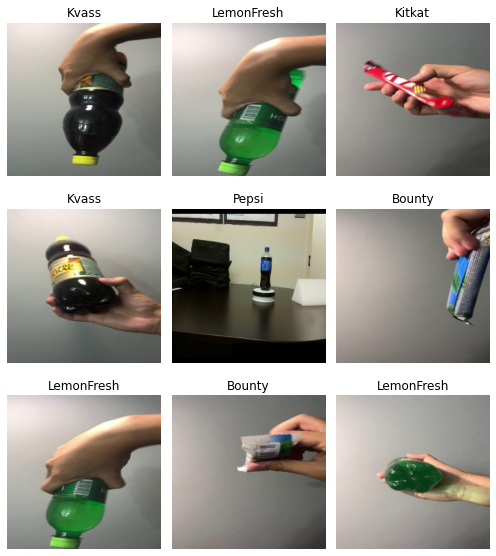

In [ ]:
data.show_batch(rows=3, figsize=(7, 8))


In [ ]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (2944 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Kvass,Kvass,Kvass,Kvass,Kvass
Path: /content;

Valid: LabelList (841 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Kvass,Kvass,Kvass,Kvass,Kvass
Path: /content;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
from fastai.callbacks import *
early_stop = EarlyStoppingCallback(learn, patience=20)
save_best_model = SaveModelCallback(learn, name='best_resnet34')

In [ ]:
#frozen training step
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(1, callbacks=[early_stop, save_best_model])

Better model found at epoch 0 with valid_loss value: 0.05713784322142601.


In [ ]:
learn.load('best_resnet34')


Learner(data=ImageDataBunch;

Train: LabelList (2944 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Kvass,Kvass,Kvass,Kvass,Kvass
Path: /content;

Valid: LabelList (841 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Kvass,Kvass,Kvass,Kvass,Kvass
Path: /content;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
learn.unfreeze()

In [ ]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)
    
    
    #loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #return the learning rate that produces the minimum loss divide by 10   
    return lrs[min_loss_index] / 10

In [ ]:
optimal_lr = find_appropriate_lr(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
learn.fit_one_cycle(1, max_lr=slice(optimal_lr/10, optimal_lr), callbacks=[early_stop, save_best_model])


Better model found at epoch 0 with valid_loss value: 0.021461166441440582.


In [ ]:
learn.load('best_resnet34')


Learner(data=ImageDataBunch;

Train: LabelList (2944 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Kvass,Kvass,Kvass,Kvass,Kvass
Path: /content;

Valid: LabelList (841 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Kvass,Kvass,Kvass,Kvass,Kvass
Path: /content;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

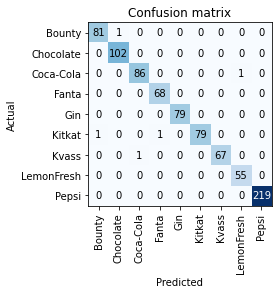

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

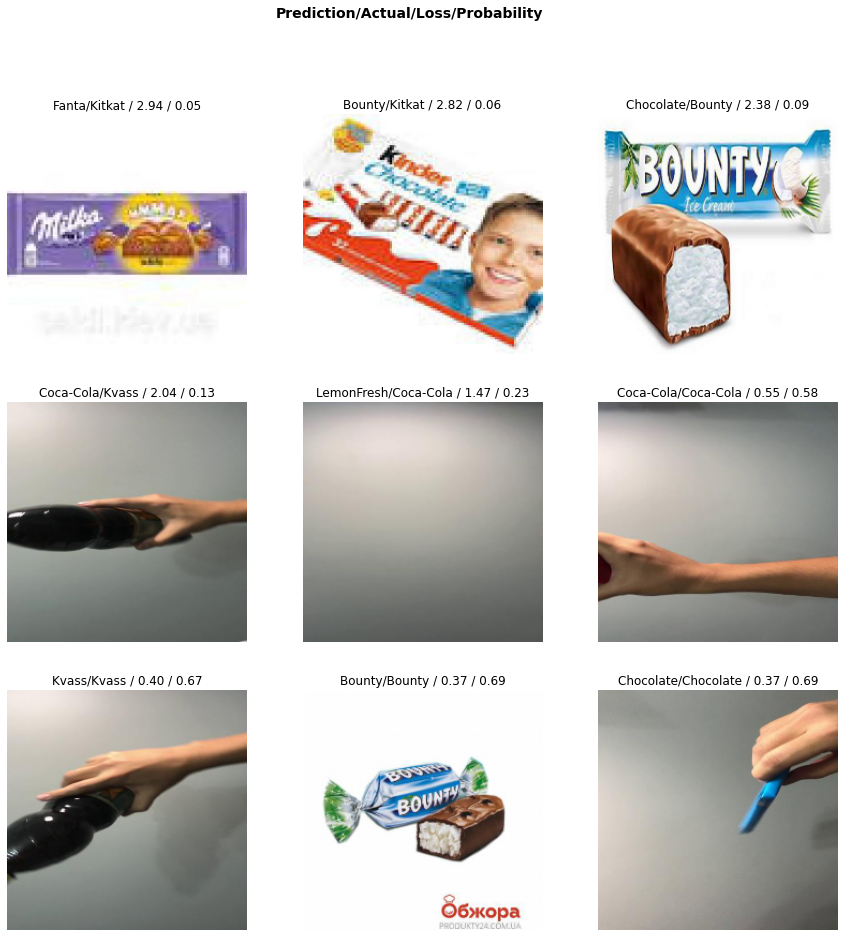

In [ ]:
interp.plot_top_losses(9, figsize=(15,15))


/content/test/Kvass/IMG_5356_083_jpg.rf.f31d3f58eefa464a334096f8eb98bb9d.jpg
Kvass


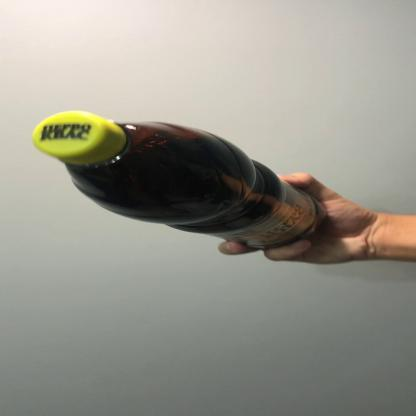



/content/test/Kvass/IMG_5356_077_jpg.rf.3f7cc740bf7ec837aac5a5d8736f6478.jpg
Kvass


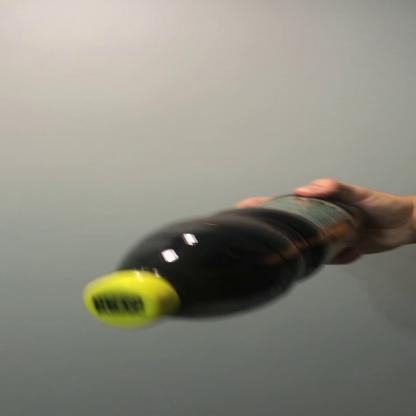



/content/test/Kvass/IMG_5356_144_jpg.rf.db782c2d33038553d11fe46c6e2f7b1e.jpg
Kvass


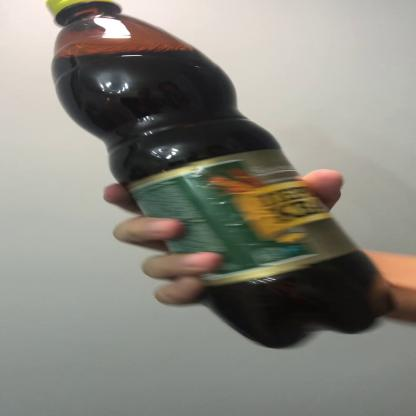



/content/test/Kvass/IMG_5356_081_jpg.rf.4d6731a1ce6b2289f49131c8c59c4866.jpg
Kvass


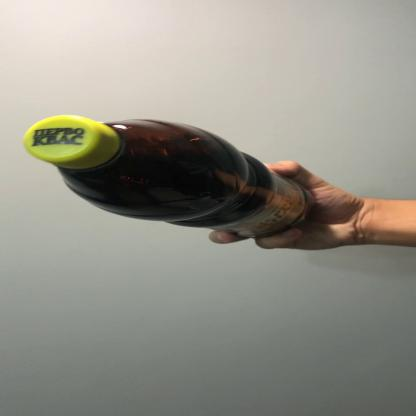



/content/test/Kvass/IMG_5356_169_jpg.rf.2ca081b73780702f570797b7b5b95fa4.jpg
Kvass


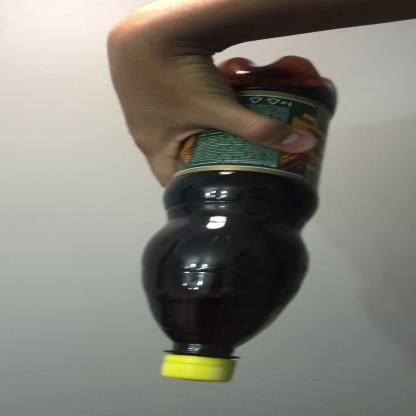



/content/test/Kvass/IMG_5356_089_jpg.rf.1e37dff51b33c4d7d543074b4a008e2e.jpg
Kvass


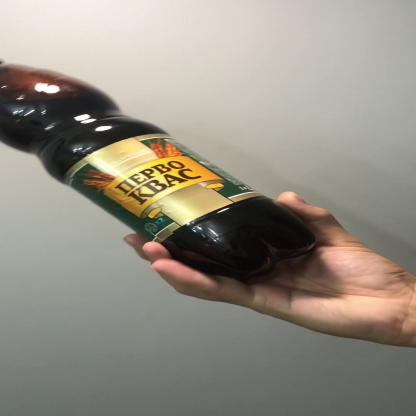



/content/test/Kvass/IMG_5356_001_jpg.rf.20ab006e9b47f38ad6593e11ec73b3ac.jpg
Kvass


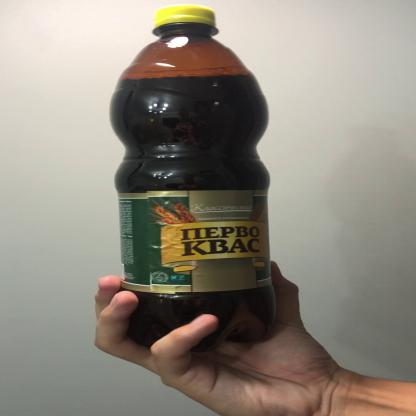



/content/test/Kvass/IMG_5356_071_jpg.rf.71140607855c0973e90a989cdc2d6630.jpg
Kvass


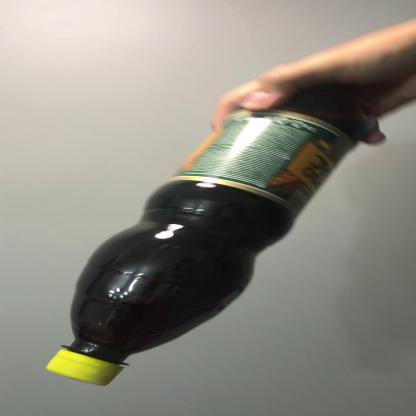



/content/test/Kvass/IMG_5356_278_jpg.rf.c9d0fda128bcdb6b92bb33994a7d917f.jpg
Kvass


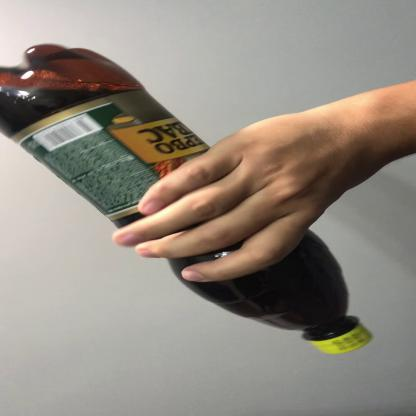



/content/test/Kvass/IMG_5356_109_jpg.rf.1431a9251d2ae5923f1fa14c85764525.jpg
Kvass


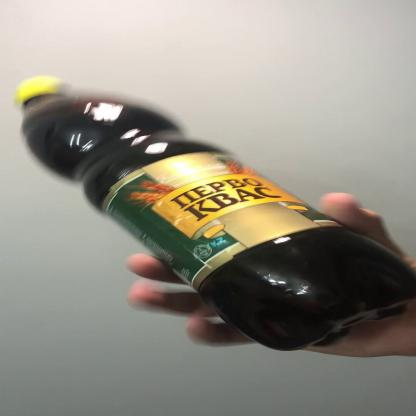



/content/test/Kvass/IMG_5356_262_jpg.rf.fad710702a034104c1bcc97c845f8c7d.jpg
Kvass


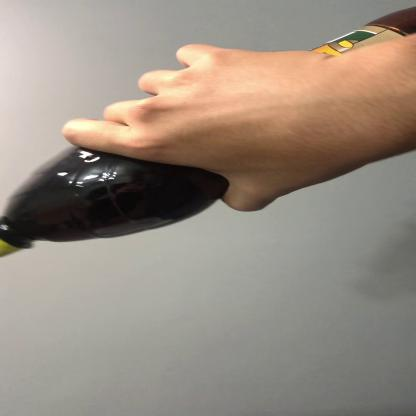



/content/test/Kvass/IMG_5356_111_jpg.rf.407f9196f4afaf672e8c29e205a8c1c9.jpg
Kvass


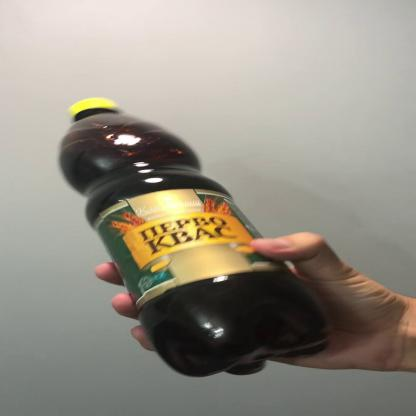



/content/test/Kvass/IMG_5356_122_jpg.rf.e7b18d0f258011a4fbdcf51d15369201.jpg
Kvass


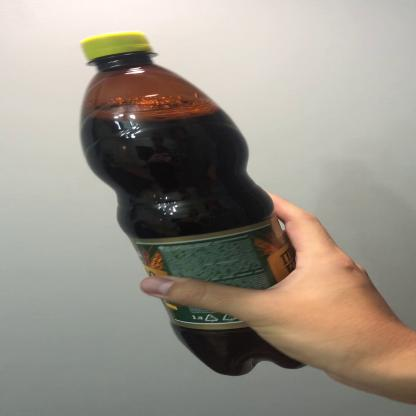



/content/test/Kvass/IMG_5356_095_jpg.rf.45f19c8fdd551aec44172d2358fd7be9.jpg
Kvass


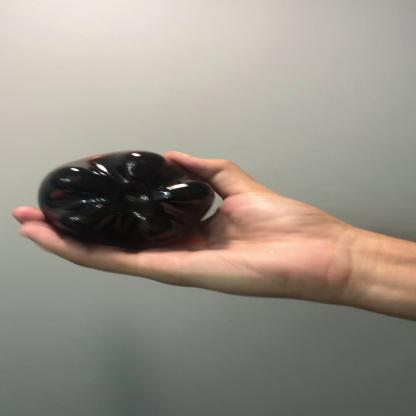



/content/test/Kvass/IMG_5356_002_jpg.rf.2238b4ac68de66c58f9c6dca1af7f981.jpg
Kvass


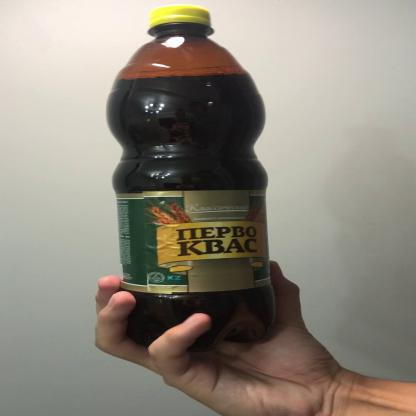



/content/test/Kvass/IMG_5356_295_jpg.rf.224b33ca153e3aeaa4d05f925871deb0.jpg
Kvass


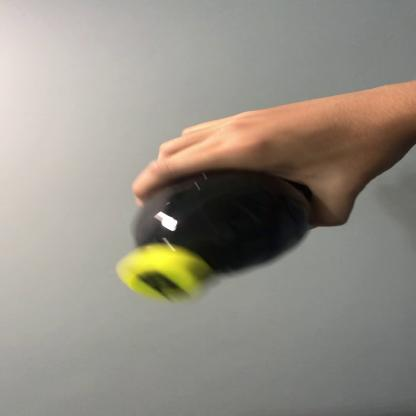



/content/test/Kvass/IMG_5356_161_jpg.rf.903ce9f884876e4e64fd15b65e8ae96a.jpg
Kvass


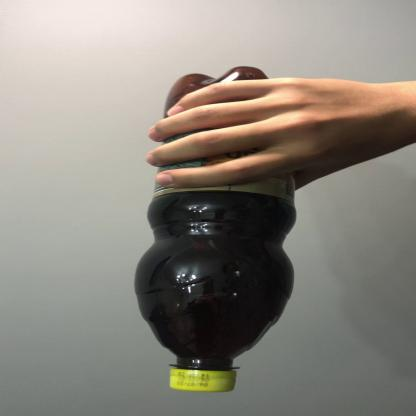



/content/test/Kvass/IMG_5356_177_jpg.rf.0445c962afabe5d0c69e5257b232687b.jpg
Kvass


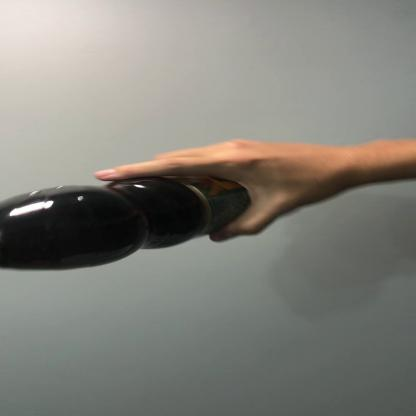



/content/test/Kvass/IMG_5356_080_jpg.rf.8e99d583af012ac254daf599c2f038f3.jpg
Kvass


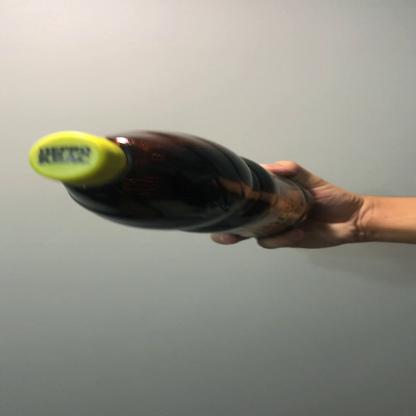



/content/test/Kvass/IMG_5356_280_jpg.rf.368e73218976be19170d3ab927075009.jpg
Kvass


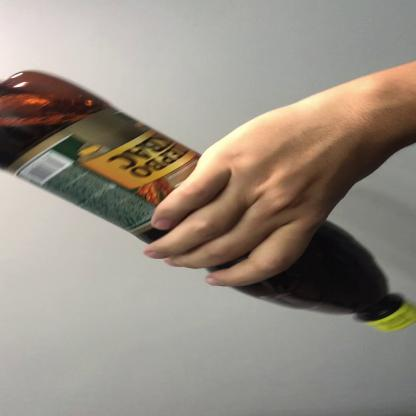



/content/test/Kvass/IMG_5356_106_jpg.rf.b45bc2b1182cb0bf784cee2fc147565c.jpg
Kvass


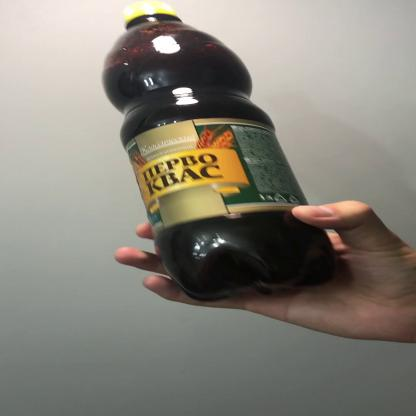



/content/test/Kvass/IMG_5356_190_jpg.rf.83c9c8ef9d47b563ec3e7b974c9e8577.jpg
Kvass


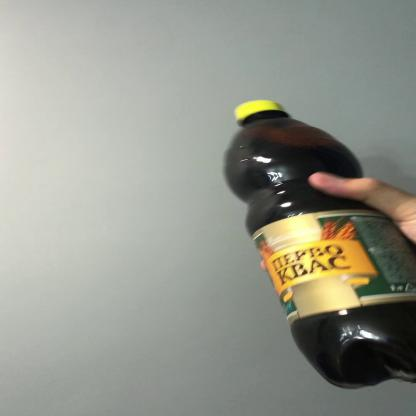



/content/test/Kvass/IMG_5356_221_jpg.rf.1b652f8ca529ee5e45d9db0a39b078c9.jpg
Kvass


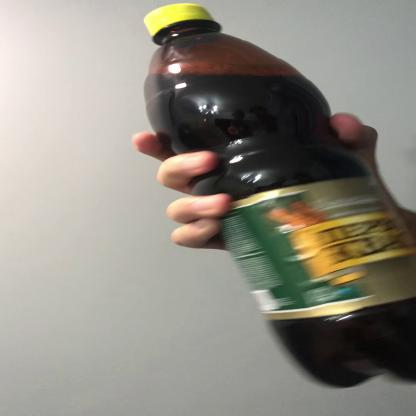



/content/test/Kvass/IMG_5356_191_jpg.rf.db3f96b3a120fdc95db2094cbc0a4225.jpg
Kvass


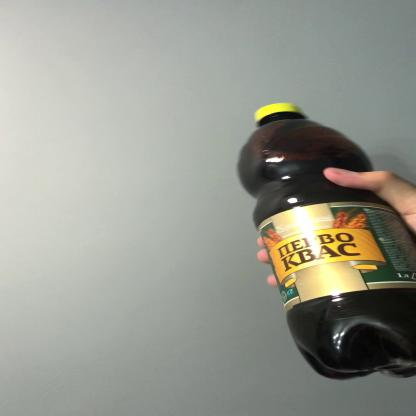



/content/test/Kvass/IMG_5356_019_jpg.rf.681b10f4f262ce625f928a26ca05a2c4.jpg
Kvass


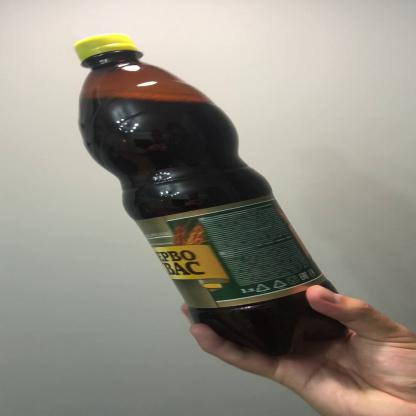



/content/test/Kvass/IMG_5356_143_jpg.rf.1d1c0b3abc30acc42d15a98049f96e59.jpg
Kvass


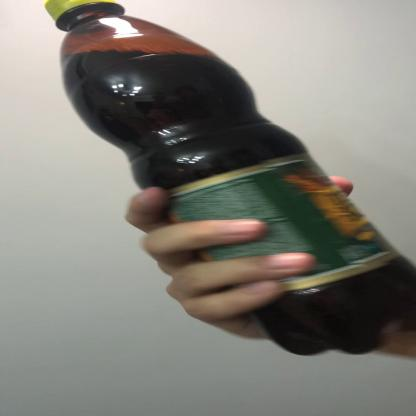



/content/test/Kvass/IMG_5356_117_jpg.rf.7d435933d54ad9a6200d7b3ca1f4dc7d.jpg
Kvass


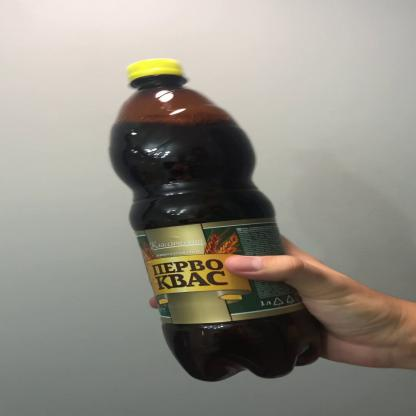



/content/test/Kvass/IMG_5356_113_jpg.rf.e1fe091e3b7454692d29e250f71f7d0d.jpg
Kvass


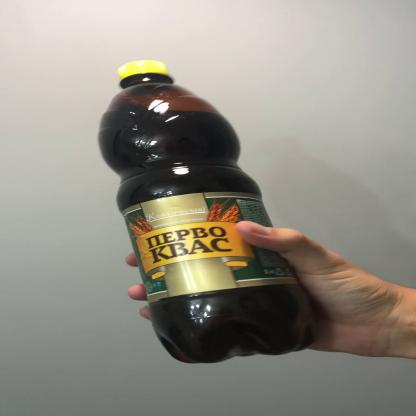



/content/test/Kvass/IMG_5356_004_jpg.rf.a001e7f81968ba4f82085e57e0fab3eb.jpg
Kvass


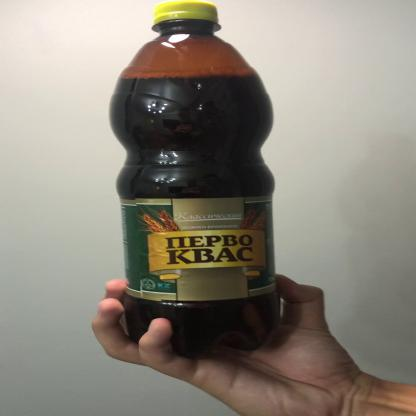



/content/test/Kvass/IMG_5356_277_jpg.rf.9467eb1ed2c513c1714a5cc7deab2598.jpg
Kvass


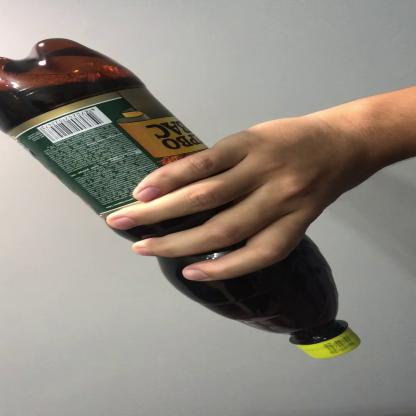



/content/test/Kvass/IMG_5356_087_jpg.rf.221dae8fff9034a3006c4b7af6759cf4.jpg
Kvass


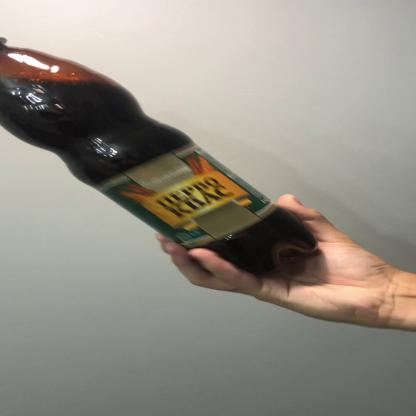



/content/test/Kvass/IMG_5356_251_jpg.rf.7cd8e09f9e9cd6b0893f0199b9ddb083.jpg
Kvass


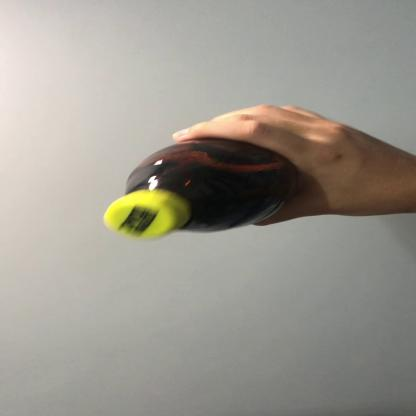



/content/test/Kvass/IMG_5356_257_jpg.rf.336c782b53fd846de0cd682f56b4df7e.jpg
Kvass


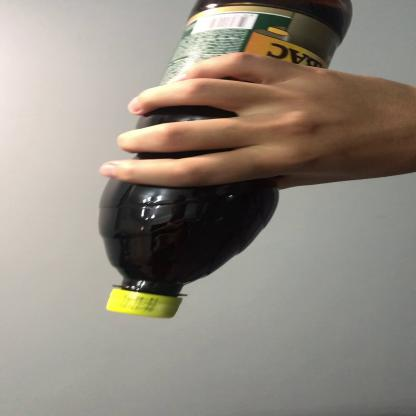



/content/test/Fanta/IMG_5350_166_jpg.rf.61d0f6e26229460326b8ade0542adf43.jpg
Fanta


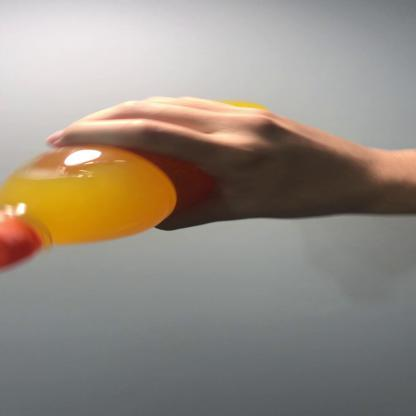



/content/test/Fanta/images (71)_jpeg.rf.259ec21c7914e15c903314073289bc86.jpg
Fanta


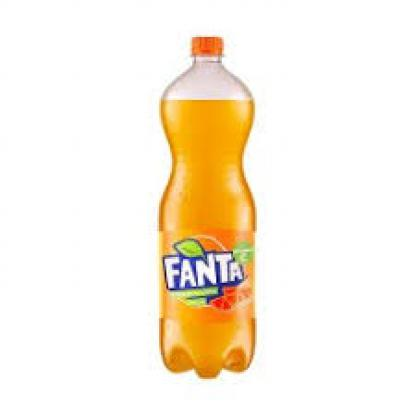



/content/test/Fanta/IMG_5350_152_jpg.rf.6e9bdb8ca1625ac1b8a93fbfbc600b29.jpg
Fanta


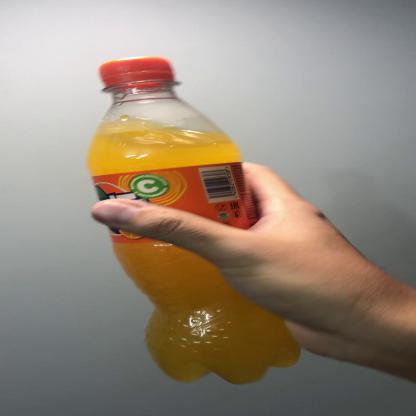



/content/test/Fanta/IMG_5350_262_jpg.rf.33b1db99de5fc848ad83769b1bd082f4.jpg
Fanta


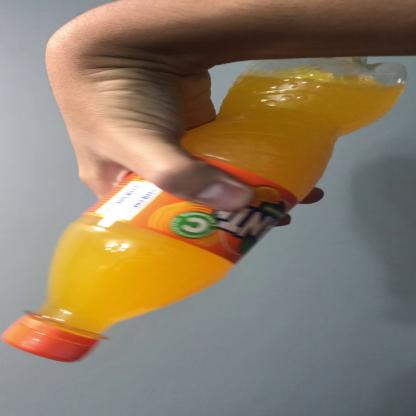



/content/test/Fanta/images (39)_jpeg.rf.f4d3ff756fadc27be48c1eea61c4cdc7.jpg
Fanta


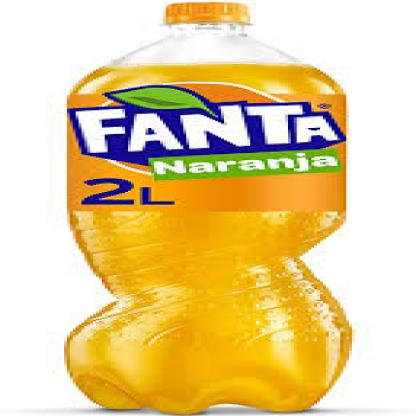



/content/test/Fanta/IMG_5350_251_jpg.rf.5d0a361b5403c4dbf53d9e45aefebac5.jpg
Fanta


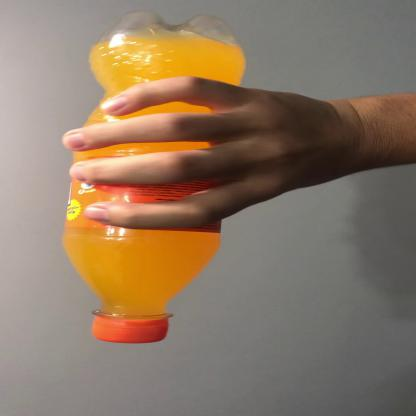



/content/test/Fanta/IMG_5350_230_jpg.rf.01038de27915529d27597b7ee08a13ab.jpg
Fanta


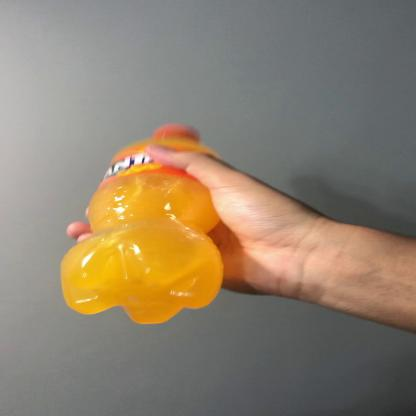



/content/test/Fanta/IMG_5350_145_jpg.rf.6794c6acdc5dd5394e4df26100901c2b.jpg
Fanta


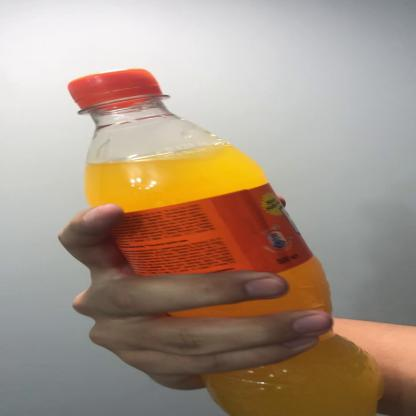



/content/test/Fanta/images (6)_jpeg.rf.7c8c97c79d56f90644887fe05f8d9b8a.jpg
Fanta


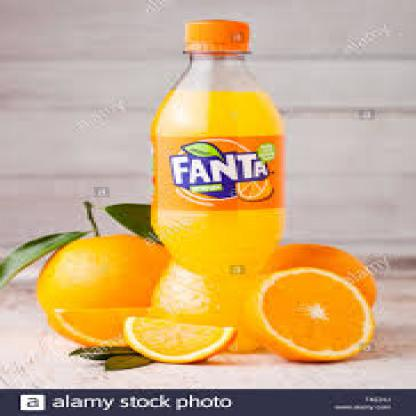



/content/test/Fanta/IMG_5350_000_jpg.rf.ba5aa2ad278fe8e613c97bdab9a0e92a.jpg
Fanta


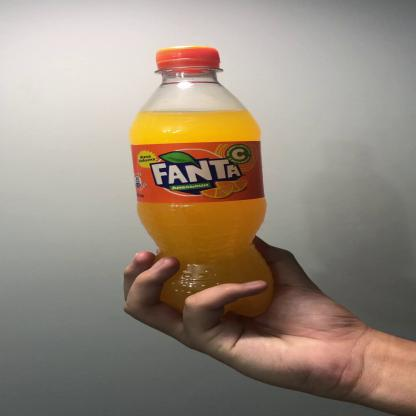



/content/test/Fanta/IMG_5350_223_jpg.rf.fceddcb6a84c631b9086dfe10550e358.jpg
Fanta


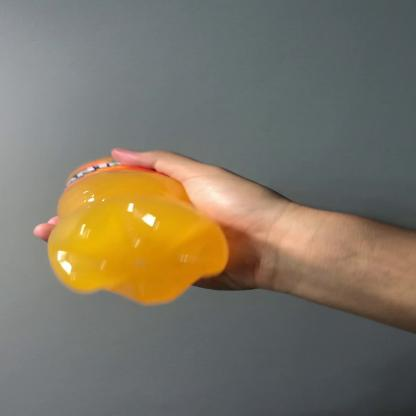



/content/test/Fanta/IMG_5350_291_jpg.rf.b9faa029433783529fc7ed58c3fdb285.jpg
Fanta


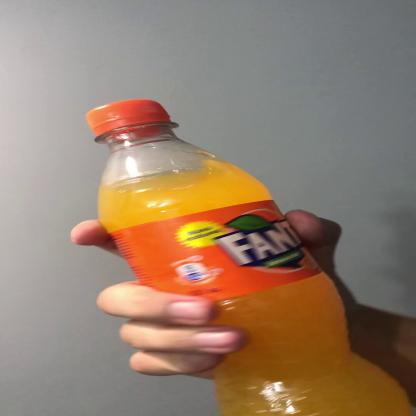



/content/test/Fanta/IMG_5350_214_jpg.rf.d209261070be0607a3b4232671323964.jpg
Fanta


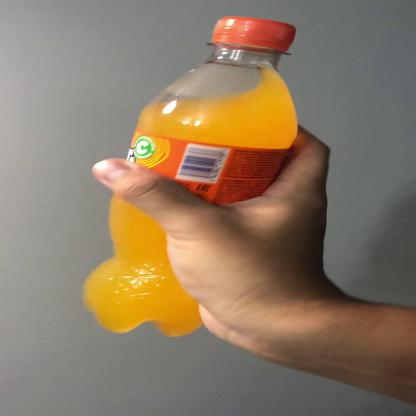



/content/test/Fanta/IMG_5350_047_jpg.rf.015f66981abafd792274ce744b8e1cfb.jpg
Fanta


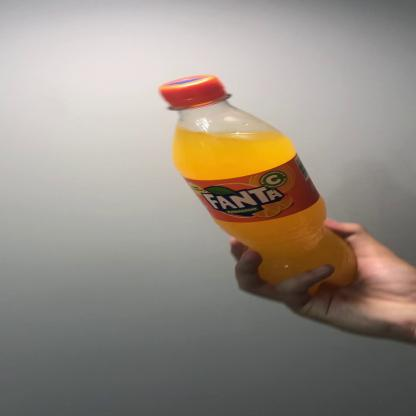



/content/test/Fanta/IMG_5350_013_jpg.rf.8ea5fc4e46b6735f7f3ebee3d1490877.jpg
Fanta


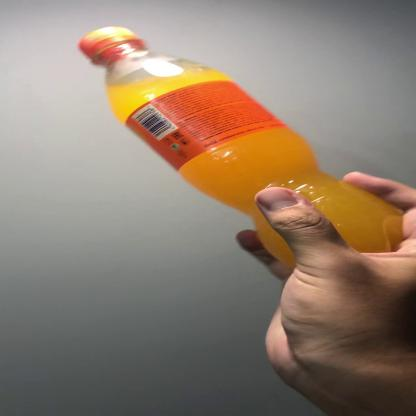



/content/test/Fanta/IMG_5350_125_jpg.rf.15bff0d298ea87d353ba5e2dacabcedc.jpg
Fanta


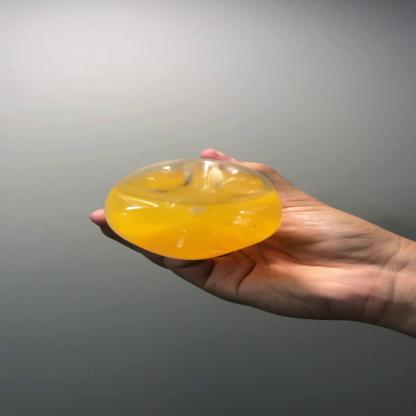



/content/test/Fanta/IMG_5350_168_jpg.rf.a94c80bf54ad85856856224311c605c3.jpg
Fanta


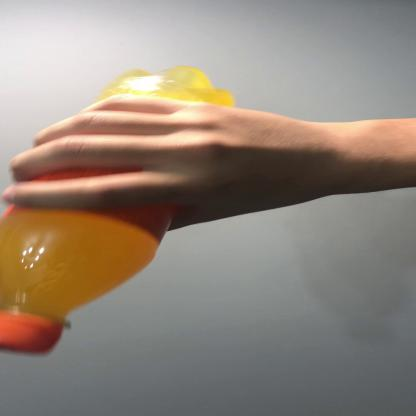



/content/test/Fanta/IMG_5350_033_jpg.rf.68a65656ad9c6489325df37912cb0027.jpg
Fanta


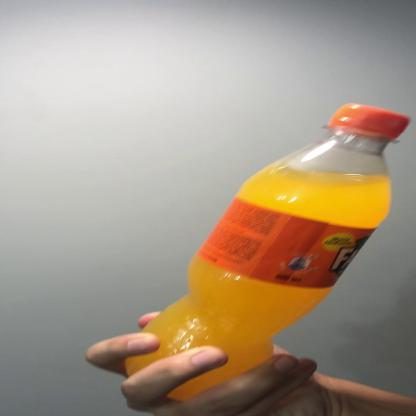



/content/test/Fanta/IMG_5350_022_jpg.rf.51d2ae60a151ae854423092db4732cf4.jpg
Fanta


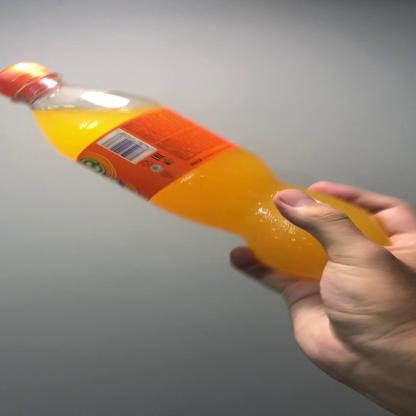



/content/test/Fanta/images (8)_jpeg.rf.c6be80ea71f92d018f61b941c9622e1d.jpg
Fanta


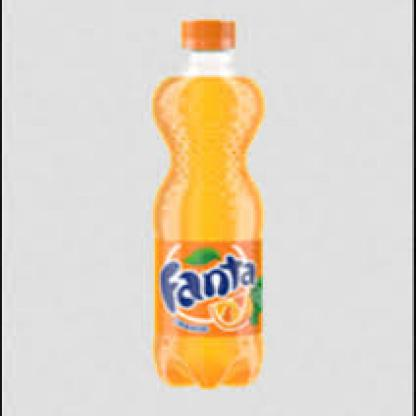



/content/test/Fanta/IMG_5350_227_jpg.rf.00284c7921c964d66b2847825010f203.jpg
Fanta


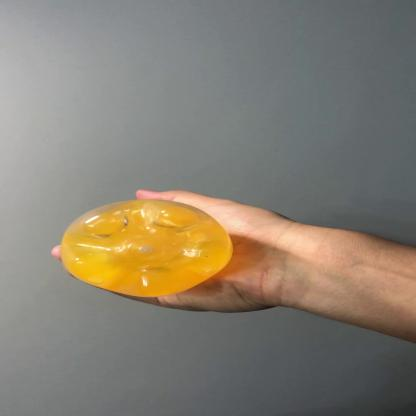



/content/test/Fanta/IMG_5350_236_jpg.rf.8c9dff5c715e9e5315ec16a494e56368.jpg
Fanta


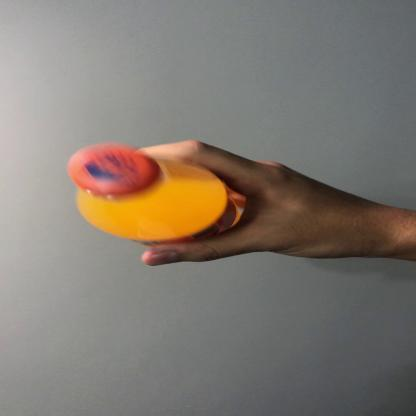



/content/test/Fanta/IMG_5350_174_jpg.rf.dfc8a0f0000c8bfd51fc19f1f0986fd2.jpg
Fanta


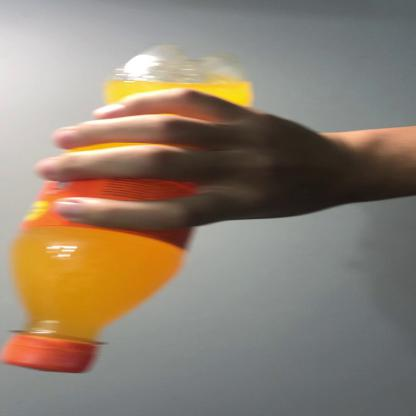



/content/test/Fanta/IMG_5350_001_jpg.rf.cb933c19b7edcd9bb0d276f49af14be1.jpg
Fanta


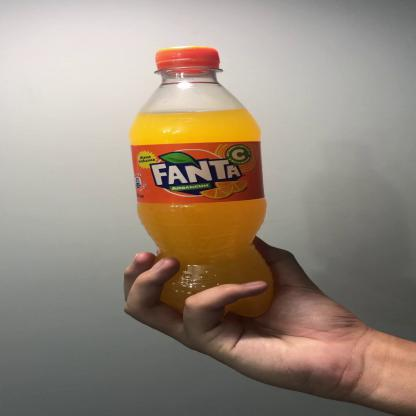



/content/test/Fanta/download (7)_jpeg.rf.4cecb76f8372aef82dcfc5118eac3de3.jpg
Fanta


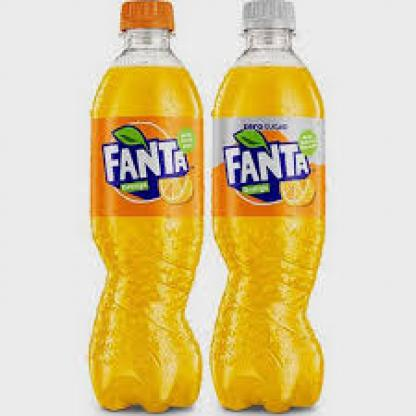



/content/test/Fanta/IMG_5350_240_jpg.rf.aedd4b56dc57bd6b8c69a3644476751a.jpg
Fanta


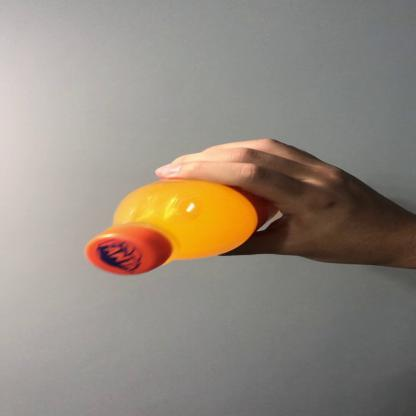



/content/test/Fanta/images (1)_png.rf.a9b879b86539e8e03aeba2923933d6f6.jpg
Fanta


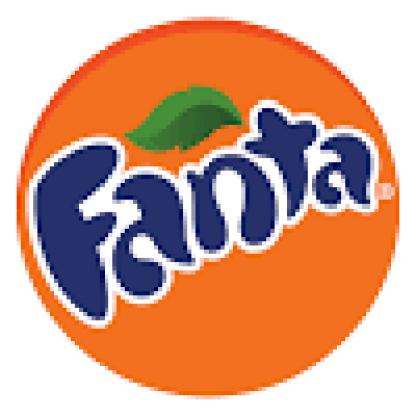



/content/test/Fanta/images (54)_jpeg.rf.5fc64cfc2b0122a9982adb5b27be3d3b.jpg
Fanta


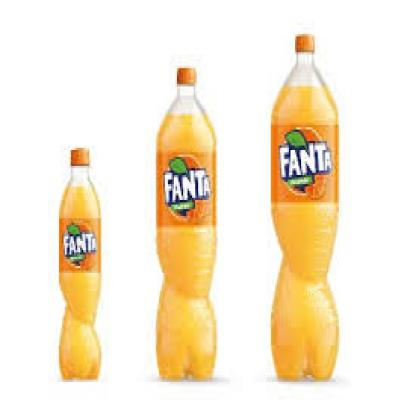



/content/test/Fanta/IMG_5350_068_jpg.rf.1f1b07f029fab1f1466b3ef69ab5ca5d.jpg
Fanta


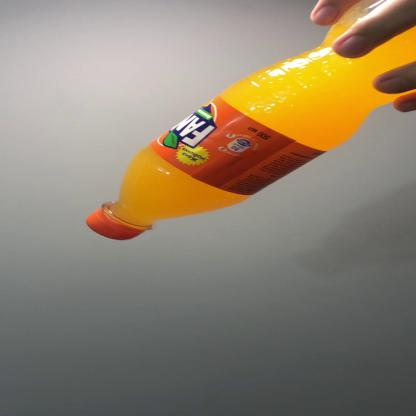



/content/test/Fanta/IMG_5350_272_jpg.rf.2c0d55a34298cfbbe307153c65bc73dd.jpg
Fanta


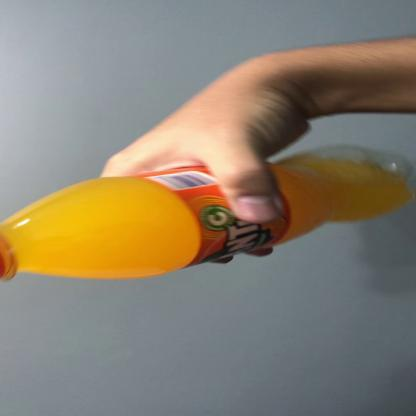



/content/test/Fanta/download (12)_jpeg.rf.6624d8ece7b2a4e716436a47988b4d3a.jpg
Fanta


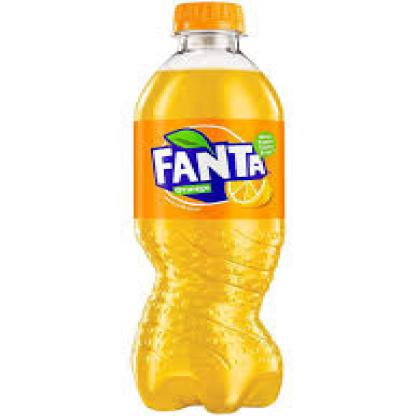



/content/test/Fanta/IMG_5350_225_jpg.rf.219667a7a0b474093a67392f4b07f6ff.jpg
Fanta


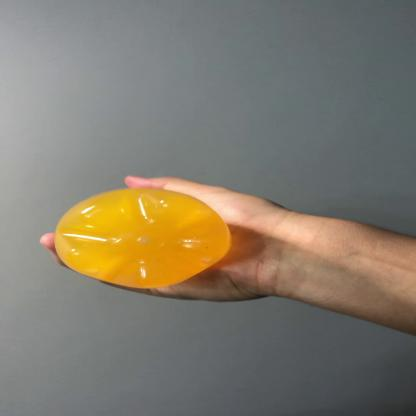



/content/test/Fanta/IMG_5350_180_jpg.rf.4e58a3f474bf323b89734182e78d9a85.jpg
Fanta


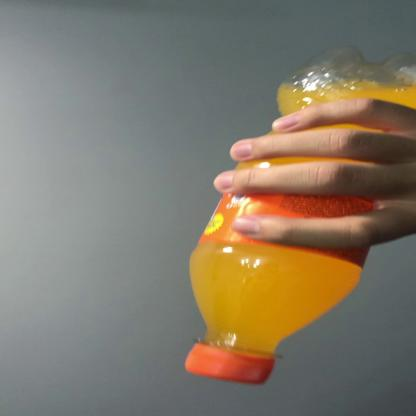



/content/test/Fanta/IMG_5350_002_jpg.rf.d2f1924435a0e5ef0284c6cb10b411e7.jpg
Fanta


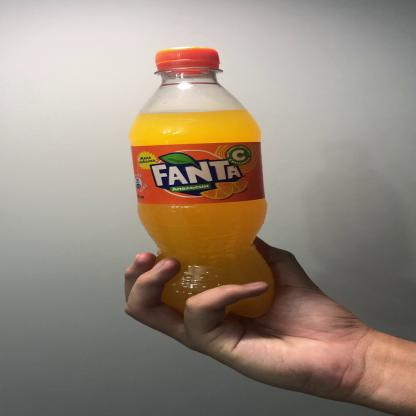



/content/test/Fanta/IMG_5350_098_jpg.rf.3dfe70fa474c870d43aa88f0dda5a68a.jpg
Fanta


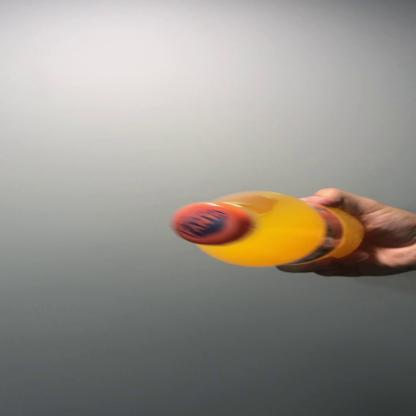



/content/test/Fanta/IMG_5350_109_jpg.rf.ece957af3f3541bb37ae4fc2c927cc1b.jpg
Fanta


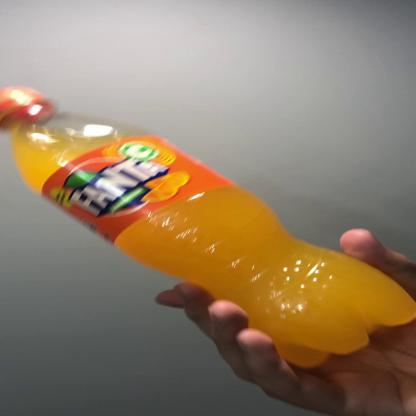



/content/test/Fanta/IMG_5350_092_jpg.rf.a6c72a1c177de851ee84e6c428632e0b.jpg
Fanta


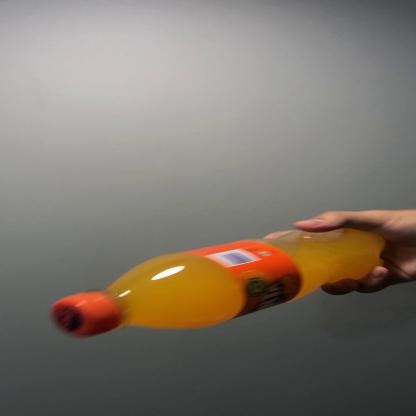



/content/test/Fanta/IMG_5350_194_jpg.rf.55e25813cfad6f4d82bfacdfbc631795.jpg
Fanta


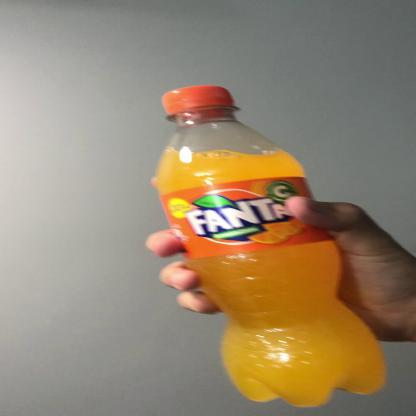



/content/test/Fanta/IMG_5350_113_jpg.rf.bb2ac69ba4cf9ee33b9eb79b99117659.jpg
Fanta


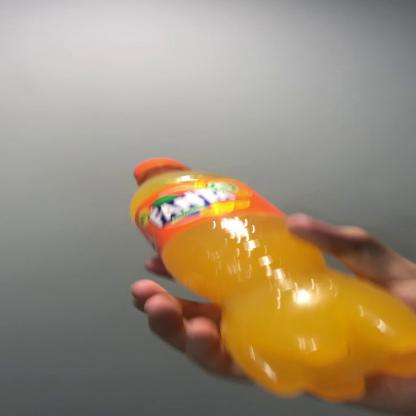



/content/test/Fanta/IMG_5350_248_jpg.rf.6b11590e1e530c088c89877c5aed053a.jpg
Fanta


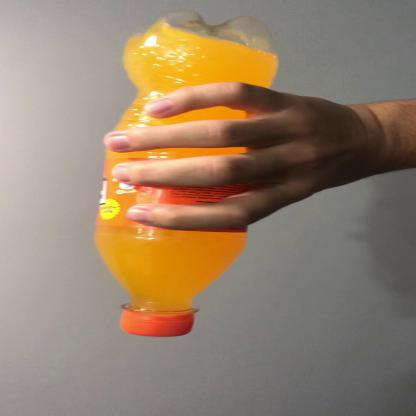



/content/test/Fanta/IMG_5350_260_jpg.rf.d0f8e9ed494e0aca3a93307f26fd11a2.jpg
Fanta


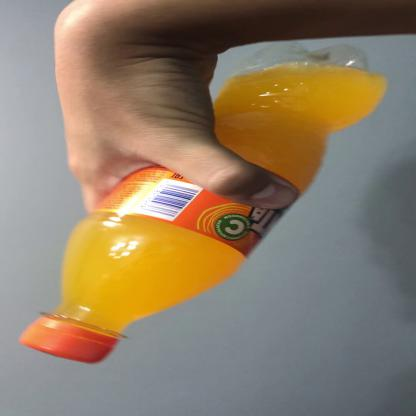



/content/test/Fanta/IMG_5350_188_jpg.rf.d1194c19c59e56fe04ed7c22326e7d5c.jpg
Fanta


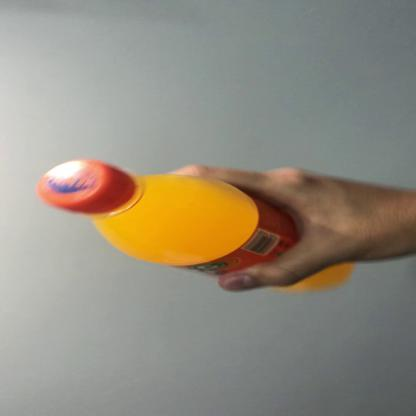



/content/test/Fanta/IMG_5350_204_jpg.rf.2c03ee9ddf1a97f770bd65d77cb26e72.jpg
Fanta


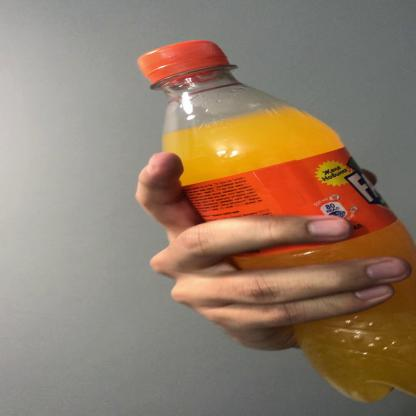



/content/test/Fanta/IMG_5350_179_jpg.rf.fd280e2b80a91d7eaa641075e71f1f22.jpg
Fanta


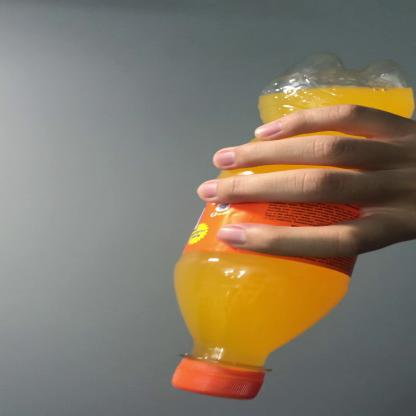



/content/test/Fanta/IMG_5350_038_jpg.rf.d18481a6138ccd289e8270f7fcd77874.jpg
Fanta


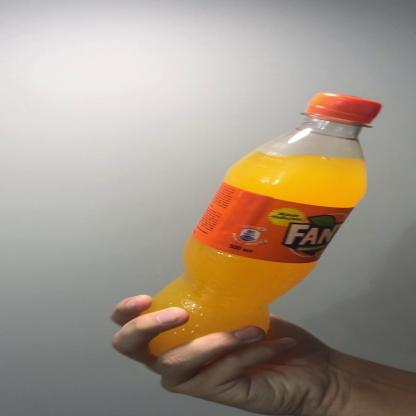



/content/test/Fanta/IMG_5350_140_jpg.rf.a0602dfa44c14a52e7f6855573cb2e3c.jpg
Fanta


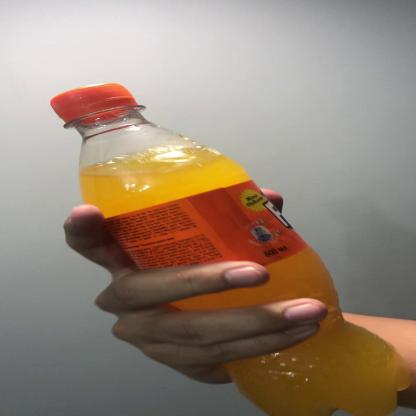



/content/test/Coca-Cola/IMG_5346_058_jpg.rf.3063ed44713ee8764654989418ea8e23.jpg
Coca-Cola


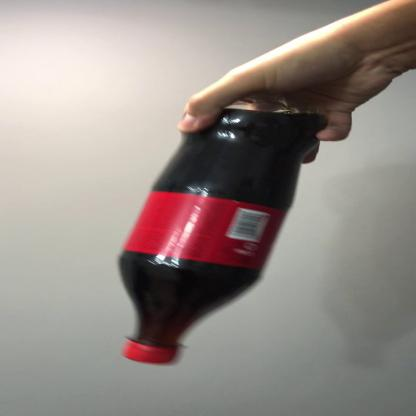



/content/test/Coca-Cola/IMG_5346_112_jpg.rf.96cf732695611650c653038003310973.jpg
Coca-Cola


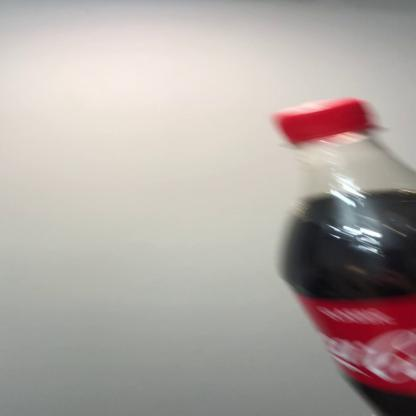



/content/test/Coca-Cola/IMG_5346_136_jpg.rf.d56f700736fce87692a345a6f9e51e1b.jpg
Coca-Cola


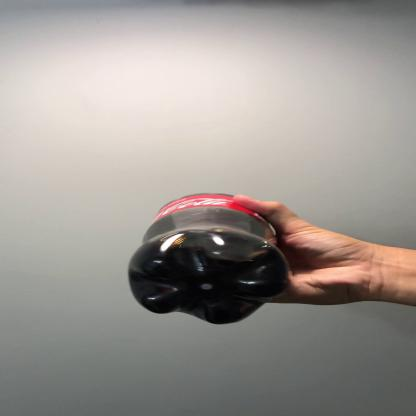



/content/test/Coca-Cola/IMG_5346_245_jpg.rf.5e18435523c4a3c3cb7fcf78414617e1.jpg
Coca-Cola


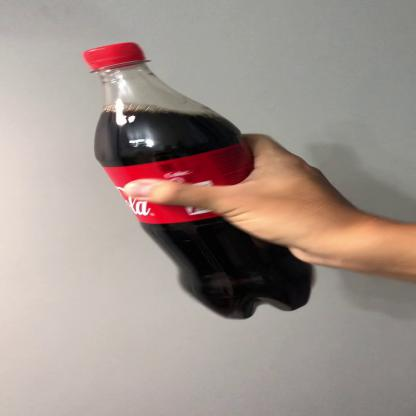



/content/test/Coca-Cola/IMG_5346_151_jpg.rf.ff8e48a919a5dd817024c312202e645c.jpg
Coca-Cola


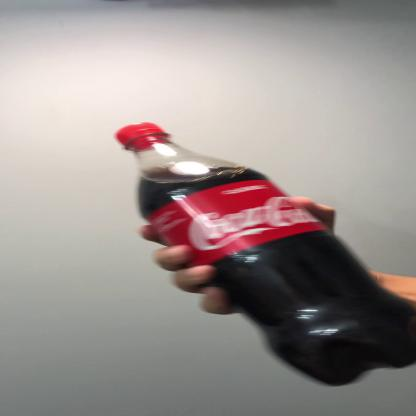



/content/test/Coca-Cola/IMG_5346_094_jpg.rf.48f2036b0865d361e045a404bcb5176e.jpg
Coca-Cola


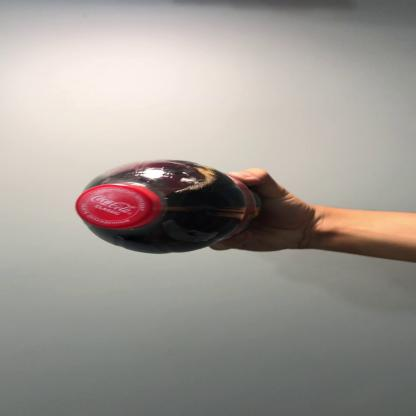



/content/test/Coca-Cola/IMG_5346_258_jpg.rf.f5700cf8bf65b0d0247af106661abca7.jpg
Coca-Cola


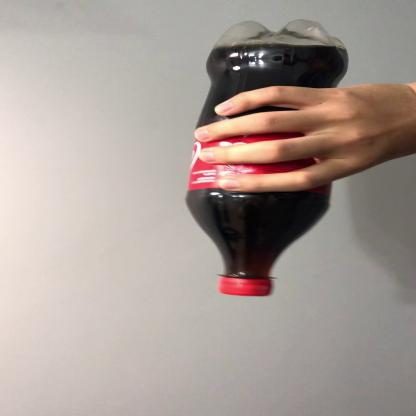



/content/test/Coca-Cola/images (56)_jpeg.rf.046a62a95726ee867ad31f3944e51a9d.jpg
Coca-Cola


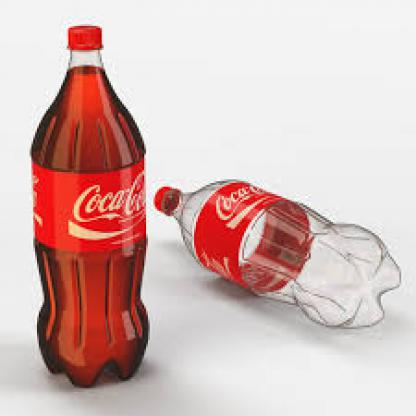



/content/test/Coca-Cola/IMG_5346_056_jpg.rf.bb9be6d9a9a68f48ee3e1919fbbc4a41.jpg
Coca-Cola


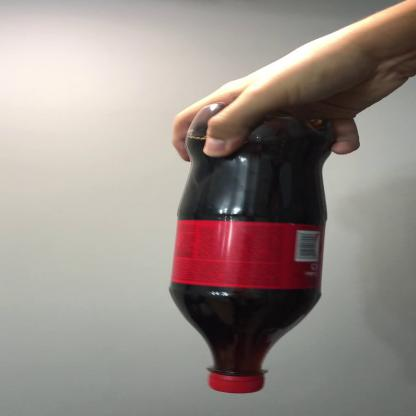



/content/test/Coca-Cola/IMG_5346_185_jpg.rf.77a98bbaff297db433ab6a1edac203f5.jpg
Coca-Cola


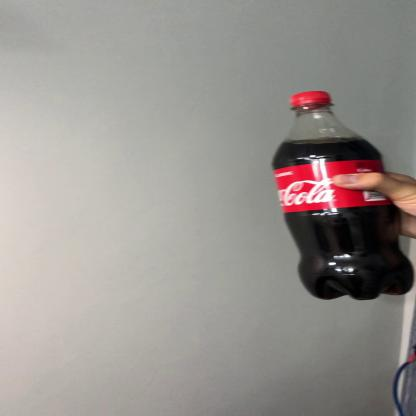



/content/test/Coca-Cola/IMG_5346_224_jpg.rf.f307d3b007a521977abed070422735c9.jpg
Coca-Cola


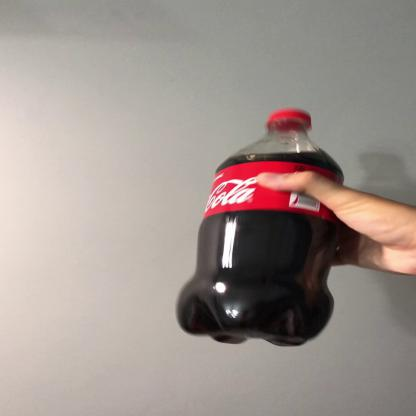



/content/test/Coca-Cola/IMG_5346_146_jpg.rf.cffdb6385446fa555a5bf5b19aa0cbe7.jpg
Coca-Cola


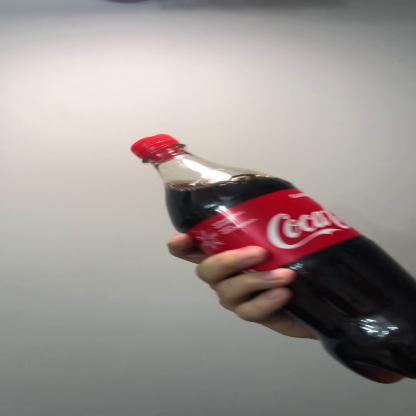



/content/test/Coca-Cola/IMG_5346_214_jpg.rf.7b8f8940385440d0410a55e12eaf047b.jpg
Coca-Cola


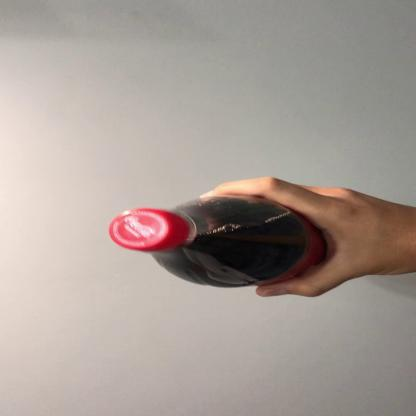



/content/test/Coca-Cola/IMG_5346_257_jpg.rf.73fc462fd2e9bcdbd888fd4831c1f7de.jpg
Coca-Cola


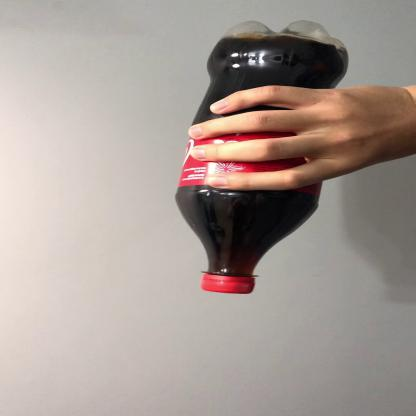



/content/test/Coca-Cola/IMG_5346_262_jpg.rf.90923d7eca21cb1dbdfdedec2f297e3c.jpg
Coca-Cola


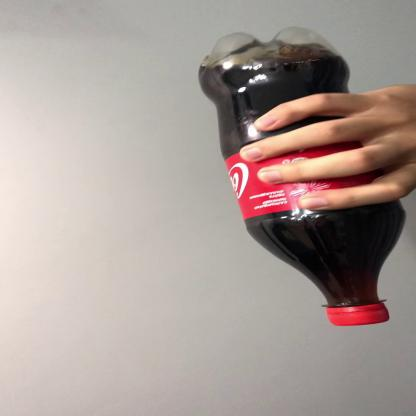



/content/test/Coca-Cola/IMG_5346_158_jpg.rf.82c3c36a2ee961d53ee58a13c84fc93d.jpg
Pepsi


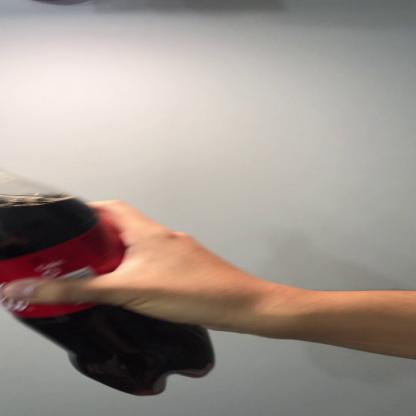



/content/test/Coca-Cola/IMG_5346_176_jpg.rf.e2fa7214ae74c6e97c8028842213b82f.jpg
Coca-Cola


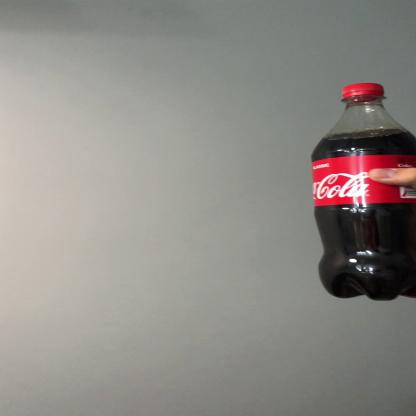



/content/test/Coca-Cola/IMG_5346_065_jpg.rf.a905959abe5765464b94f3d3f441a809.jpg
Coca-Cola


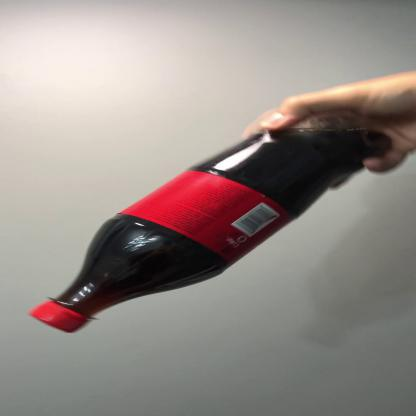



/content/test/Coca-Cola/IMG_5346_229_jpg.rf.0c69c499aed9ffdcf282fb5683467c0b.jpg
Coca-Cola


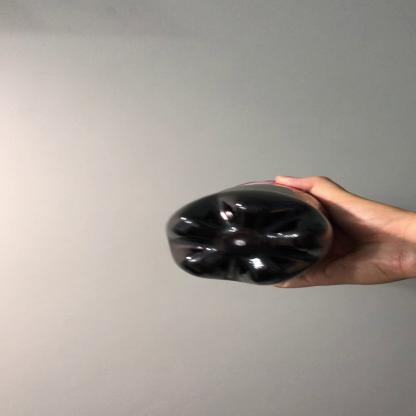



/content/test/Coca-Cola/IMG_5346_070_jpg.rf.db0699ada6c48fa8fd2ee8be95d62ba2.jpg
Coca-Cola


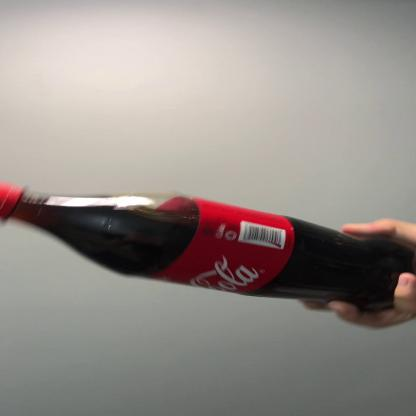



/content/test/Coca-Cola/IMG_5346_206_jpg.rf.4a290141da72dce6e21936d488a0999e.jpg
Coca-Cola


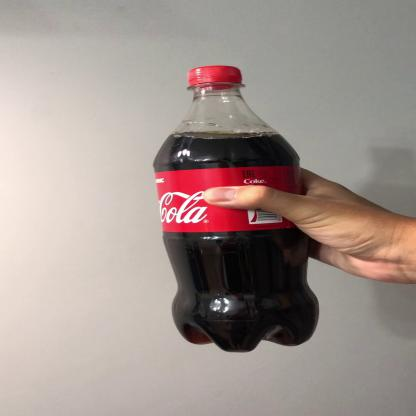



/content/test/Coca-Cola/images - 2020-11-11T181430-448_jpeg.rf.648654707a9598be77434a1b19907006.jpg
Coca-Cola


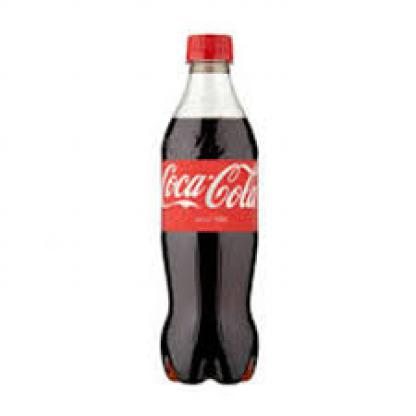



/content/test/Coca-Cola/images (79)_jpeg.rf.5aec34007b204548c749b689165a40a2.jpg
Coca-Cola


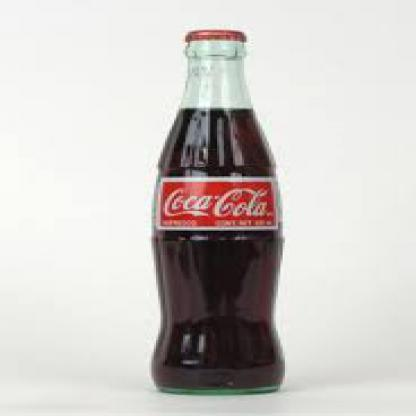



/content/test/Coca-Cola/IMG_5346_221_jpg.rf.c40eacf82b34330b6f366b3bbf0bd7c5.jpg
Coca-Cola


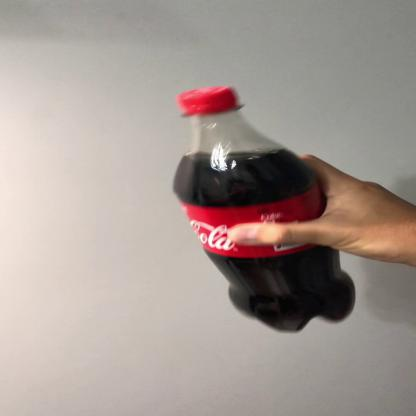



/content/test/Coca-Cola/images (34)_jpeg.rf.e97e0df1c170d7b0cfeaaa491a033a41.jpg
Coca-Cola


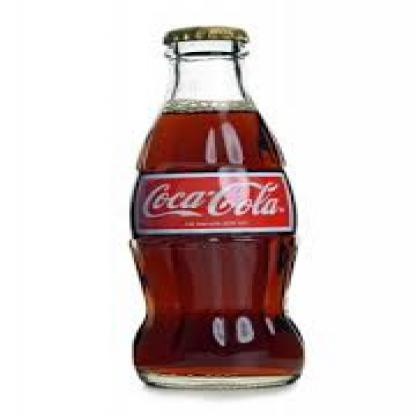



/content/test/Coca-Cola/IMG_5346_098_jpg.rf.8fd0e8ff44a52f5836692c98e4b6e86c.jpg
Coca-Cola


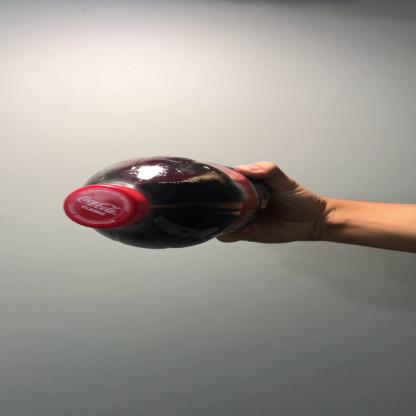



/content/test/Coca-Cola/images (96)_jpeg.rf.bcbf833f1476151b37b9d7f75d381dbb.jpg
Coca-Cola


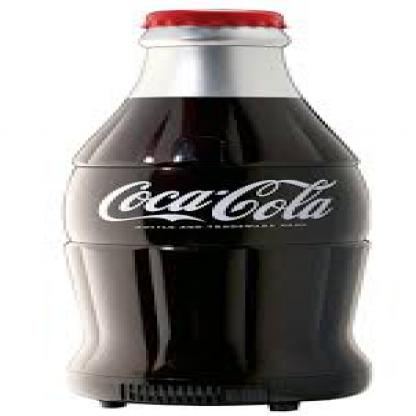



/content/test/Coca-Cola/IMG_5346_060_jpg.rf.35e963724574b2d1c1f922ee217f9db7.jpg
Coca-Cola


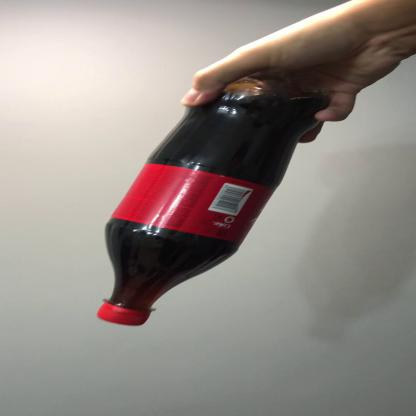



/content/test/Coca-Cola/IMG_5346_142_jpg.rf.040d7b333bd811e2312c3ae47b4e3ca0.jpg
Coca-Cola


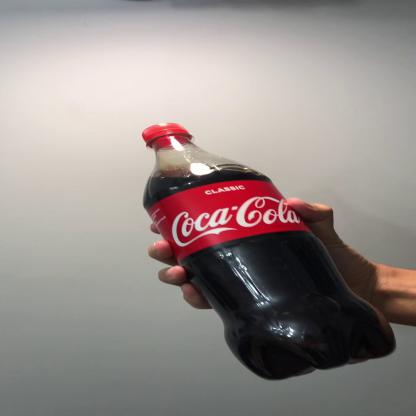



/content/test/Coca-Cola/images (88)_jpeg.rf.137087624d1def05f5b759ce30152e57.jpg
Coca-Cola


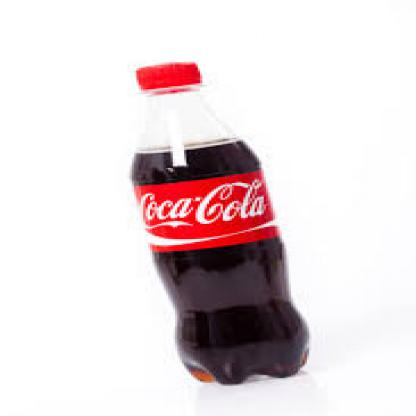



/content/test/Coca-Cola/IMG_5346_012_jpg.rf.c2e365208a11e7cdebe368f6a6b5d668.jpg
Coca-Cola


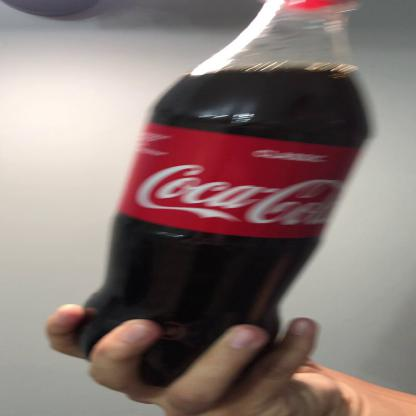



/content/test/Coca-Cola/images_jpeg.rf.15b0b25d21ba6f59135b5c9f55230e8a.jpg
Coca-Cola


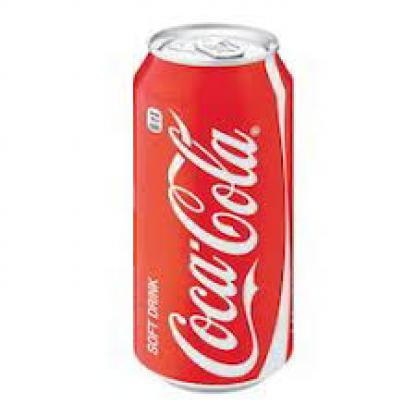



/content/test/Coca-Cola/IMG_5346_081_jpg.rf.70e89af62dbd826c4fcae0ec5b86e69b.jpg
Coca-Cola


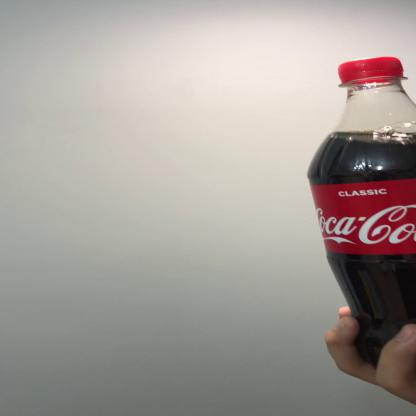



/content/test/Coca-Cola/images - 2020-11-11T181430-398_jpeg.rf.cc67b113a57b856b0a52493b5a0f60cc.jpg
Coca-Cola


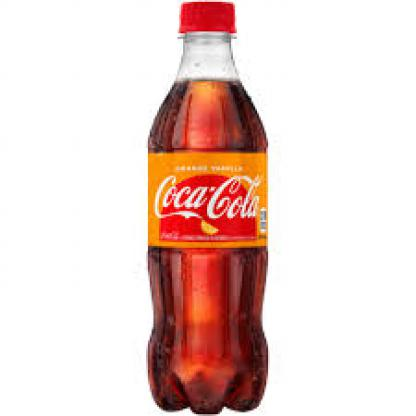



/content/test/Coca-Cola/IMG_5346_249_jpg.rf.ee91ef5daee9983a48799ab12a79c8b5.jpg
Coca-Cola


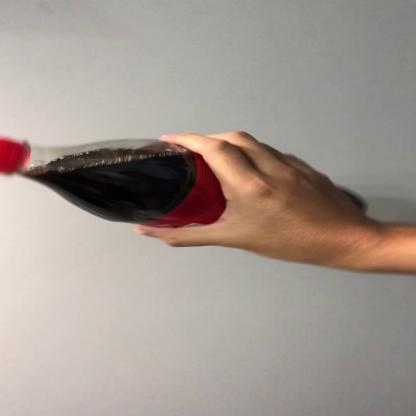



/content/test/Coca-Cola/images (45)_jpeg.rf.4beea52f5381f3e69554e2a1999c5dd5.jpg
Coca-Cola


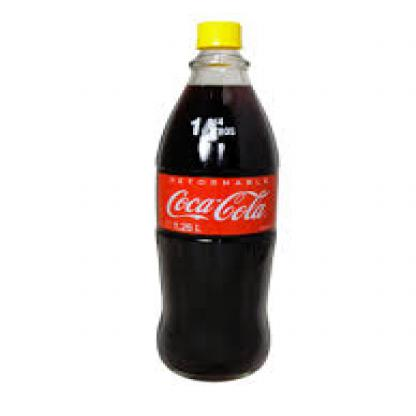



/content/test/Coca-Cola/download (5)_jpeg.rf.d35a444e06dd43f62d767415f3fefa99.jpg
Coca-Cola


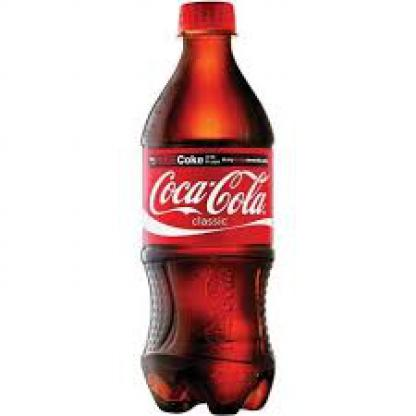



/content/test/Coca-Cola/IMG_5346_091_jpg.rf.1c3ff29f0e63157fcb4570b4dede7341.jpg
Coca-Cola


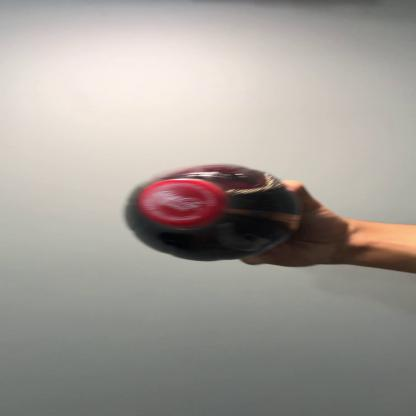



/content/test/Coca-Cola/IMG_5346_082_jpg.rf.2c59b0f4633b77a9f0e3963afeb19fa3.jpg
Coca-Cola


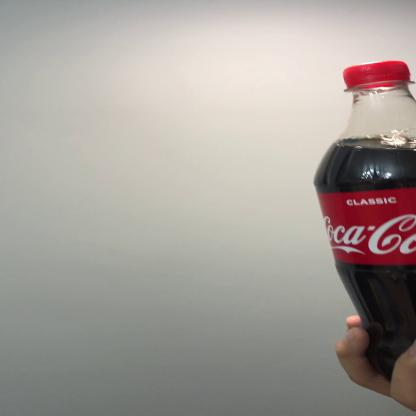



/content/test/Coca-Cola/download (9)_jpeg.rf.2b386e913ec771e19a364c41a8b4d51c.jpg
Coca-Cola


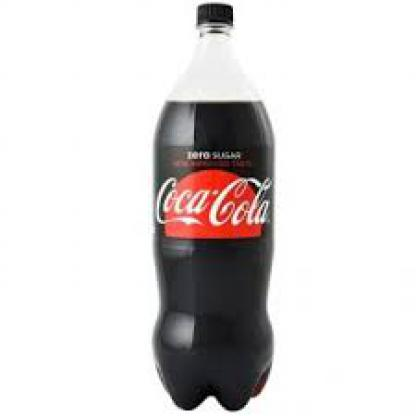



/content/test/Coca-Cola/IMG_5346_226_jpg.rf.887cff93955804f46f5eb8edf1fb18aa.jpg
Coca-Cola


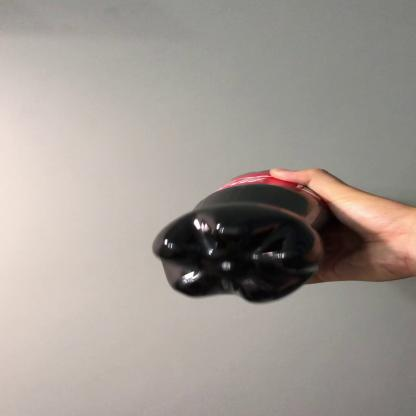



/content/test/Coca-Cola/IMG_5346_270_jpg.rf.07c8614c229b960ffedd986894e3ea8e.jpg
Coca-Cola


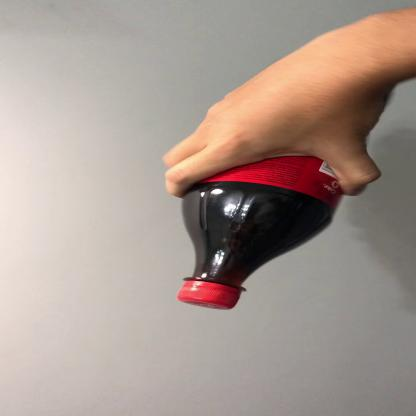



/content/test/Coca-Cola/images (62)_jpeg.rf.4bab3f03d37017828ae989de8b83ab81.jpg
Coca-Cola


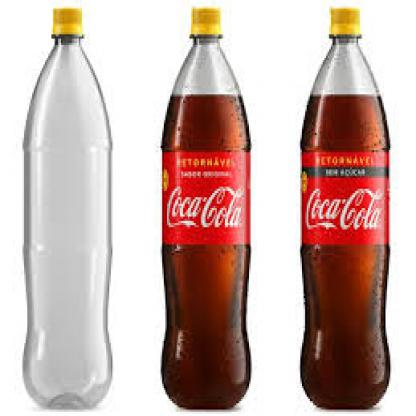



/content/test/Coca-Cola/IMG_5346_253_jpg.rf.5ee5d3632e80669d4596b7290e5a0485.jpg
Coca-Cola


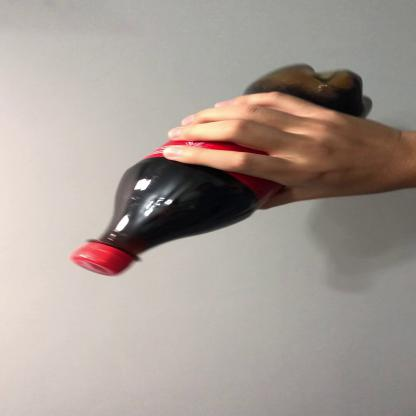



/content/test/Coca-Cola/IMG_5346_100_jpg.rf.a986ca08f6d738ef10ccf7a85be12967.jpg
Coca-Cola


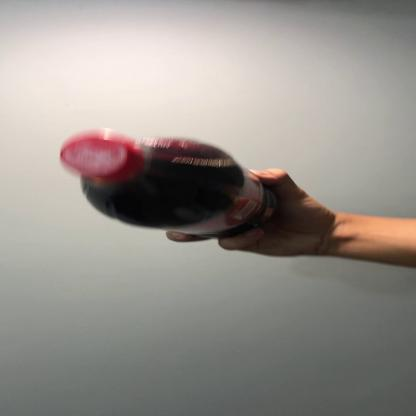



/content/test/Coca-Cola/IMG_5346_260_jpg.rf.7c9b5130b35e5b2dfabc8f417108852e.jpg
Coca-Cola


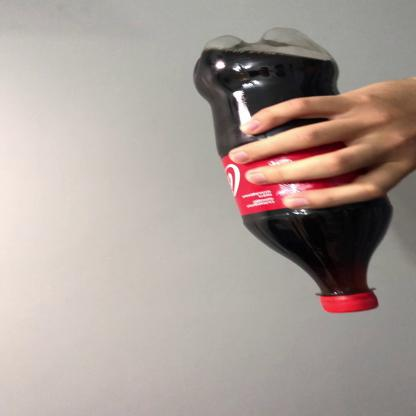



/content/test/Coca-Cola/images - 2020-11-11T181430-406_jpeg.rf.570650aff4f0f573d753ed58962bbb37.jpg
Coca-Cola


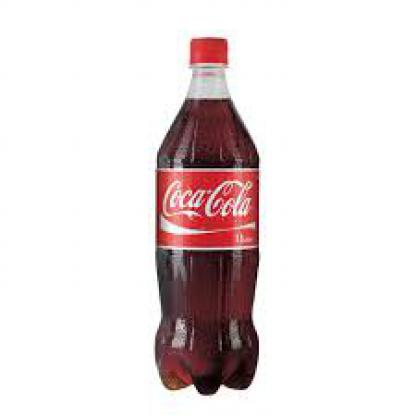



/content/test/Coca-Cola/images (49)_jpeg.rf.250cee898f75ba19831d2456c893b128.jpg
Coca-Cola


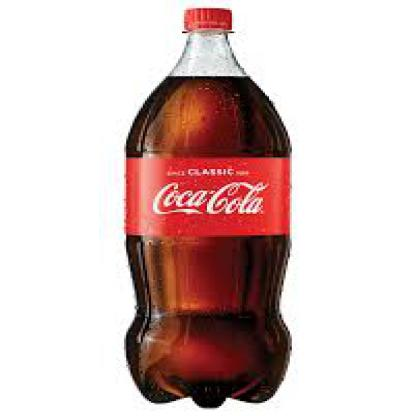



/content/test/Coca-Cola/IMG_5346_163_jpg.rf.70d6b2f78697111999a54fa614afd684.jpg
Coca-Cola


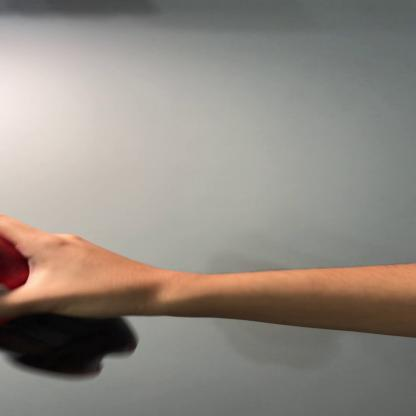



/content/test/Coca-Cola/images (99)_jpeg.rf.541402918192a8daec2b9ccaa3c1abc1.jpg
Coca-Cola


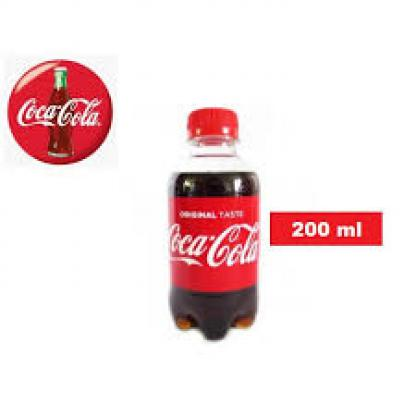



/content/test/Bounty/unnamed (9)_jpg.rf.57d9606d990fb3a1e55af76a5c28e408.jpg
Bounty


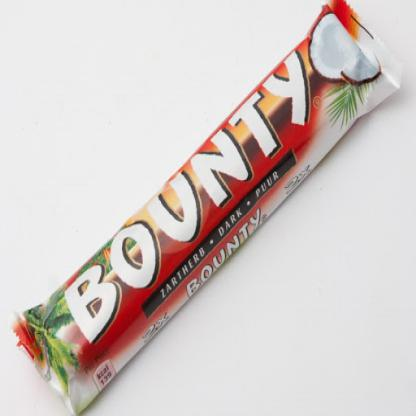



/content/test/Bounty/IMG_5354_086_jpg.rf.c00a0ae907419ebc45c27893cba98527.jpg
Bounty


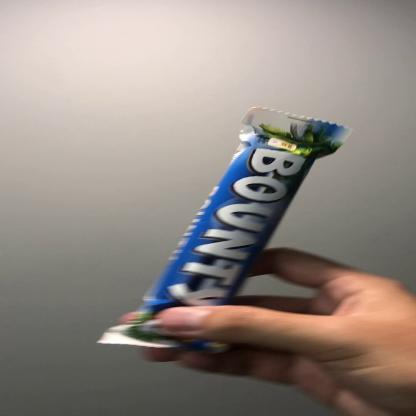



/content/test/Bounty/IMG_5354_158_jpg.rf.c006060d4d0eab29deb15d1b237d6b3e.jpg
Bounty


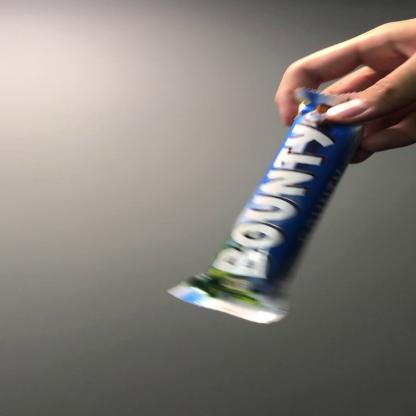



/content/test/Bounty/IMG_5354_186_jpg.rf.42073fe19801e6a87f062ceb5c5fad36.jpg
Bounty


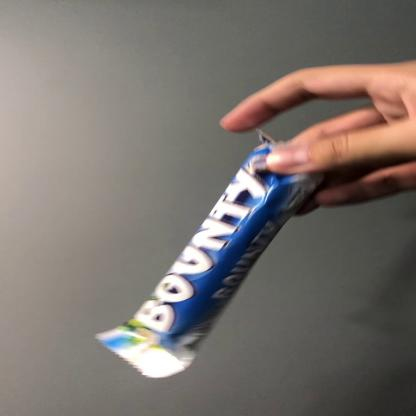



/content/test/Bounty/IMG_5354_268_jpg.rf.279220d354619096ece7b97079c70858.jpg
Bounty


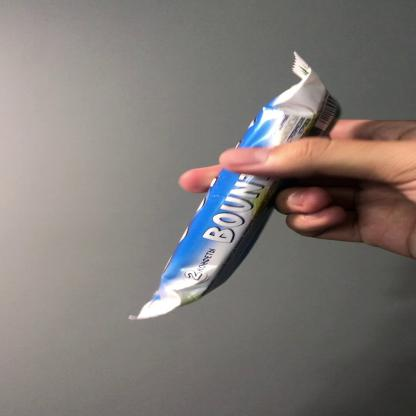



/content/test/Bounty/9045270626334_jpg.rf.2f2b44d1885a71681f6db9fa65afdcd8.jpg
Bounty


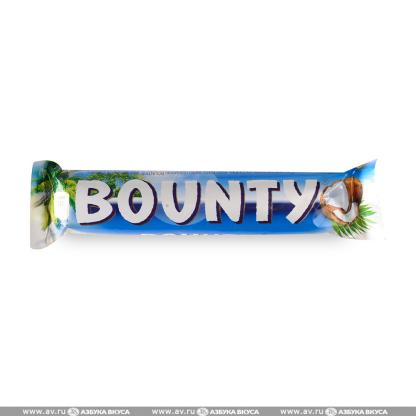



/content/test/Bounty/IMG_5354_173_jpg.rf.2109c0b4a32826a073cc14cd947030cb.jpg
Bounty


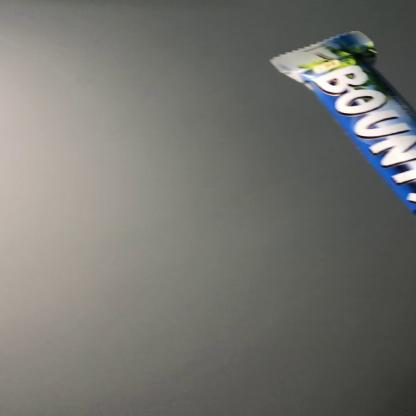



/content/test/Bounty/images (7)_jpeg.rf.9570a2d5c79dafbd80f0f38f5745298c.jpg
Bounty


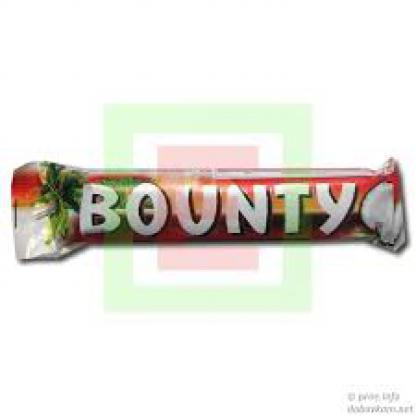



/content/test/Bounty/5488-970_jpg.rf.708d9d67cf72be9053001d6ab4d4e7a1.jpg
Bounty


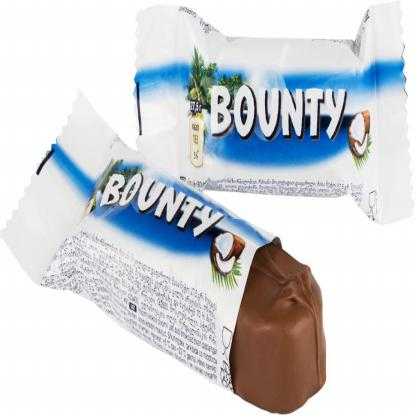



/content/test/Bounty/IMG_5354_203_jpg.rf.4245d94ebe77d2f906e7e0380bf35ee4.jpg
Bounty


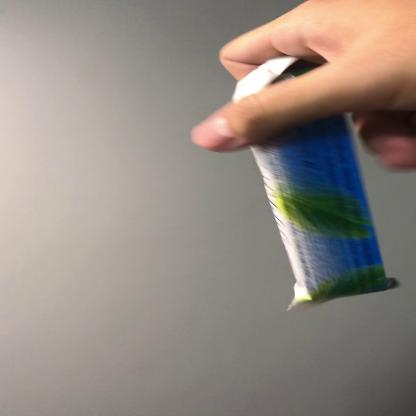



/content/test/Bounty/images (1)_jpeg.rf.8099d6d0a88b6217ea3b8118fea26389.jpg
Bounty


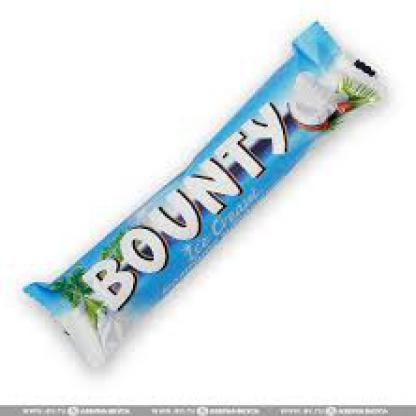



/content/test/Bounty/IMG_5354_088_jpg.rf.38a91ff39378447833ae19704ce8d1bb.jpg
Bounty


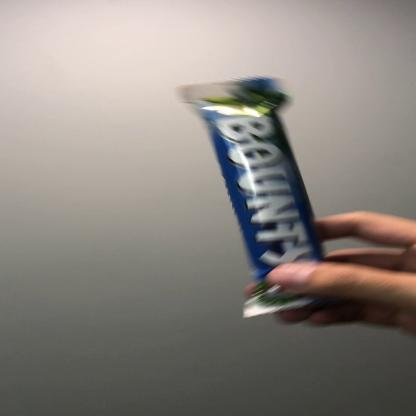



/content/test/Bounty/IMG_5354_256_jpg.rf.2b072783453c3916d85a1ca8de1fca64.jpg
Bounty


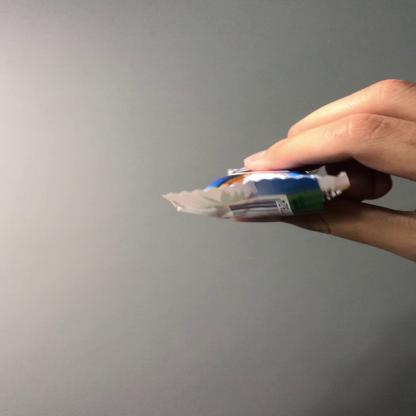



/content/test/Bounty/IMG_5354_295_jpg.rf.4886f42742efe7f9aeab311fef8248d2.jpg
Bounty


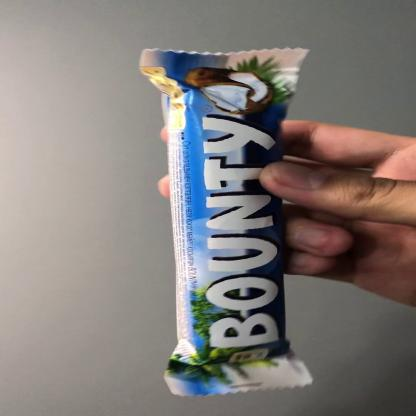



/content/test/Bounty/images (15)_jpeg.rf.6ae8e21547ae1fbf6a72873eb5255e39.jpg
Bounty


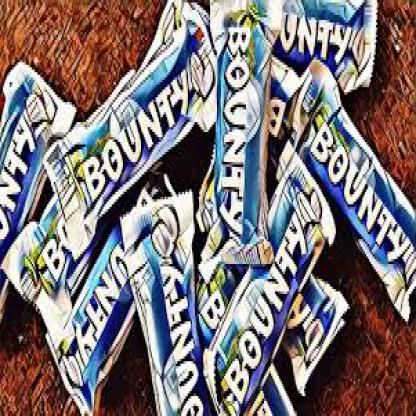



/content/test/Bounty/IMG_5354_262_jpg.rf.466e9ad1ebc1c8dd94b3b00acb2d8a73.jpg
Bounty


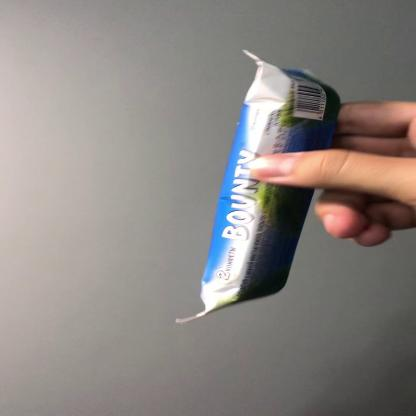



/content/test/Bounty/IMG_5354_029_jpg.rf.451b4f3ba0828cec6930c6b47a21a751.jpg
Bounty


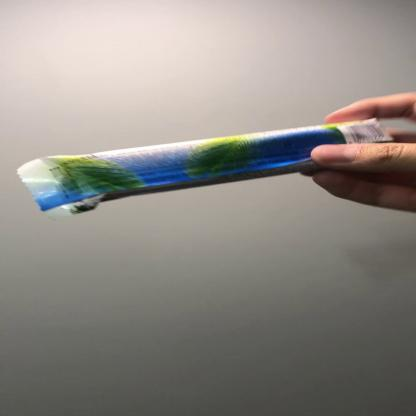



/content/test/Bounty/IMG_5354_191_jpg.rf.3a0c6ff35bcbadf5aa9bb86054068d85.jpg
Bounty


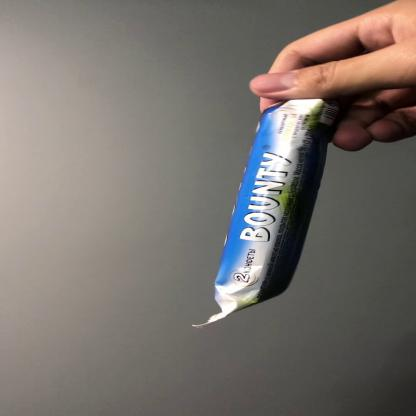



/content/test/Bounty/IMG_5354_148_jpg.rf.f2eb4e2b5d1463f8aba087c3e50b9393.jpg
Bounty


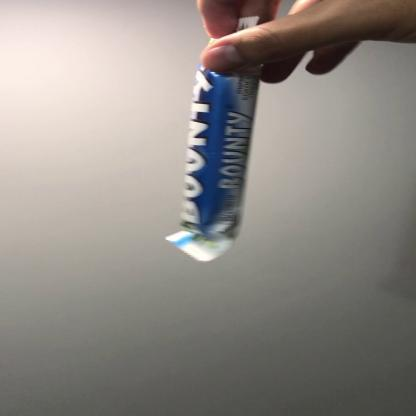



/content/test/Bounty/IMG_5354_266_jpg.rf.1499e55c2594594871822fa80a01c6bc.jpg
Bounty


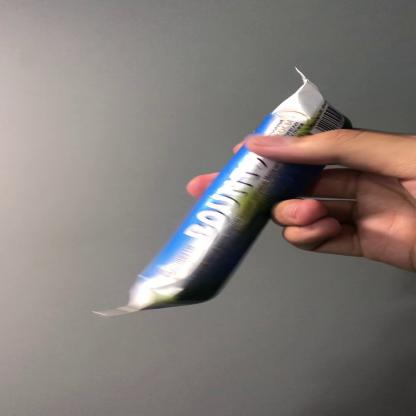



/content/test/Bounty/IMG_5354_125_jpg.rf.8551d18b1a3acda3a5f69e41eae13d80.jpg
Bounty


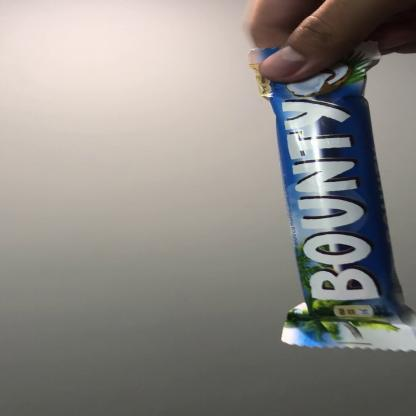



/content/test/Bounty/IMG_5354_035_jpg.rf.04a295c24a92565005187c26bb113a48.jpg
Bounty


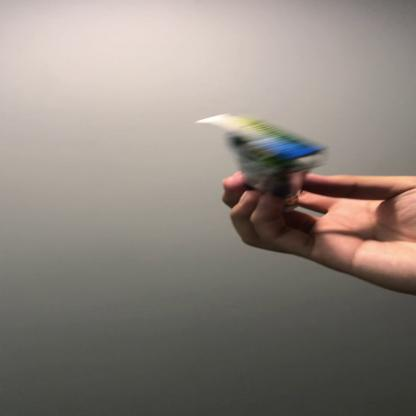



/content/test/Bounty/unnamed (8)_jpg.rf.5e921e5f8ff7c7f52d998cd700052ae4.jpg
Bounty


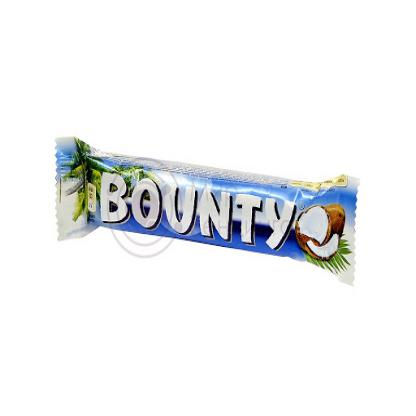



/content/test/Bounty/IMG_5354_127_jpg.rf.e38b26c93004769a88a86f8d82208f89.jpg
Bounty


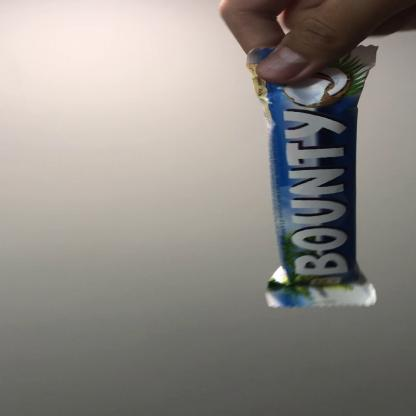



/content/test/Bounty/IMG_5354_214_jpg.rf.ab9f45cbd8987ac18d40ad57c6aaceee.jpg
Bounty


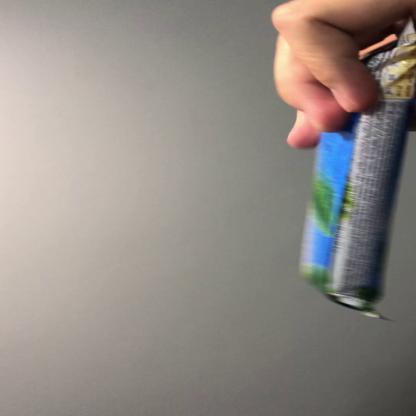



/content/test/Bounty/image (13)_jpeg.rf.1615ec341738ab1365bae75a6f6c3bef.jpg
Bounty


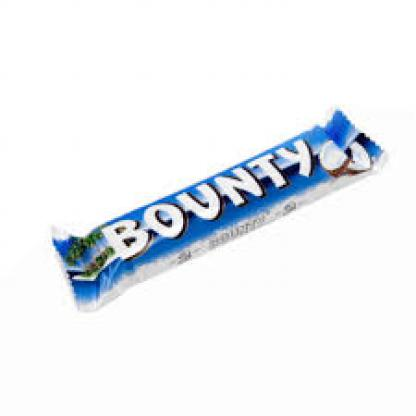



/content/test/Bounty/IMG_5354_251_jpg.rf.6116e9b8eadef8103a60ea0c75b73aac.jpg
Bounty


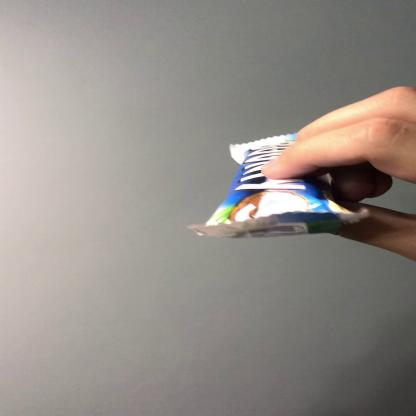



/content/test/Bounty/IMG_5354_041_jpg.rf.c066d30c85ae7c30b6eab5511ca4f1f9.jpg
Bounty


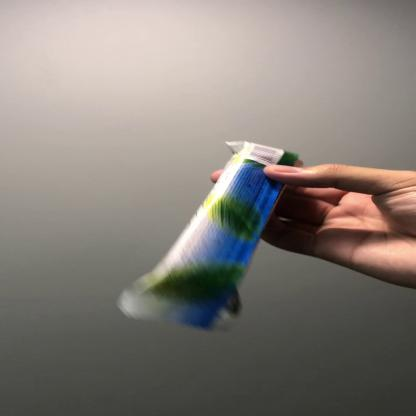



/content/test/Bounty/IMG_5354_050_jpg.rf.d1e9e597fd6d5cd61b227318ea49ff76.jpg
Bounty


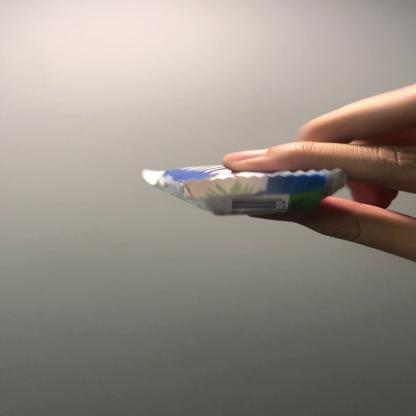



/content/test/Bounty/IMG_5354_160_jpg.rf.621fde3606e4a4553abec3a93f1168d1.jpg
Bounty


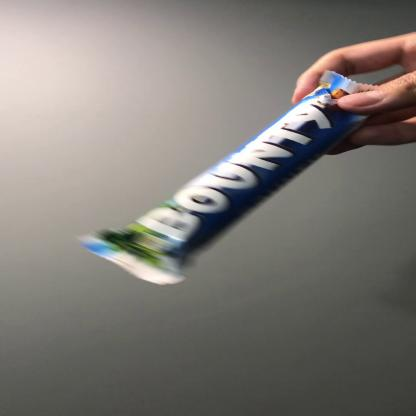



/content/test/Bounty/IMG_5354_267_jpg.rf.2ec94127cbd9209fa5766f0c21e0511c.jpg
Bounty


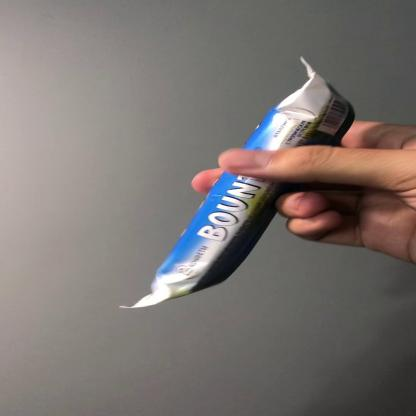



/content/test/Bounty/IMG_5354_253_jpg.rf.fa4ff1206575496c08597bfb0a3941b7.jpg
Bounty


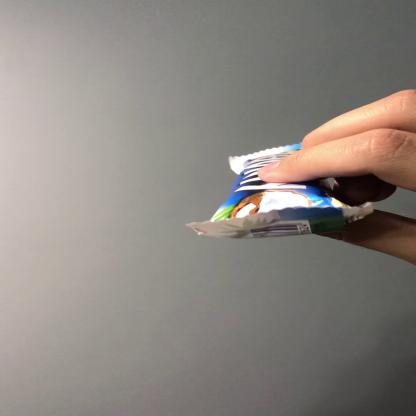



/content/test/LemonFresh/IMG_5349_117_jpg.rf.602c4d8ce71383ad1ad3c741301e4b3f.jpg
LemonFresh


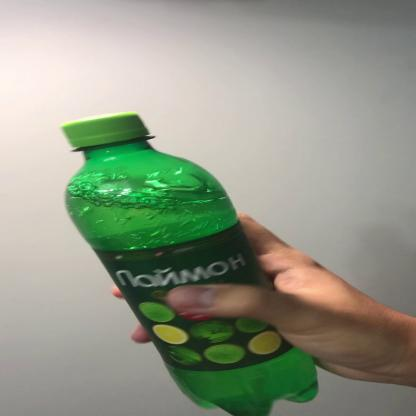



/content/test/LemonFresh/IMG_5349_272_jpg.rf.77f5692def048c04339316a365071b35.jpg
LemonFresh


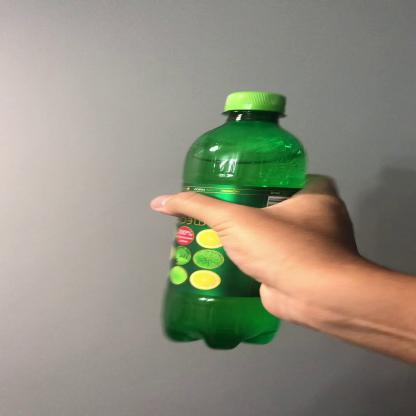



/content/test/LemonFresh/IMG_5349_037_jpg.rf.d28710609ece4c6e8cc654684f47580c.jpg
LemonFresh


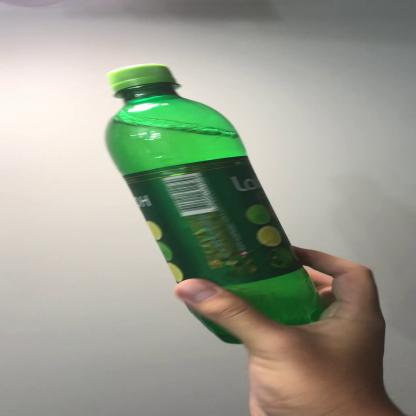



/content/test/LemonFresh/IMG_5349_219_jpg.rf.983f0eb718fc545ebd1b867b2393b222.jpg
LemonFresh


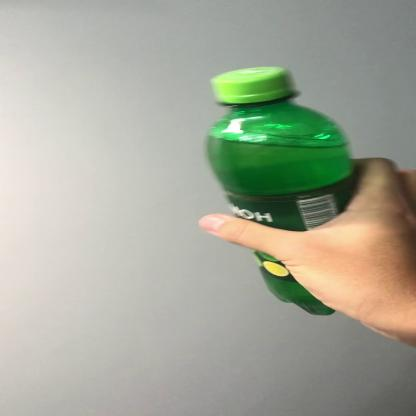



/content/test/LemonFresh/IMG_5349_214_jpg.rf.534dd817f1b0bd400c886ceaf208d894.jpg
LemonFresh


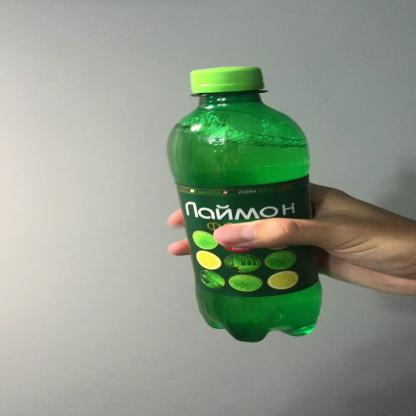



/content/test/LemonFresh/IMG_5349_199_jpg.rf.6b6c4704d03ef4983030305c372dc47f.jpg
LemonFresh


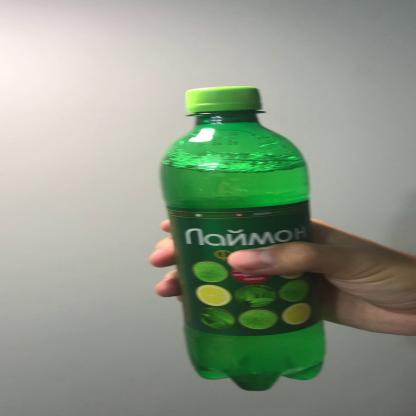



/content/test/LemonFresh/IMG_5349_209_jpg.rf.0fab425f6fefd4b53be6852c84c3c64c.jpg
LemonFresh


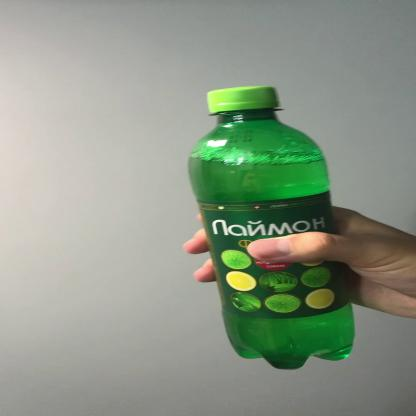



/content/test/LemonFresh/IMG_5349_177_jpg.rf.c7c48b5a98f63611641a68cc28657ac5.jpg
LemonFresh


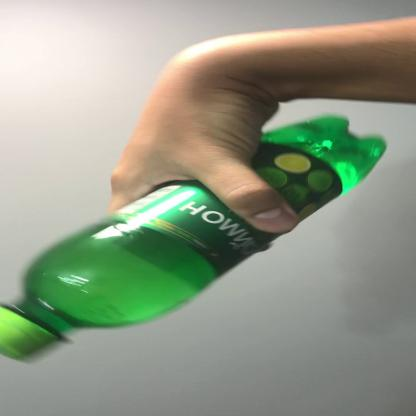



/content/test/LemonFresh/IMG_5349_163_jpg.rf.ae958012d65d24003ff30a14f76d3fe0.jpg
LemonFresh


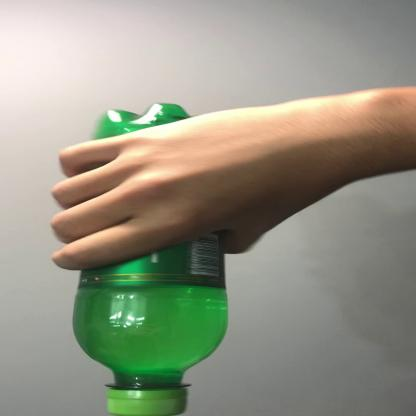



/content/test/LemonFresh/IMG_5349_175_jpg.rf.5d50298e0e6cbb1e4084174b2ec72307.jpg
LemonFresh


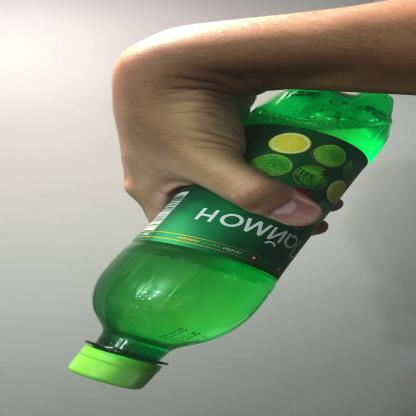



/content/test/LemonFresh/IMG_5349_174_jpg.rf.3fc19175227785548104db35eab4abfb.jpg
LemonFresh


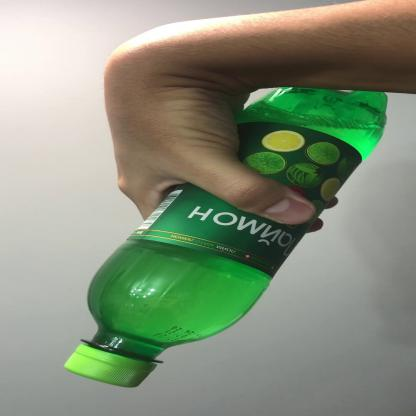



/content/test/LemonFresh/IMG_5349_293_jpg.rf.60a31d941f8c8dc38f90659c7a9f15dd.jpg
LemonFresh


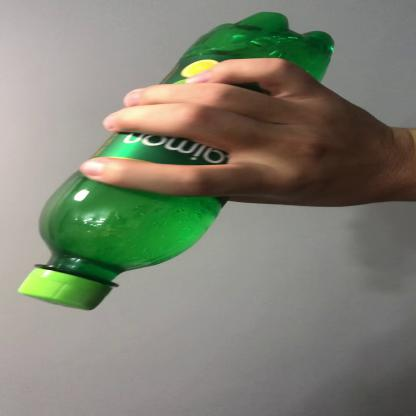



/content/test/LemonFresh/IMG_5349_056_jpg.rf.c1dc068b02645df93d2a838688fef376.jpg
LemonFresh


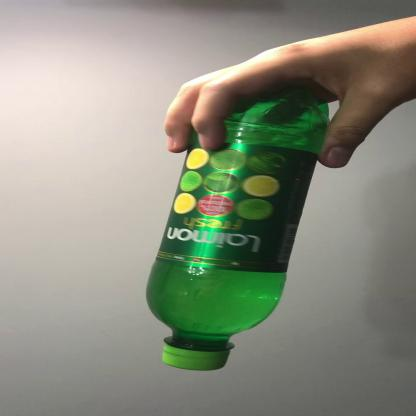



/content/test/LemonFresh/IMG_5349_127_jpg.rf.df38154e32ffe47f064f945b630a2df4.jpg
LemonFresh


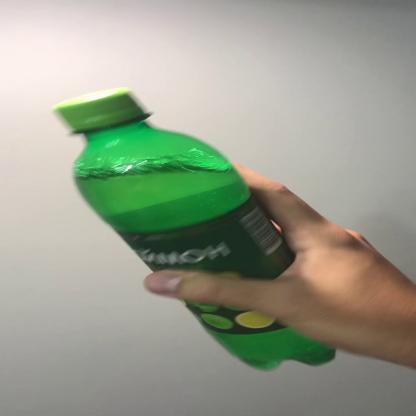



/content/test/LemonFresh/IMG_5349_182_jpg.rf.4609c99ea1abfa37db96d4f6a89ecc6d.jpg
LemonFresh


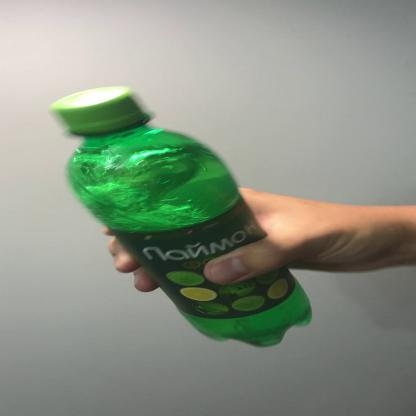



/content/test/LemonFresh/IMG_5349_210_jpg.rf.5ca4724446ff61b76843a424b0c69542.jpg
LemonFresh


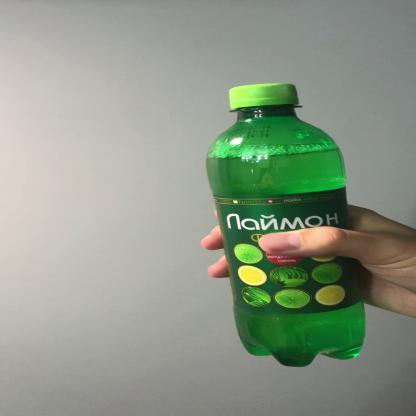



/content/test/LemonFresh/IMG_5349_295_jpg.rf.9dafafe5e2ea0b9573c60c17f9c8e767.jpg
LemonFresh


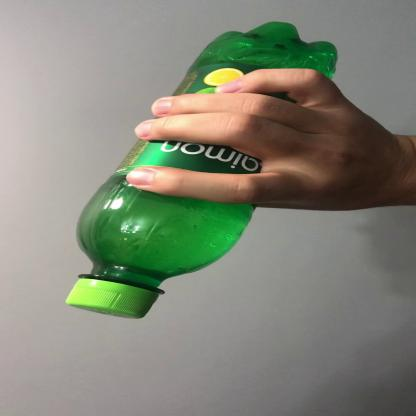



/content/test/LemonFresh/IMG_5349_224_jpg.rf.b8f71130928dddf6d9bbd4eca4d71fe1.jpg
LemonFresh


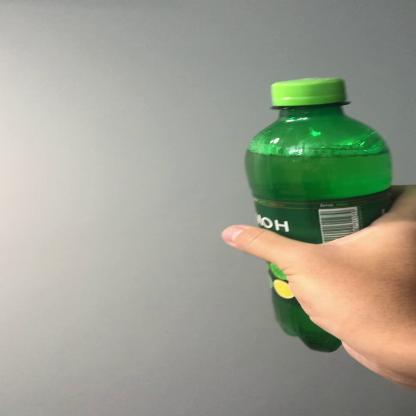



/content/test/LemonFresh/IMG_5349_133_jpg.rf.9ee034ac33653824a816c51d7218f8bb.jpg
LemonFresh


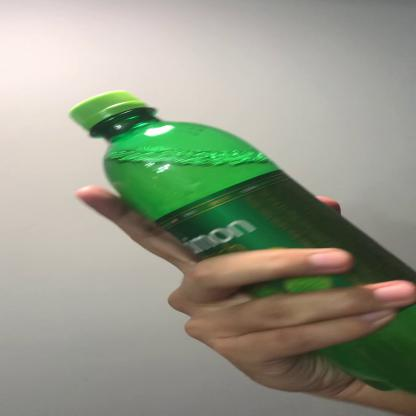



/content/test/LemonFresh/IMG_5349_159_jpg.rf.61d27b7bc12314016a88f36a3f16d41b.jpg
LemonFresh


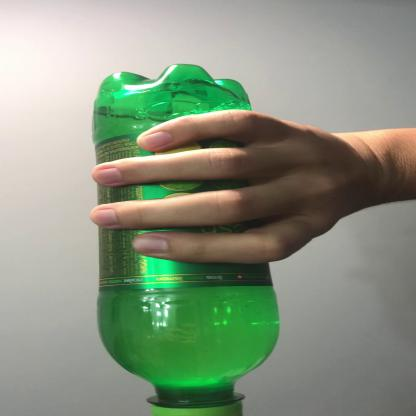



/content/test/LemonFresh/IMG_5349_098_jpg.rf.de8665e98defa286ad2b46a53508f874.jpg
LemonFresh


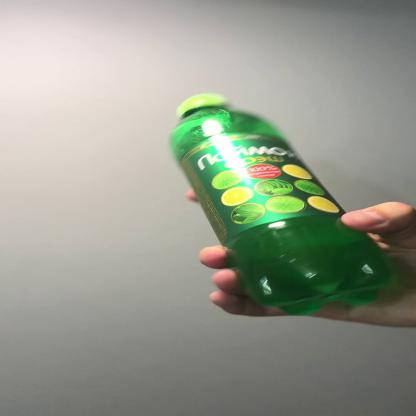



/content/test/LemonFresh/IMG_5349_204_jpg.rf.3e5704acd54ad6dbf79a409a93655769.jpg
LemonFresh


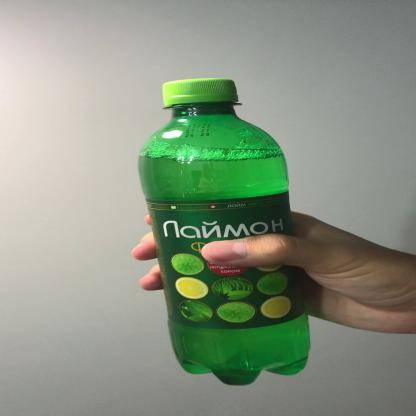



/content/test/LemonFresh/IMG_5349_122_jpg.rf.10f42543750dddbe0fcfb17b7c298bc5.jpg
LemonFresh


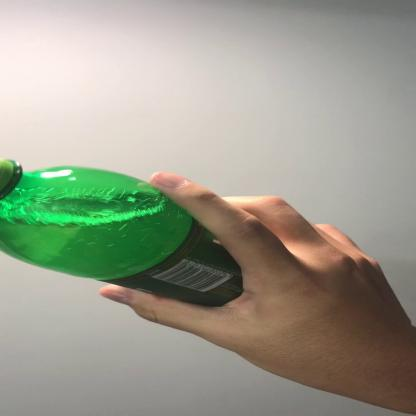



/content/test/LemonFresh/IMG_5349_116_jpg.rf.95092cba540d0c79b6546489b4ccfcd2.jpg
LemonFresh


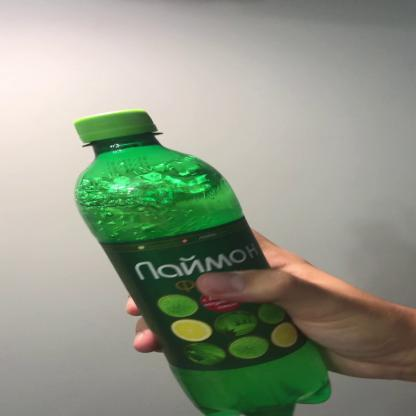



/content/test/LemonFresh/IMG_5349_067_jpg.rf.058749bae202f87a62c8f21795eef920.jpg
LemonFresh


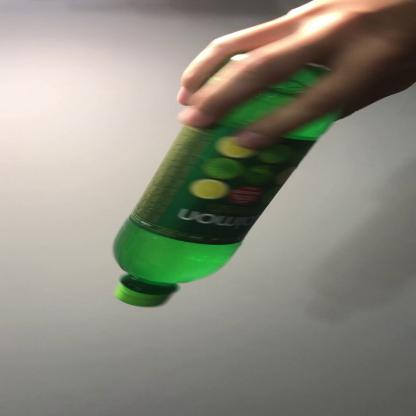



/content/test/LemonFresh/IMG_5349_225_jpg.rf.6ceca18d1e614e519e774317399469c5.jpg
LemonFresh


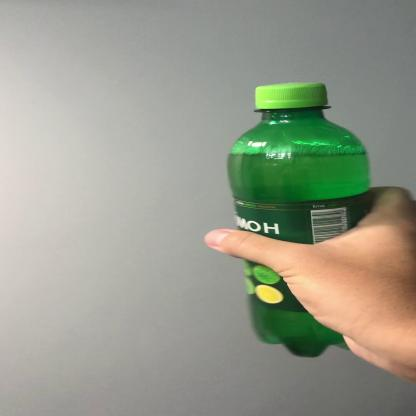



/content/test/LemonFresh/IMG_5349_120_jpg.rf.9e12ded9fd8d9efbeaae0ff91b296306.jpg
LemonFresh


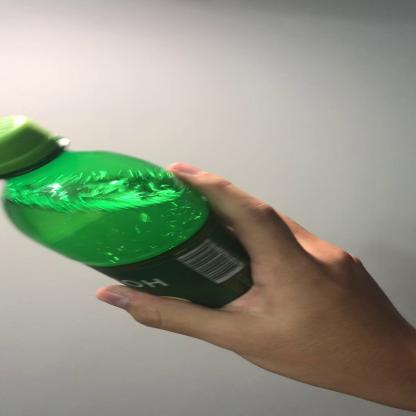



/content/test/LemonFresh/IMG_5349_103_jpg.rf.ccbcdb7f67a1b94988e1c8728425fe66.jpg
LemonFresh


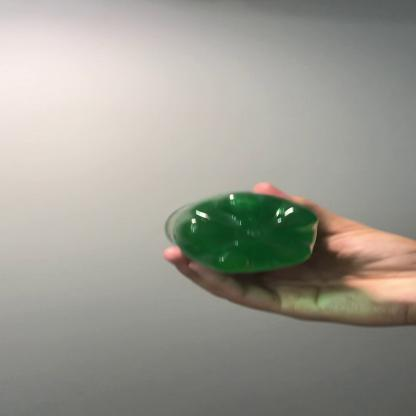



/content/test/LemonFresh/IMG_5349_203_jpg.rf.87fab55c2dbc5550daee19cd375848a2.jpg
LemonFresh


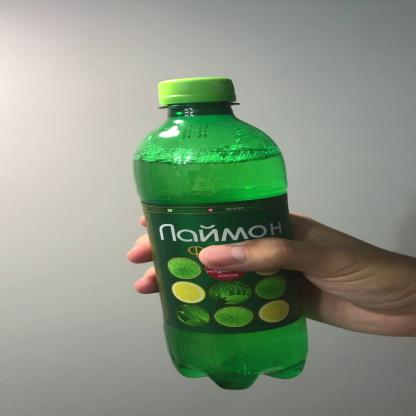



/content/test/LemonFresh/IMG_5349_220_jpg.rf.c9d4d86f2e2da0b22ec1dc826d7edb4b.jpg
LemonFresh


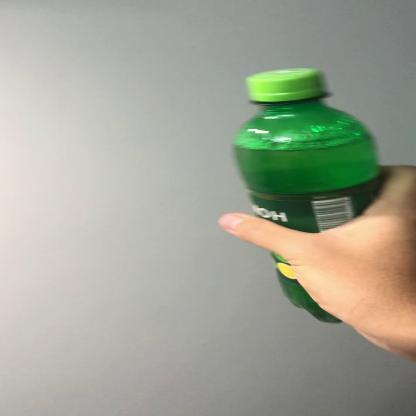



/content/test/Pepsi/6476_jpg.rf.0955e60672748dfae0511f4552974289.jpg
Pepsi


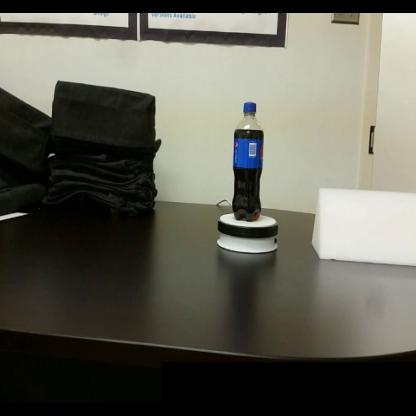



/content/test/Pepsi/3125_jpg.rf.e4b0eec4ab56fa7d89da0ea11ebf48fd.jpg
Pepsi


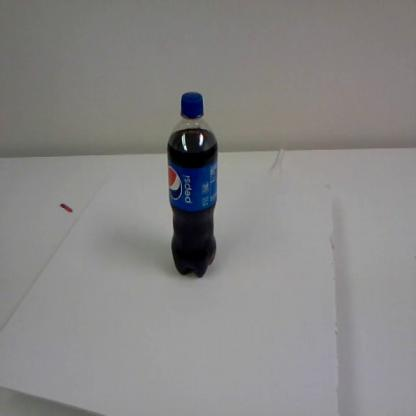



/content/test/Pepsi/IMG_5348_013_jpg.rf.f9e7b3fca1eb6b7302d498c6921cafe0.jpg
Pepsi


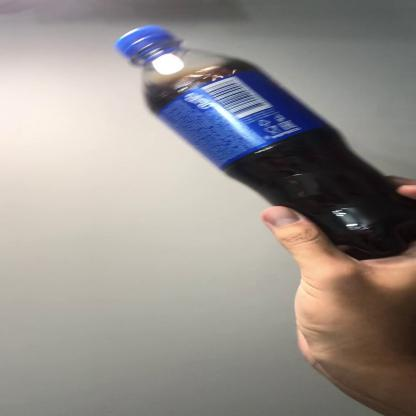



/content/test/Pepsi/6422_jpg.rf.a38dbe0605cda3d078ac509b22f99d2d.jpg
Pepsi


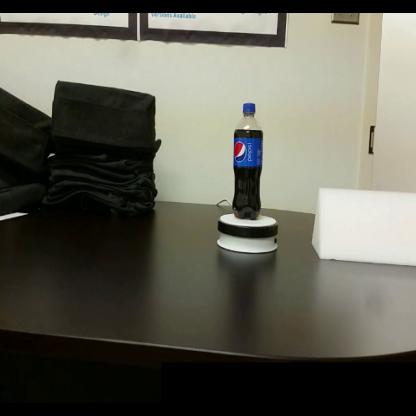



/content/test/Pepsi/3317_jpg.rf.a6081ad97ac40ca1d782cd3ad79d3648.jpg
Pepsi


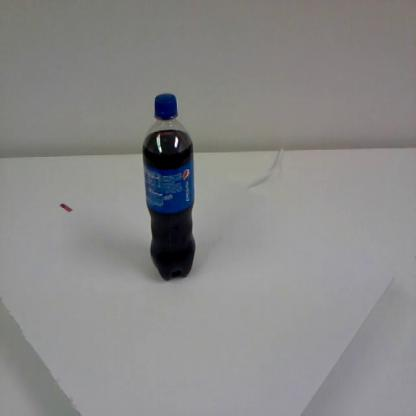



/content/test/Pepsi/3108_jpg.rf.9872367c0dd78d1eb9ce7216e4ffcbde.jpg
Pepsi


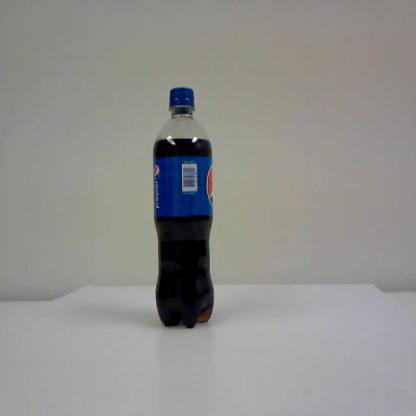



/content/test/Pepsi/6543_jpg.rf.2bd70137e460a6f942aeecd65ce36454.jpg
Pepsi


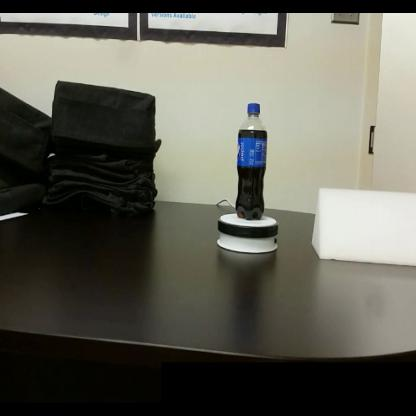



/content/test/Pepsi/3020_jpg.rf.68d77553ec452fb26aea5d6f7726cb04.jpg
Pepsi


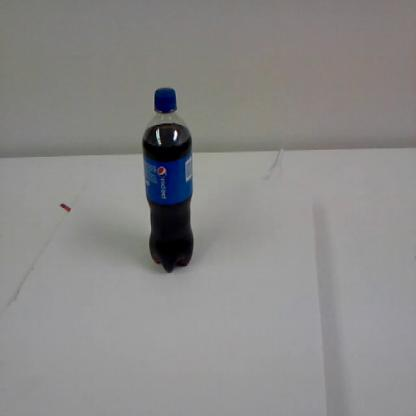



/content/test/Pepsi/3121_jpg.rf.e13325c4f2b13300905cda89b3548eb1.jpg
Pepsi


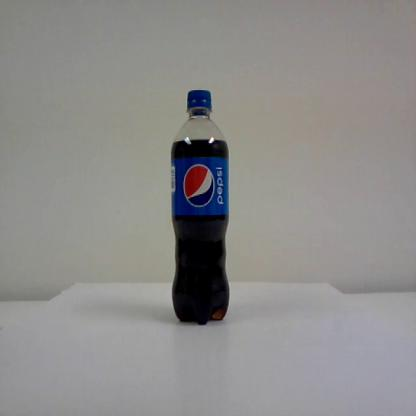



/content/test/Pepsi/4202_jpg.rf.dd92aac28b47f04e4fb544cc307f199c.jpg
Pepsi


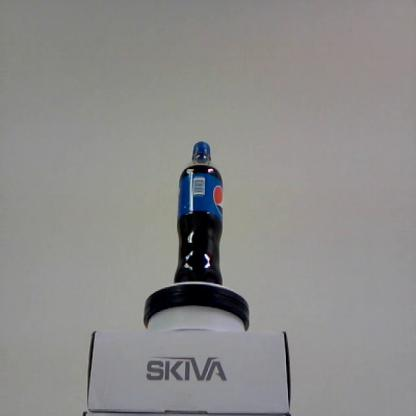



/content/test/Pepsi/IMG_5348_072_jpg.rf.9f726b5d7509e9882c95a86028dad7ba.jpg
Pepsi


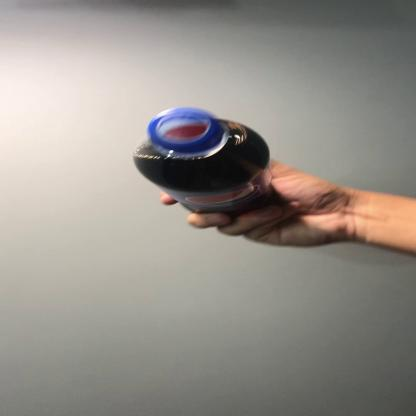



/content/test/Pepsi/IMG_5348_232_jpg.rf.2f1c40270fdf125f51936693c909bfbc.jpg
Pepsi


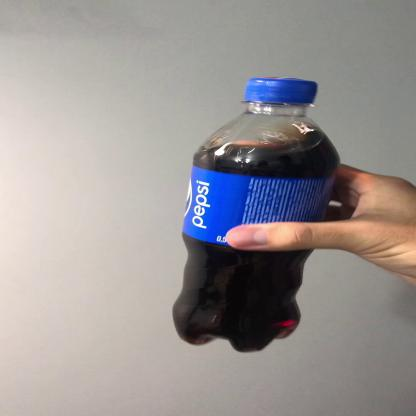



/content/test/Pepsi/IMG_5348_030_jpg.rf.53573fa461158303755ac50531cf7133.jpg
Pepsi


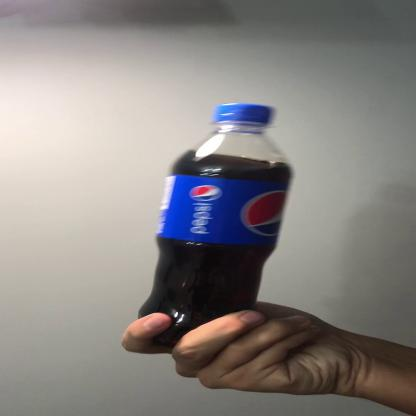



/content/test/Pepsi/6470_jpg.rf.04e2e694c010152638079ad0f8823e35.jpg
Pepsi


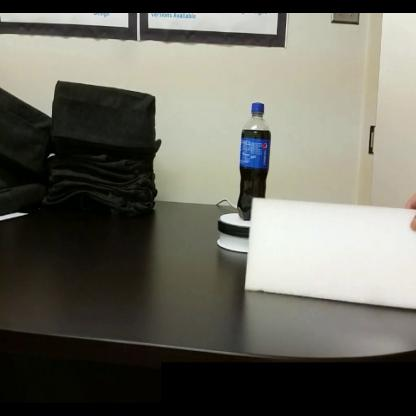



/content/test/Pepsi/6495_jpg.rf.33239a832ff93323cc81c7e9c6c880a6.jpg
Pepsi


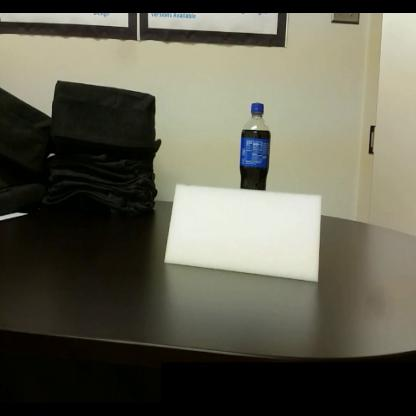



/content/test/Pepsi/IMG_5348_208_jpg.rf.8d43c3d0cc6eeddf3e9f0fccf16813d6.jpg
Pepsi


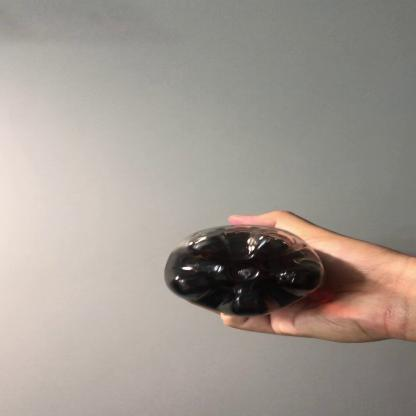



/content/test/Pepsi/4213_jpg.rf.25ba6168c6fa170680c6a8022ee407b9.jpg
Pepsi


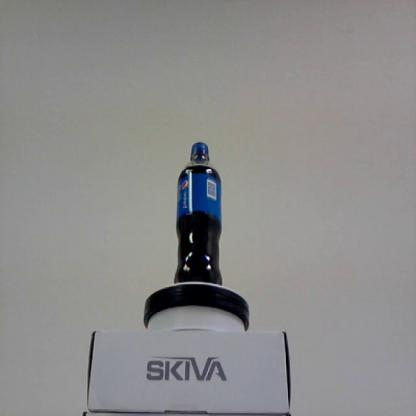



/content/test/Pepsi/6649_jpg.rf.f279ad949efd6904c3d0f04767a4e9f0.jpg
Pepsi


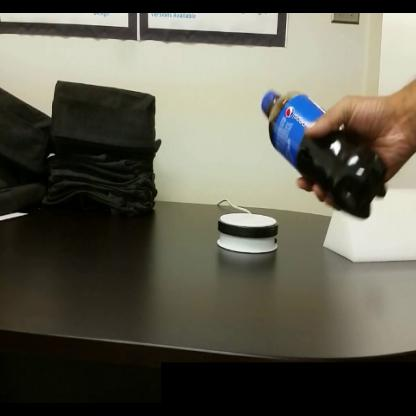



/content/test/Pepsi/IMG_5348_158_jpg.rf.0ebabd0874ee51d6ede496f89ec94bca.jpg
Pepsi


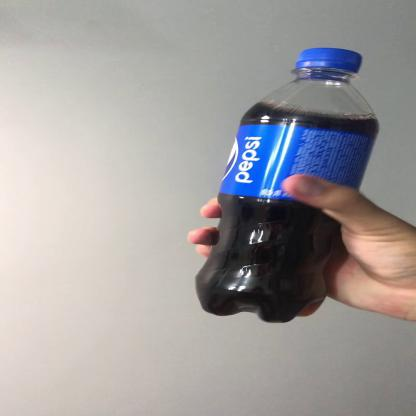



/content/test/Pepsi/IMG_5348_119_jpg.rf.2a960e90f284db422d252b84efb0e21c.jpg
Pepsi


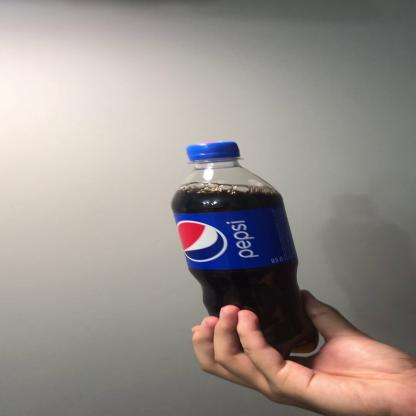



/content/test/Pepsi/6660_jpg.rf.95b50c993487ae1f7230d17c64c1b6c5.jpg
Pepsi


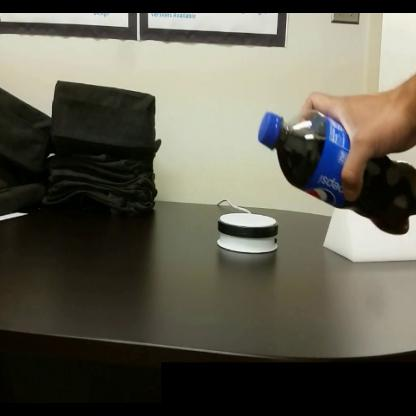



/content/test/Pepsi/3049_jpg.rf.b94fe0b9b0b7d58f3bd3833e9a55b2c3.jpg
Pepsi


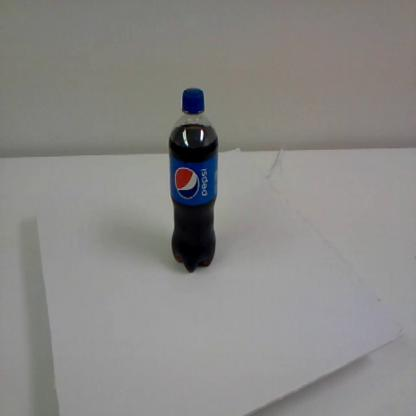



/content/test/Pepsi/4159_jpg.rf.483efb7b214605e79677e596590b7927.jpg
Pepsi


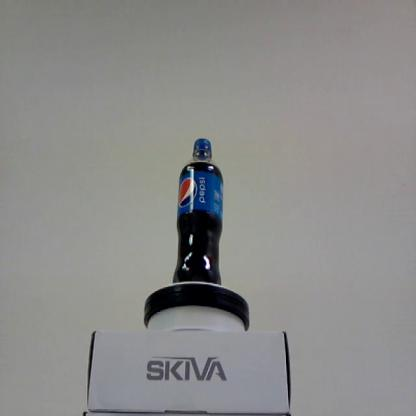



/content/test/Pepsi/3192_jpg.rf.651be88d6c19740d7577ba1709d6653c.jpg
Pepsi


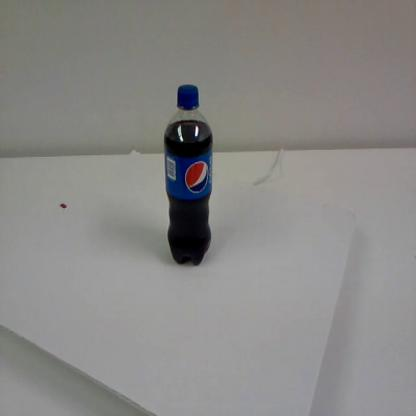



/content/test/Pepsi/3038_jpg.rf.11341bd7d86b52a2a8c79ed5b9af8d67.jpg
Pepsi


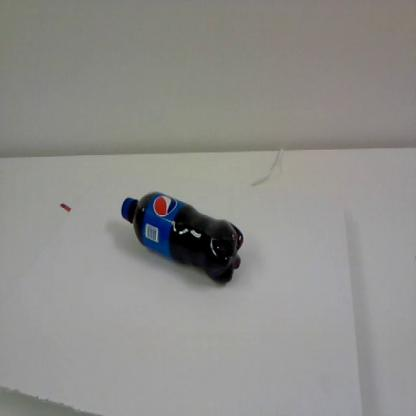



/content/test/Pepsi/2941_jpg.rf.9d42b0bc2642eed8904b0d2aa82a86d6.jpg
Pepsi


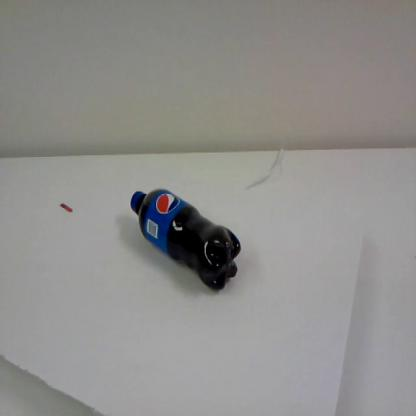



/content/test/Pepsi/3294_jpg.rf.10abba8fae4e234129fa1ce971446bb5.jpg
Pepsi


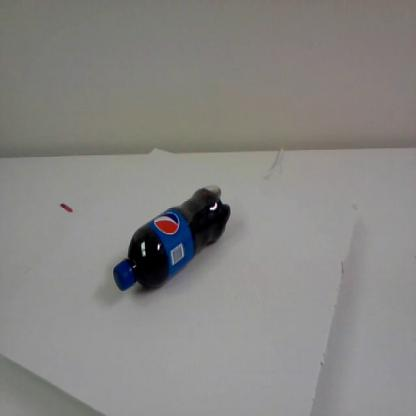



/content/test/Pepsi/IMG_5348_003_jpg.rf.1e5b38d55dd37a90d14acc95218407ef.jpg
Pepsi


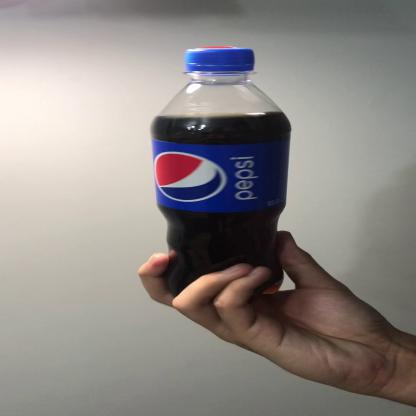



/content/test/Pepsi/IMG_5348_211_jpg.rf.d7dc43c1c29e3c01ef3f8da5812a83e0.jpg
Pepsi


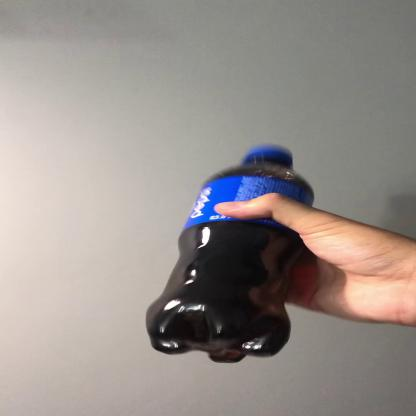



/content/test/Pepsi/IMG_5348_027_jpg.rf.62ef6dcbe08540caaac25335f0ee6de1.jpg
Pepsi


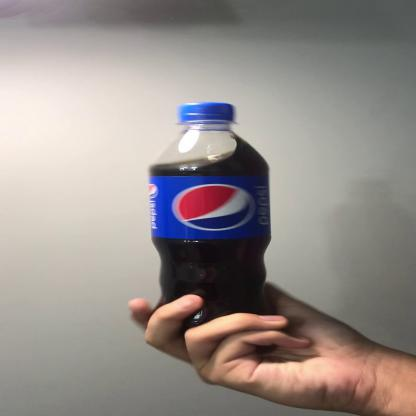



/content/test/Pepsi/3257_jpg.rf.874da372cd65f80444d5d403c9d62cc0.jpg
Pepsi


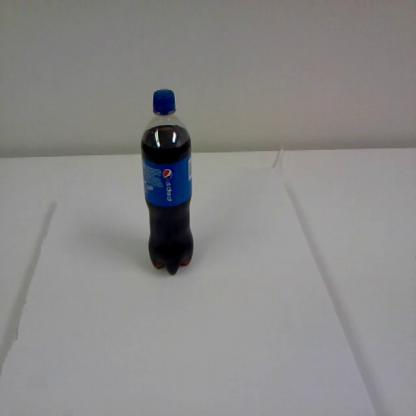



/content/test/Pepsi/2963_jpg.rf.a1aad4006afd2d8bc04956bf10d1ae93.jpg
Pepsi


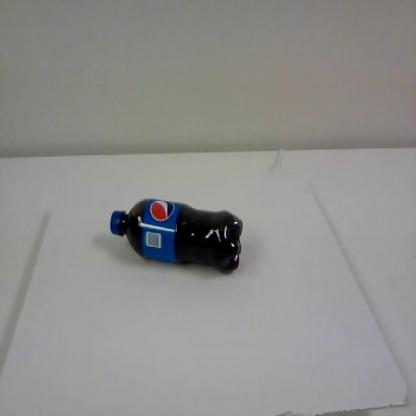



/content/test/Pepsi/3139_jpg.rf.3b2196105809c4dc5c1fb0f24cb0a94d.jpg
Pepsi


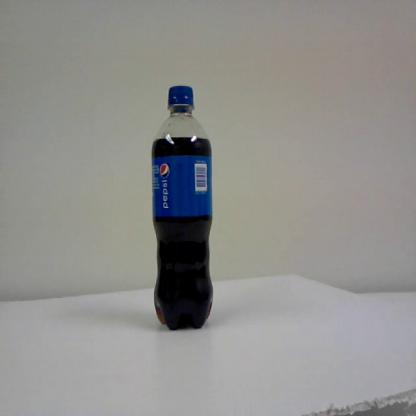



/content/test/Pepsi/3219_jpg.rf.1b08e025395ac7deb7352c97a8417a96.jpg
Pepsi


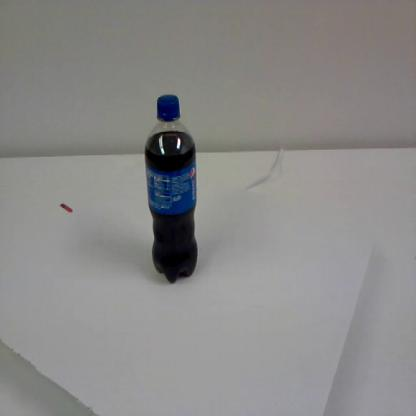



/content/test/Pepsi/6592_jpg.rf.0da8d7f01e21157b9cd0b480157a89fc.jpg
Pepsi


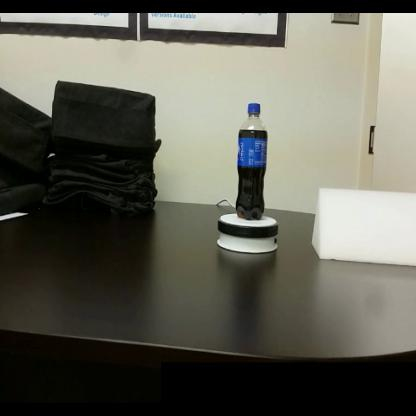



/content/test/Pepsi/4182_jpg.rf.7dc3b149badca516d7664ee3bb747992.jpg
Pepsi


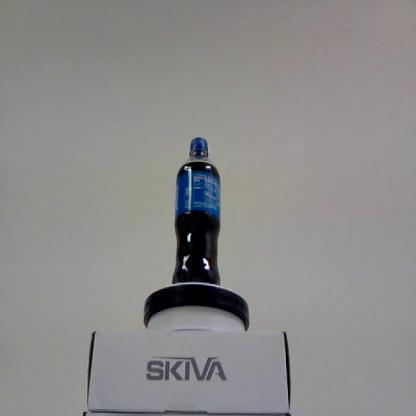



/content/test/Pepsi/4251_jpg.rf.d68a39b496dab36fa8cb5edc4b88fd4f.jpg
Pepsi


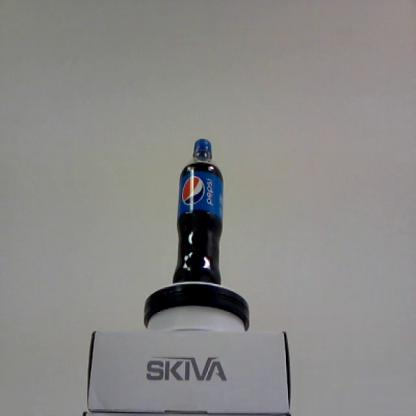



/content/test/Pepsi/4171_jpg.rf.e93e1fd094c9929a2f9e02c331f4e797.jpg
Pepsi


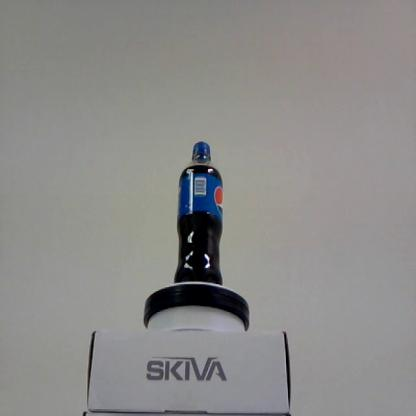



/content/test/Pepsi/3161_jpg.rf.64245b2e52612fde5baf3c5e97d769a8.jpg
Pepsi


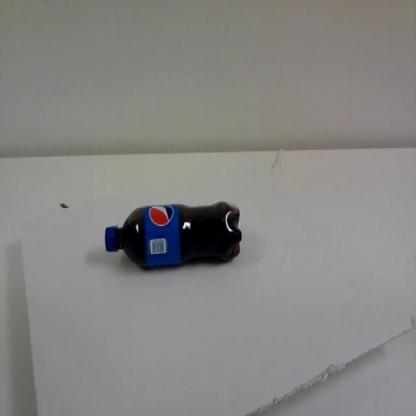



/content/test/Pepsi/IMG_5348_209_jpg.rf.3d7fa3c8e2752e4846216cef9a9b9532.jpg
Coca-Cola


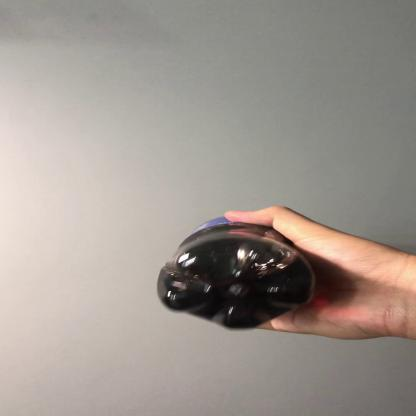



/content/test/Pepsi/2989_jpg.rf.1488491c7d46d0848faa63328db85512.jpg
Pepsi


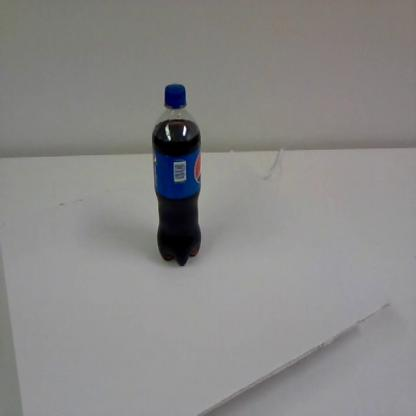



/content/test/Pepsi/3080_jpg.rf.5b7acf3001452eaf716955b61fa9c5fb.jpg
Pepsi


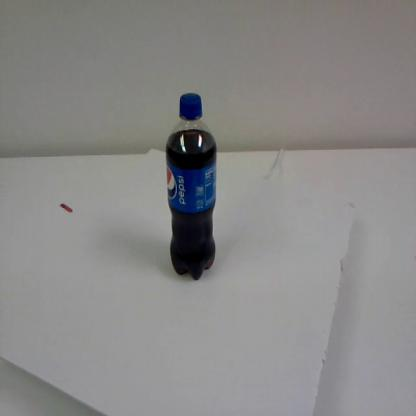



/content/test/Pepsi/3084_jpg.rf.4469adb94ac27bf4e86bb4294803531b.jpg
Pepsi


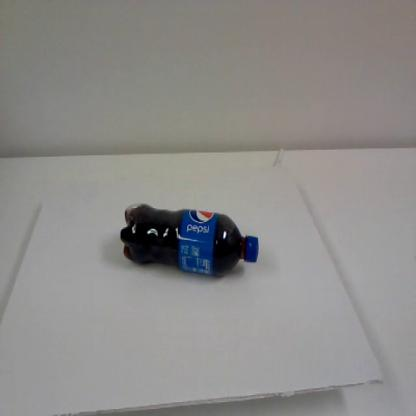



/content/test/Pepsi/6608_jpg.rf.d55a4f1d50cb5fddbbc376a3a7d8cc90.jpg
Pepsi


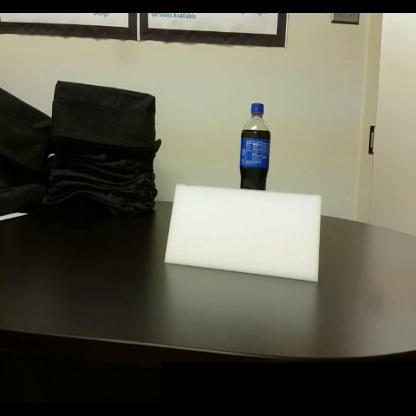



/content/test/Pepsi/6454_jpg.rf.79bd2e9a03d861727528b7d2dc31ac18.jpg
Pepsi


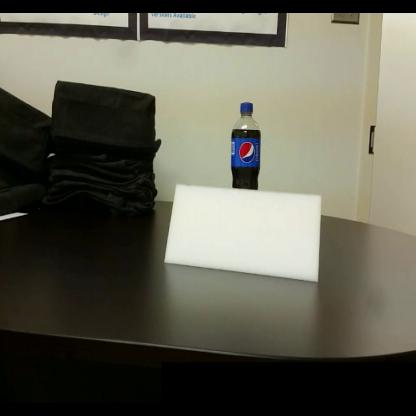



/content/test/Pepsi/IMG_5348_145_jpg.rf.3b0f3d16d44f1e0c3440483670485528.jpg
Pepsi


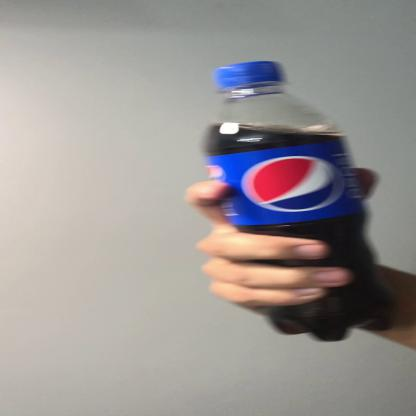



/content/test/Pepsi/IMG_5348_143_jpg.rf.4f982d938d9318c9e54bbd2dcf75b5dc.jpg
Pepsi


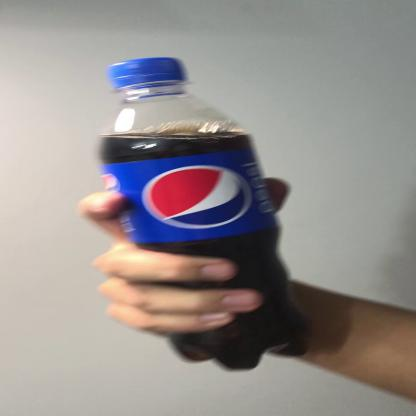



/content/test/Pepsi/IMG_5348_019_jpg.rf.bc139571a6091758c58f6dbf2766b74d.jpg
Pepsi


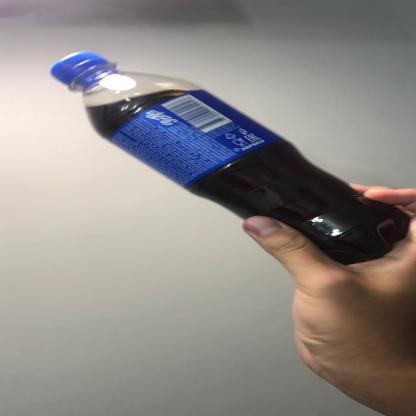



/content/test/Pepsi/3004_jpg.rf.617affb7a2113dc1f66137e246ade3cb.jpg
Pepsi


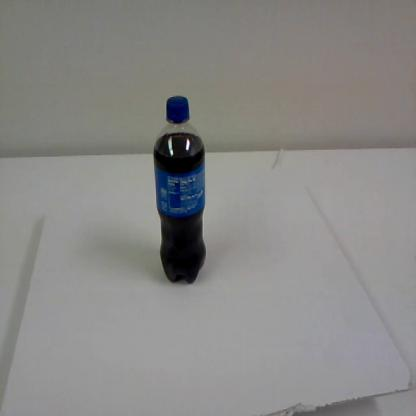



/content/test/Pepsi/2996_jpg.rf.35081521299919f2e980841b946343b1.jpg
Pepsi


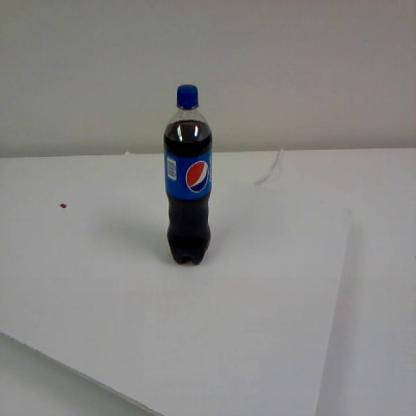



/content/test/Pepsi/3253_jpg.rf.b722fbd0660d0d7d810e59ef0116a6e9.jpg
Pepsi


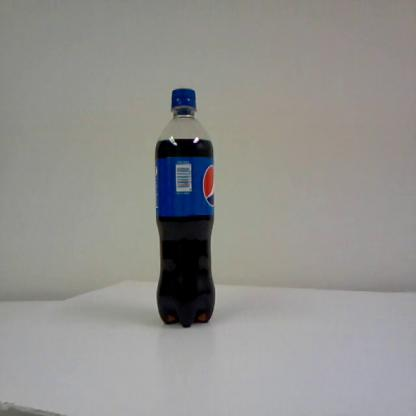



/content/test/Pepsi/6687_jpg.rf.81cf9a1c52e48907f897e14245d7fbf4.jpg
Pepsi


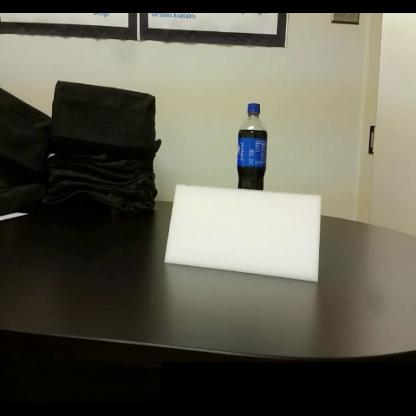



/content/test/Pepsi/3262_jpg.rf.dfd454d1b7cf0d517ac27ee486fd91f2.jpg
Pepsi


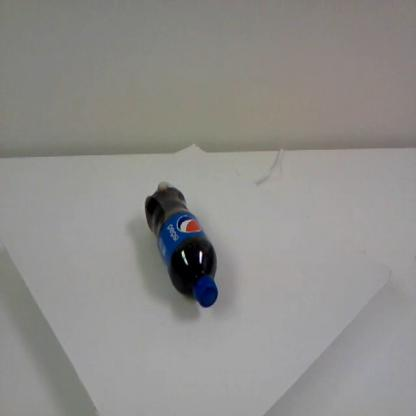



/content/test/Pepsi/4237_jpg.rf.8553694b58d74bb36b1aa3f55fd9a47c.jpg
Pepsi


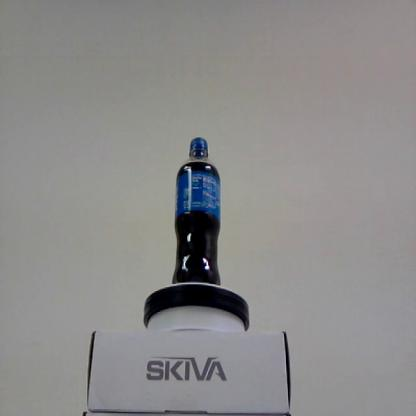



/content/test/Pepsi/6577_jpg.rf.e8c2791095f08c2fc38e2b7f1c901c5f.jpg
Pepsi


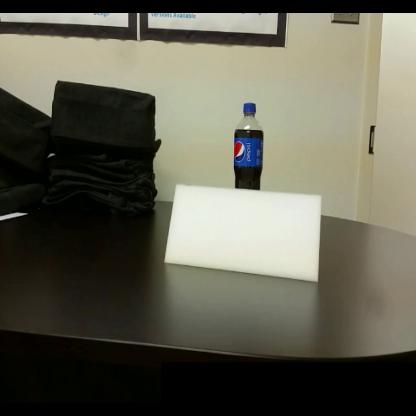



/content/test/Pepsi/IMG_5348_075_jpg.rf.044ad64073dcebd1defd4a6f137d0dbd.jpg
Pepsi


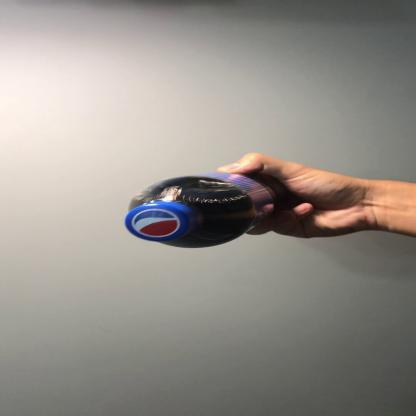



/content/test/Pepsi/4230_jpg.rf.50b47a4f11244ad619b5db1087beabaf.jpg
Pepsi


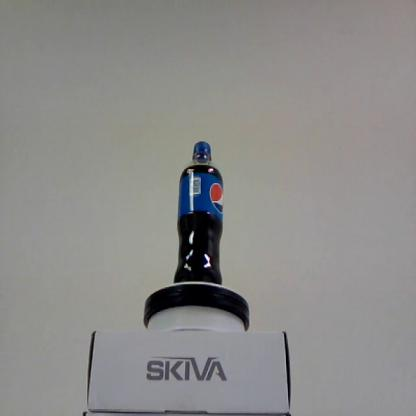



/content/test/Pepsi/4198_jpg.rf.3911438ab56961e505599548d6d3fe5e.jpg
Pepsi


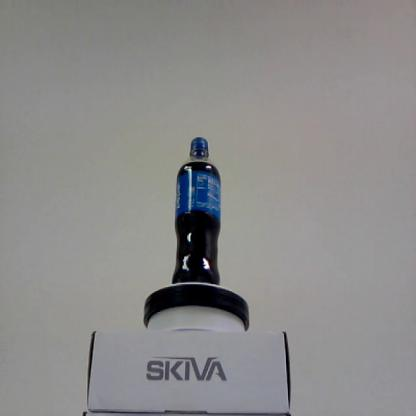



/content/test/Pepsi/IMG_5348_176_jpg.rf.3ce9b8e22ace03b9dd8ae1e767a38709.jpg
Pepsi


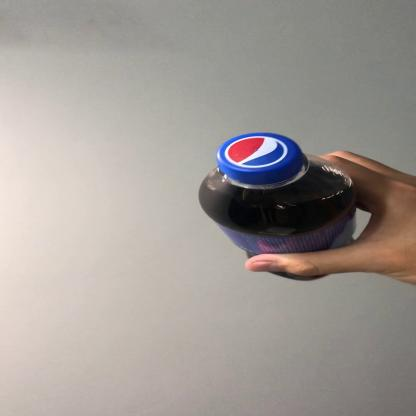



/content/test/Pepsi/3063_jpg.rf.ee9334532d6eab966f3dd74445e6ec37.jpg
Pepsi


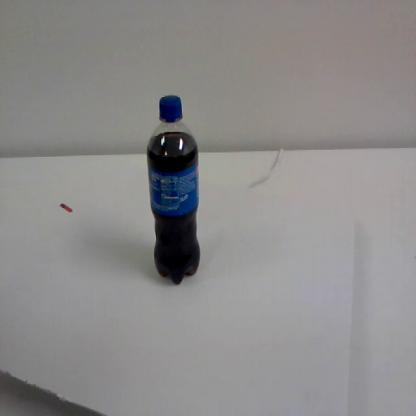



/content/test/Pepsi/IMG_5348_017_jpg.rf.6df8faf65c92a4c1ab827f3de8ceb141.jpg
Pepsi


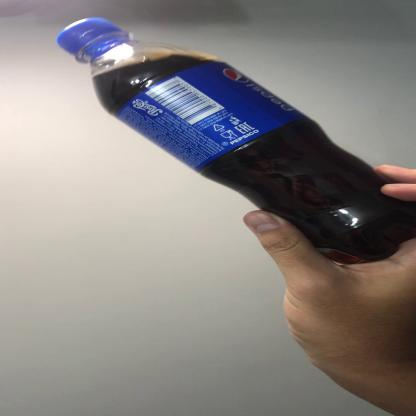



/content/test/Pepsi/3029_jpg.rf.afcbe21b5eff323343b8ca2b6c842385.jpg
Pepsi


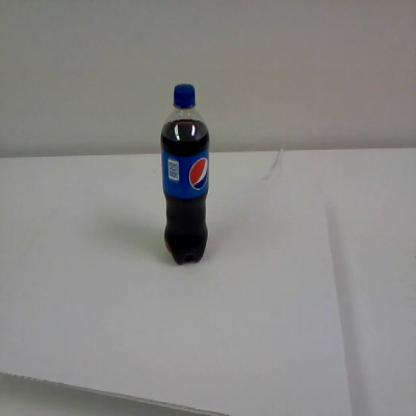



/content/test/Pepsi/3143_jpg.rf.772394b18ef33dbfc5f6879f11668a86.jpg
Pepsi


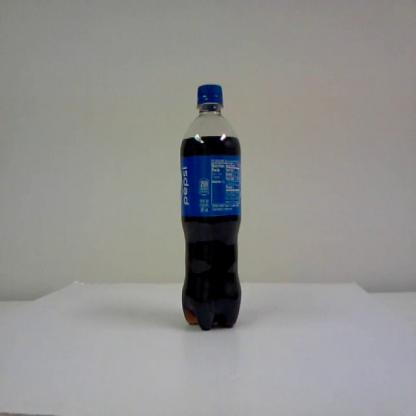



/content/test/Pepsi/4207_jpg.rf.dd5c761012b2c3d1bbf93262b3ce93f2.jpg
Pepsi


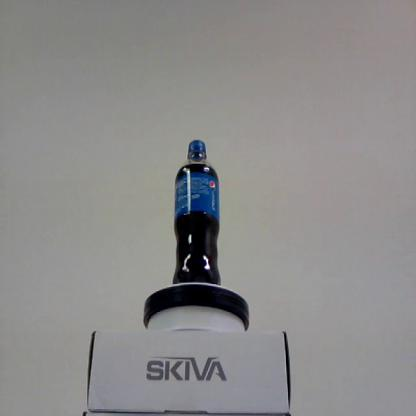



/content/test/Pepsi/6475_jpg.rf.cbcbb345bbfabc080aa400e1bc5d0999.jpg
Pepsi


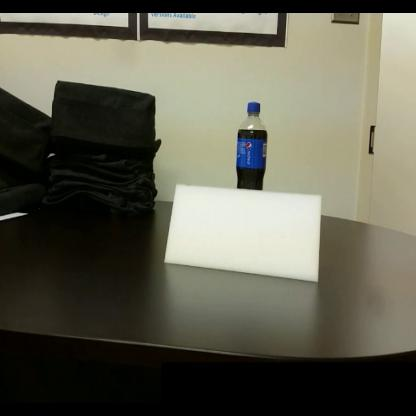



/content/test/Pepsi/6612_jpg.rf.df6094df80e42c4443f0ccf77a2b6cf5.jpg
Pepsi


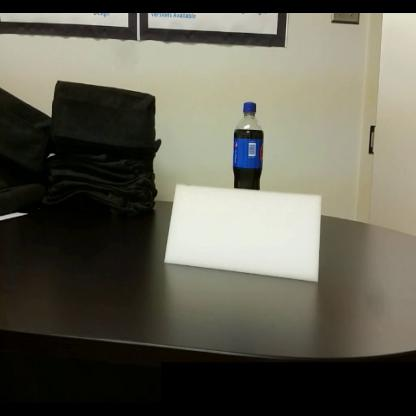



/content/test/Pepsi/3152_jpg.rf.9a846c7c4be7e412d37b7a792fb63c16.jpg
Pepsi


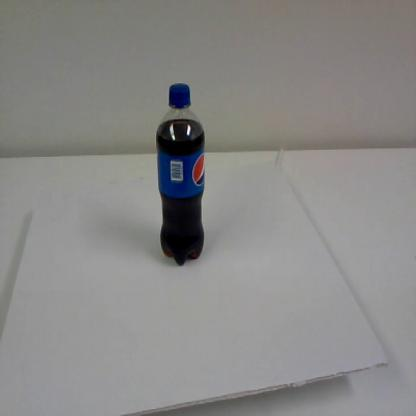



/content/test/Pepsi/6489_jpg.rf.117951be049f22b8e23a744e508d4888.jpg
Pepsi


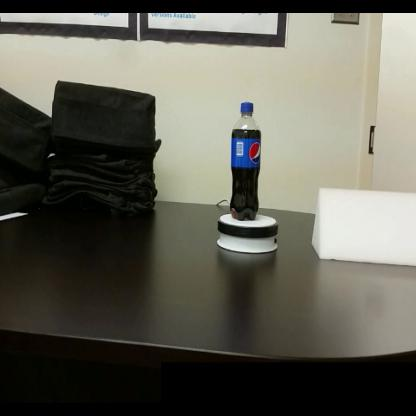



/content/test/Pepsi/4174_jpg.rf.3b7bede8f794c85fb188c19c8ed36656.jpg
Pepsi


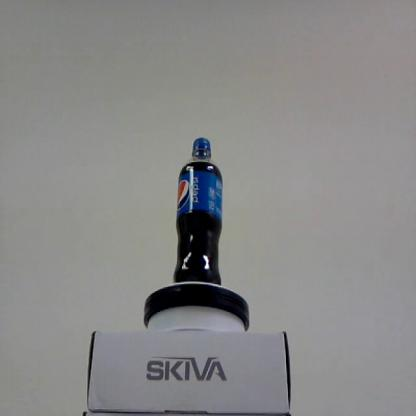



/content/test/Pepsi/6613_jpg.rf.05de4ec82825b3cd95042949f24b6d83.jpg
Pepsi


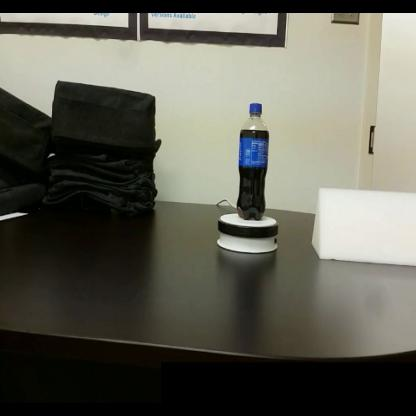



/content/test/Pepsi/IMG_5348_084_jpg.rf.dca8fef5a9ec8713899ffa67f9d9d42b.jpg
Pepsi


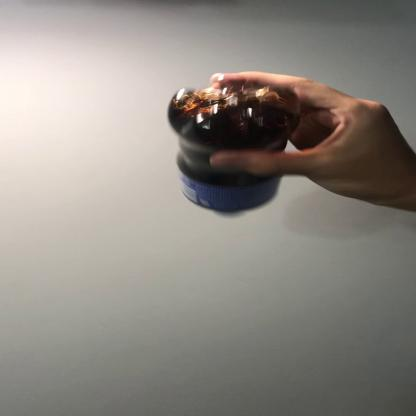



/content/test/Pepsi/3132_jpg.rf.3633885ca43400afe4dc4a0afe117db5.jpg
Pepsi


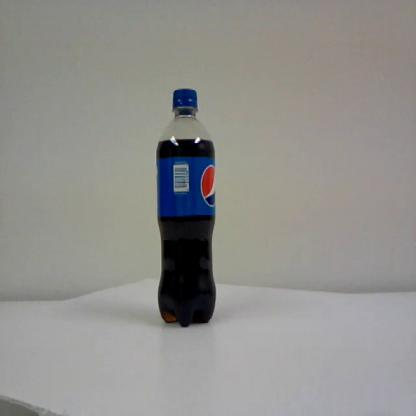



/content/test/Pepsi/2160_corrected_jpg.rf.72b4af3c9e30b2bf9aed3fad271d3654.jpg
Pepsi


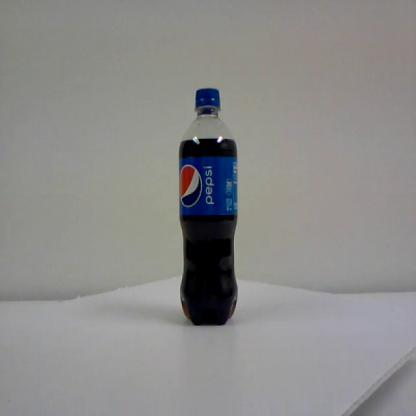



/content/test/Pepsi/IMG_5348_246_jpg.rf.a5e045d2bc68b80179af608f4a926e7d.jpg
Pepsi


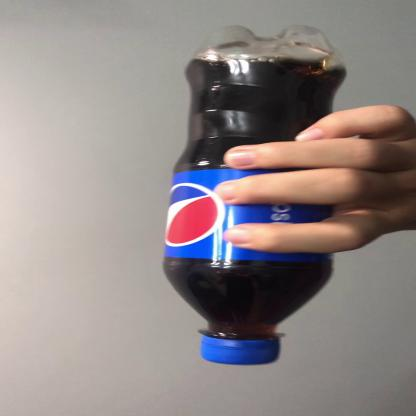



/content/test/Pepsi/6432_jpg.rf.3f29f4bb94043fa65c1f601cde406a6e.jpg
Pepsi


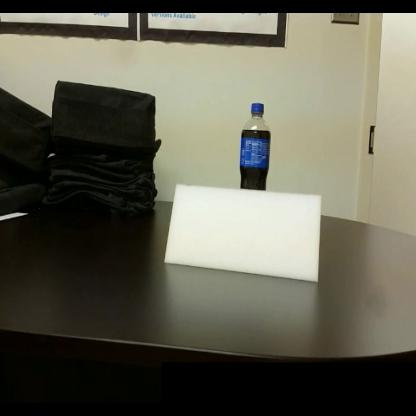



/content/test/Pepsi/6546_jpg.rf.1cbc21e6a8f2b85ba41920b22b8a48f3.jpg
Pepsi


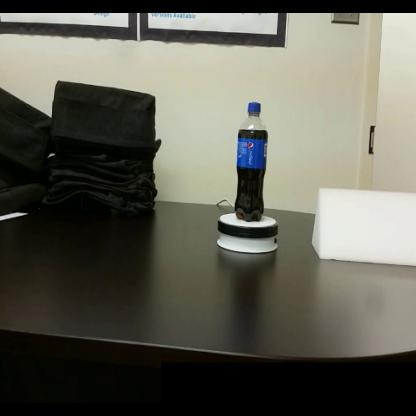



/content/test/Pepsi/6545_jpg.rf.434461fbe5ec0213394500c657d72d32.jpg
Pepsi


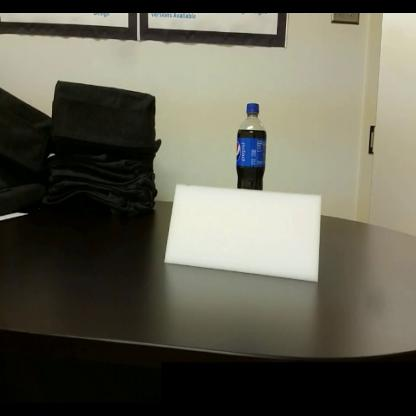



/content/test/Pepsi/4219_jpg.rf.808bd6030bb02c3ff3c4ecf9fd9807d0.jpg
Pepsi


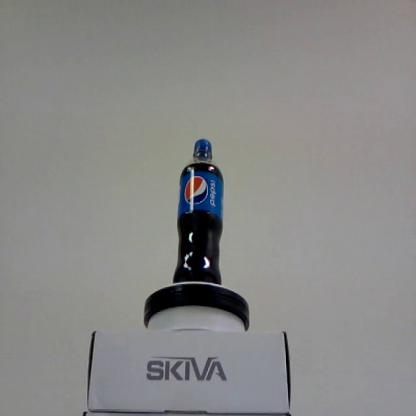



/content/test/Pepsi/IMG_5348_274_jpg.rf.f319f284d412942afe57e46e36611a3b.jpg
Pepsi


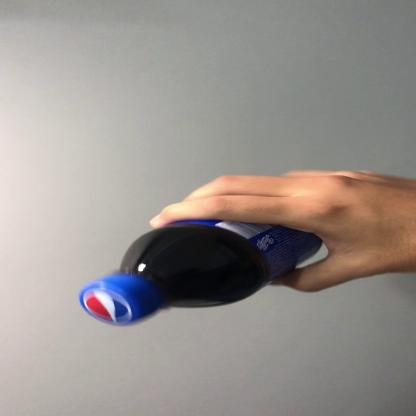



/content/test/Pepsi/6633_jpg.rf.78ea428754b790e17b14b400bd5df16d.jpg
Pepsi


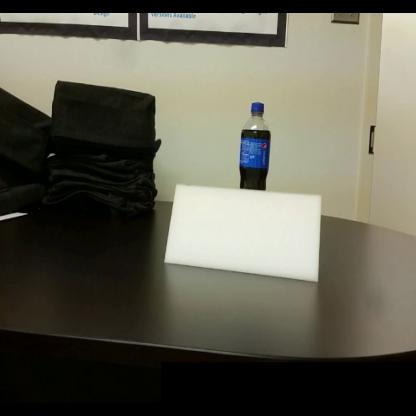



/content/test/Pepsi/6645_jpg.rf.2a7ecc2bdca4fa73e795a84e7374f716.jpg
Pepsi


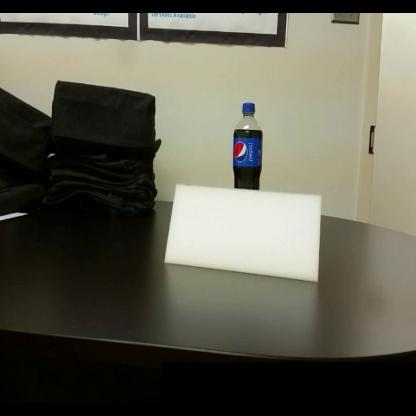



/content/test/Pepsi/6643_jpg.rf.ede7f0194080d859e61d45c4b7a8d719.jpg
Pepsi


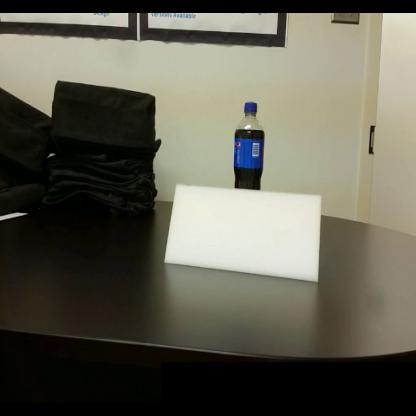



/content/test/Pepsi/6463_jpg.rf.bd2b62eca567dde2299071b8364b8d99.jpg
Pepsi


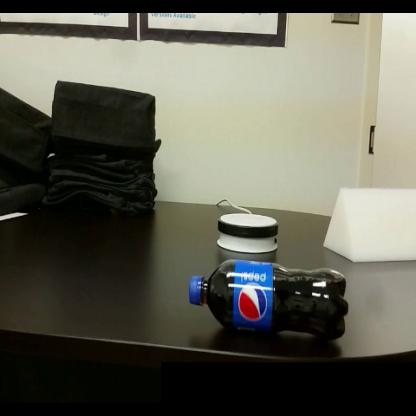



/content/test/Pepsi/IMG_5348_294_jpg.rf.eb0b7bf1689b960e7c387fd407a5ff31.jpg
Pepsi


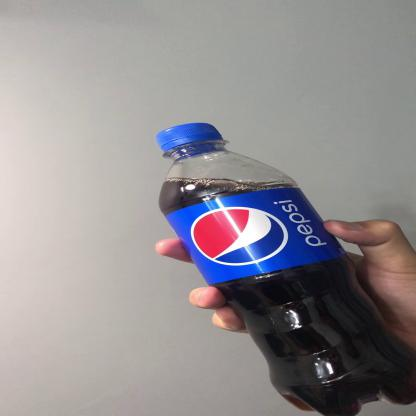



/content/test/Pepsi/3286_jpg.rf.65cca757b93fc5124da1d7e0984df3b8.jpg
Pepsi


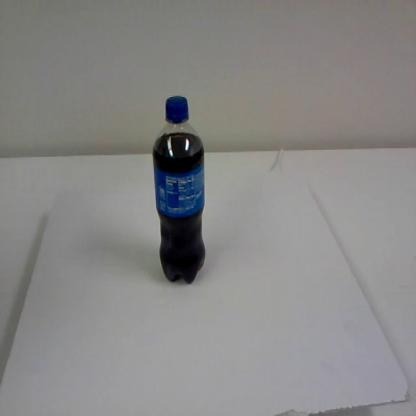



/content/test/Pepsi/2947_jpg.rf.38d7fa04704a3d5b7a9e3c366ab42591.jpg
Pepsi


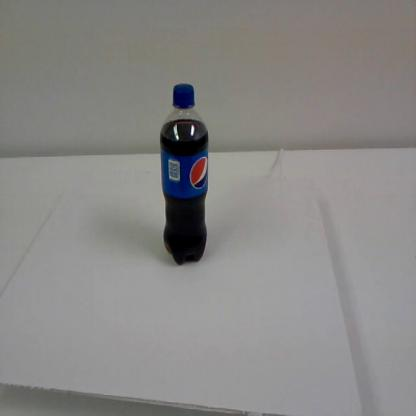



/content/test/Pepsi/4228_jpg.rf.8760fb2c8bd868ffb37d0782160a8c2f.jpg
Pepsi


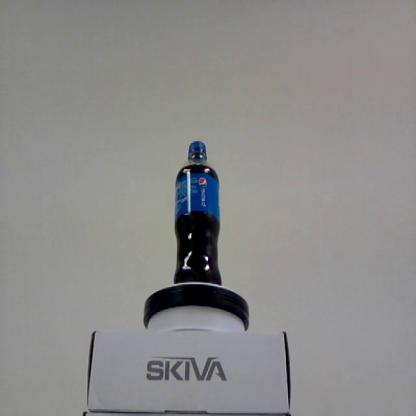



/content/test/Pepsi/3222_jpg.rf.d8c6e6a642fd86e5325d3dc81542597f.jpg
Pepsi


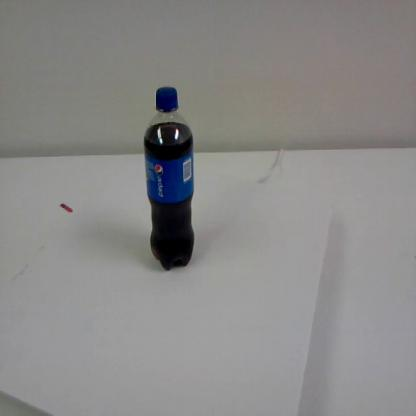



/content/test/Pepsi/IMG_5348_139_jpg.rf.cf4ea47e0649a788f7301942bfa1b194.jpg
Pepsi


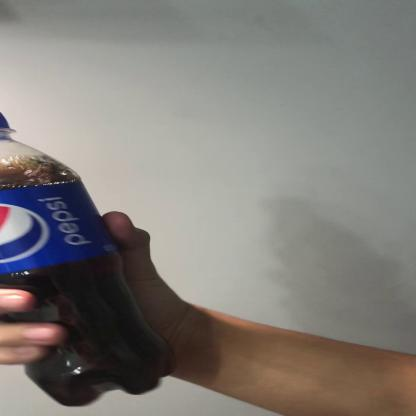



/content/test/Pepsi/3151_jpg.rf.bcb266bb60c94380bd1df71c4b3225fb.jpg
Pepsi


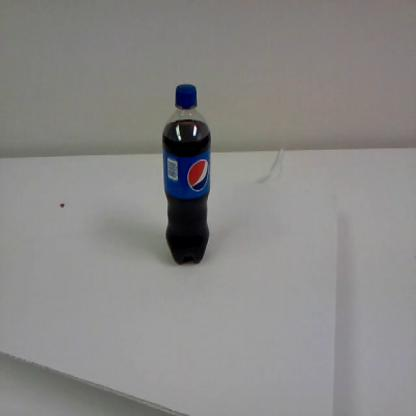



/content/test/Pepsi/3258_jpg.rf.b0794aa9f9aa2479a9486fbcdcd884e3.jpg
Pepsi


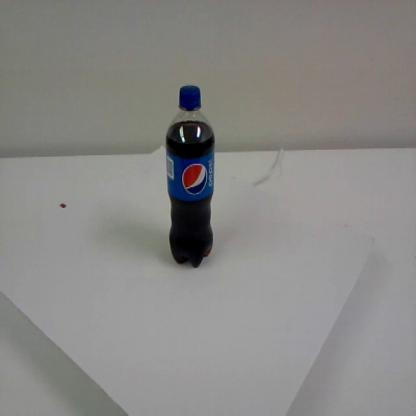



/content/test/Pepsi/6635_jpg.rf.631183c8a047ad571f67ed98749acccd.jpg
Pepsi


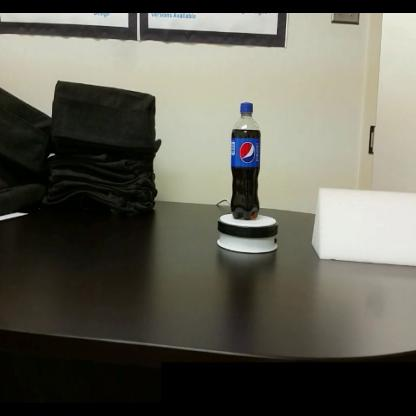



/content/test/Pepsi/6664_jpg.rf.ba6c67231940fd2a316b462fcfb3ca6a.jpg
Pepsi


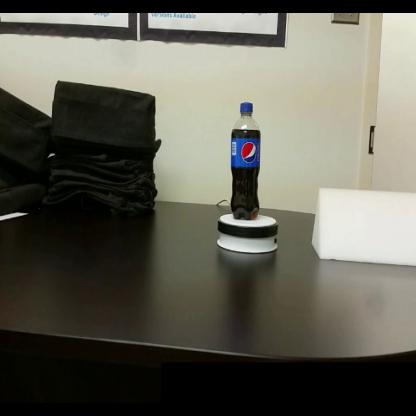



/content/test/Pepsi/2971_jpg.rf.1af1b5035e0d1cefeffba6f3a234c15c.jpg
Pepsi


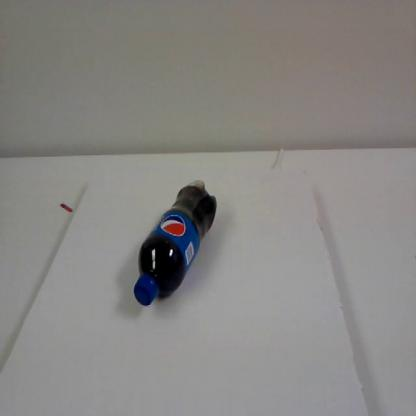



/content/test/Pepsi/IMG_5348_157_jpg.rf.1d8bea152bf17b81dedcab09a7fed3e4.jpg
Pepsi


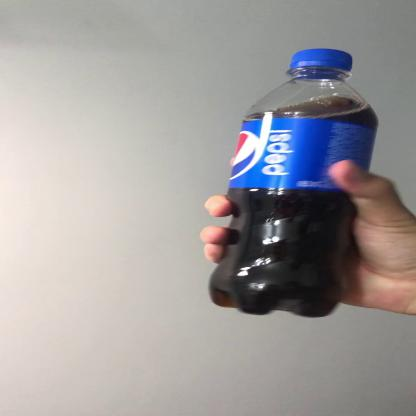



/content/test/Pepsi/6591_jpg.rf.03b4089ed069fecd2a567512d2d5f42e.jpg
Pepsi


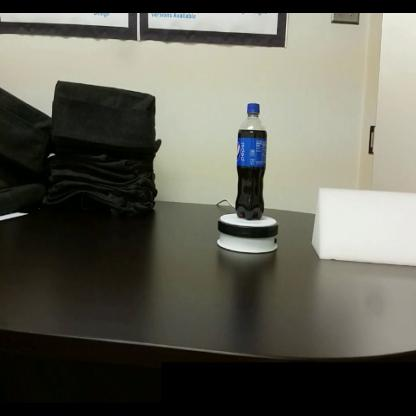



/content/test/Pepsi/3077_jpg.rf.cc7081624fee4e5d4191f453b5ce1807.jpg
Pepsi


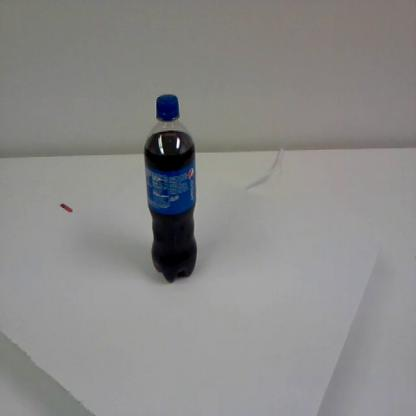



/content/test/Pepsi/IMG_5348_273_jpg.rf.0e32fc9e5281e325b1963744d911be10.jpg
Pepsi


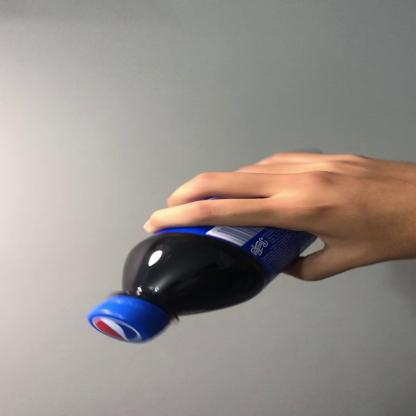



/content/test/Pepsi/IMG_5348_031_jpg.rf.8811b1c4ec887d4de7dfe078323f4192.jpg
Pepsi


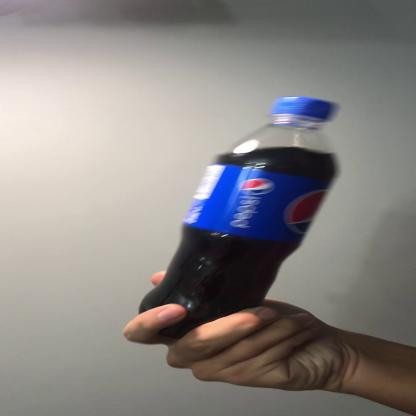



/content/test/Pepsi/IMG_5348_132_jpg.rf.645fc528a3cefaea8d72edb44222d8f8.jpg
Pepsi


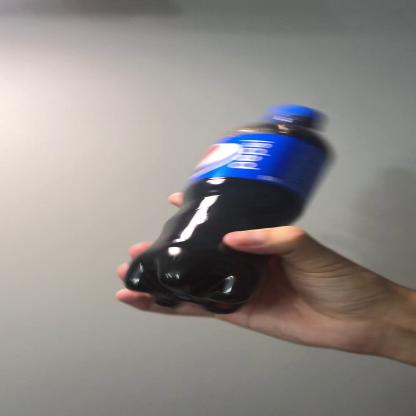



/content/test/Pepsi/3118_jpg.rf.ff3d73d5146acad84d691b2bcc9f2c7b.jpg
Pepsi


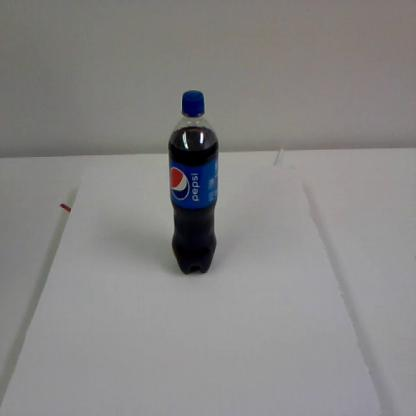



/content/test/Pepsi/2966_jpg.rf.321c2a225b81a2c5223494ca59a391c8.jpg
Pepsi


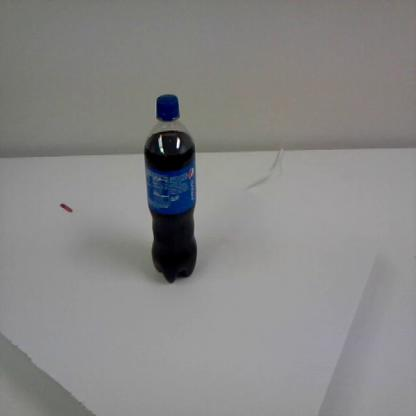



/content/test/Pepsi/3326_jpg.rf.fb99f0096196806ee184ce3613375438.jpg
Pepsi


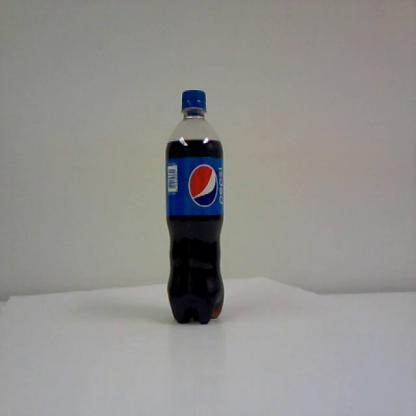



/content/test/Pepsi/6671_jpg.rf.c8e9432bc6138656f2f9232804f993c0.jpg
Pepsi


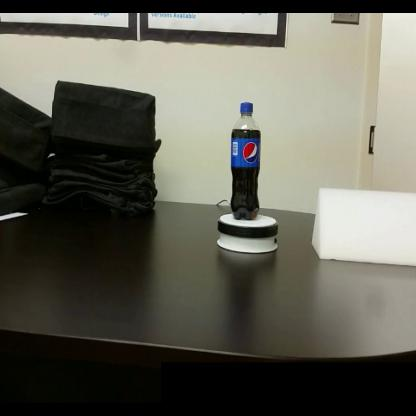



/content/test/Pepsi/4188_jpg.rf.5e3ab015f2e7ca4cf5a0dc170f832b6c.jpg
Pepsi


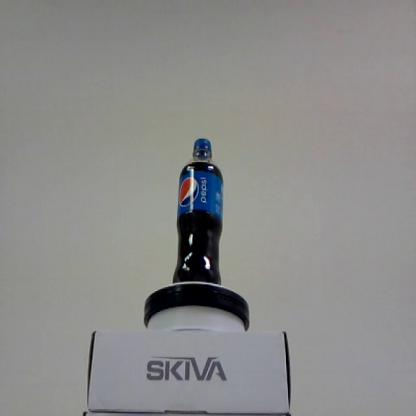



/content/test/Pepsi/IMG_5348_097_jpg.rf.b9628df3f88194d15e69ce51f6dc2d40.jpg
Pepsi


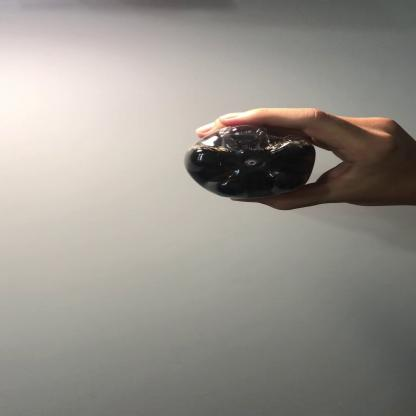



/content/test/Pepsi/6448_jpg.rf.bc519f79f21ab0d5cea6fbe4b56bae51.jpg
Pepsi


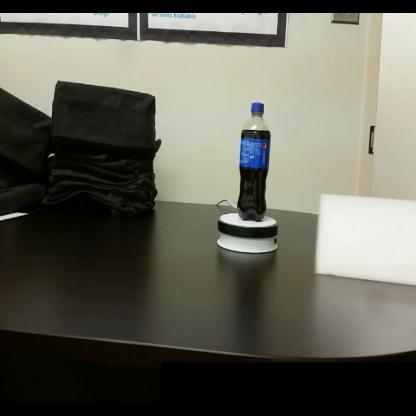



/content/test/Pepsi/6638_jpg.rf.d1ac54c2d49db2e6eb1d49f4362ad869.jpg
Pepsi


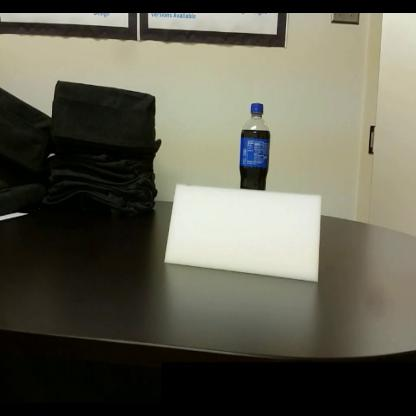



/content/test/Pepsi/3167_jpg.rf.2d17fe0692153a397d42fa24183edd13.jpg
Pepsi


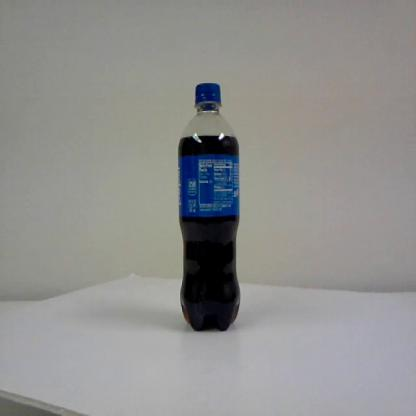



/content/test/Pepsi/4248_jpg.rf.ca3d6d43de72853c6b8994499414ff98.jpg
Pepsi


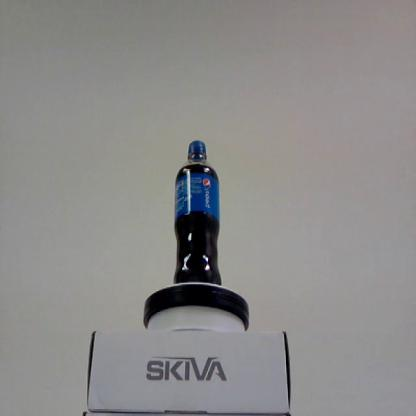



/content/test/Pepsi/6559_jpg.rf.d7e626664ee111f576900dad4c86c133.jpg
Pepsi


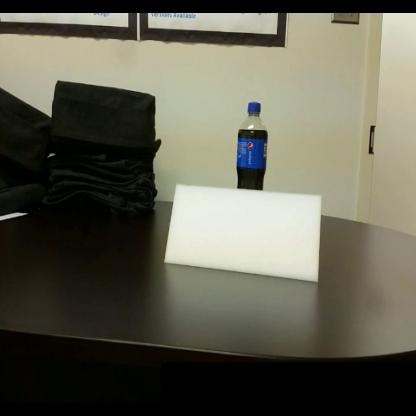



/content/test/Pepsi/3100_jpg.rf.9058f8d148b93f3c1a7f6ceb81153d83.jpg
Pepsi


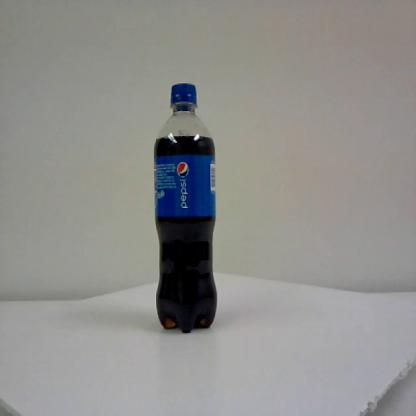



/content/test/Pepsi/IMG_5348_101_jpg.rf.8cbf92210ce9b86d5434c8fab1c0cd97.jpg
Pepsi


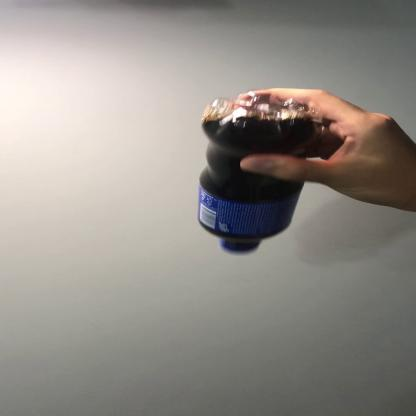



/content/test/Pepsi/6632_jpg.rf.70e02fbe1f73d27def713214582a9771.jpg
Pepsi


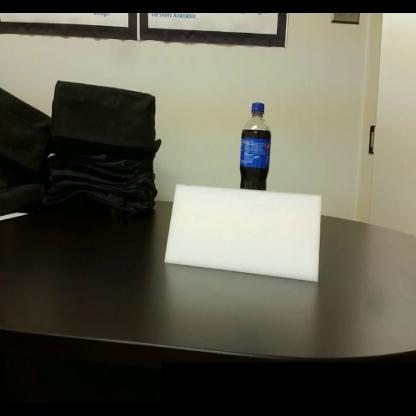



/content/test/Pepsi/3028_jpg.rf.9ed1b54115eb7d745e4436dd88358270.jpg
Pepsi


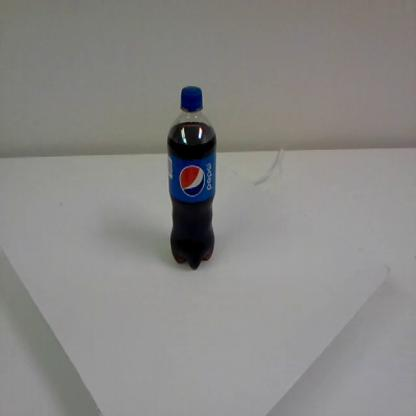



/content/test/Pepsi/IMG_5348_098_jpg.rf.81477b7da8c746036adfac1319b1f157.jpg
Pepsi


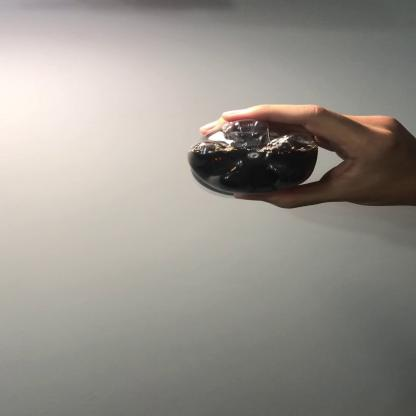



/content/test/Gin/IMG_5352_259_jpg.rf.120c3d467f20c1d22d9c5309eec34244.jpg
Gin


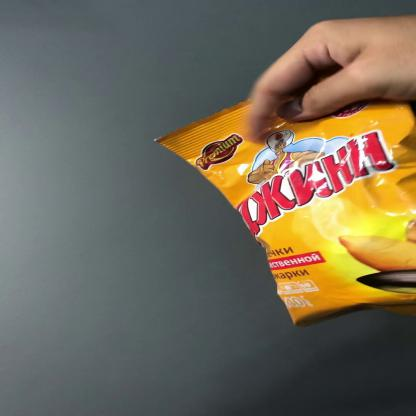



/content/test/Gin/IMG_5352_202_jpg.rf.9e29f3d4c8ffafa0647ee04ed849e05b.jpg
Gin


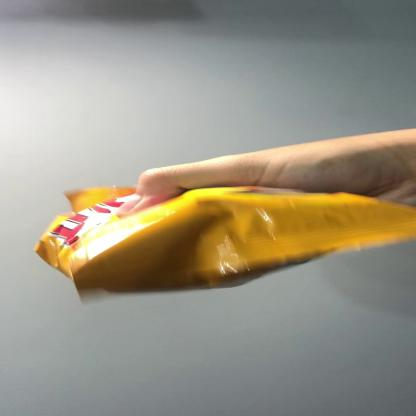



/content/test/Gin/IMG_5352_199_jpg.rf.d6155acd74b67a4af076c4b9aceebd8b.jpg
Gin


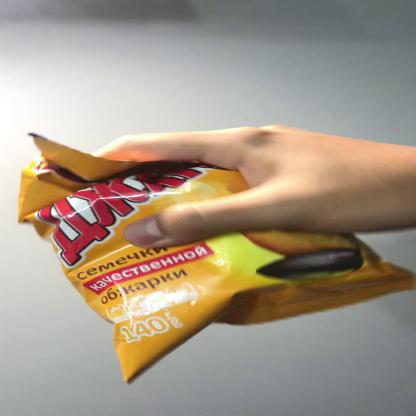



/content/test/Gin/images (19)_jpeg.rf.b6ebef7220c6b675d115d3d27a13a857.jpg
Gin


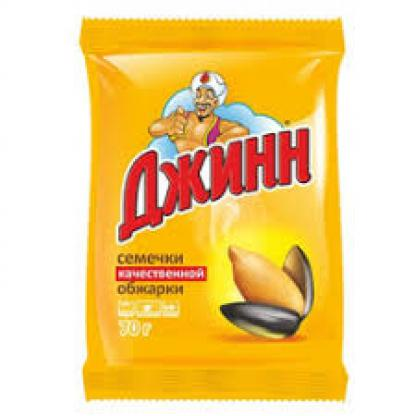



/content/test/Gin/IMG_5352_018_jpg.rf.515c44fc15c53ad8f197a890affef6ea.jpg
Gin


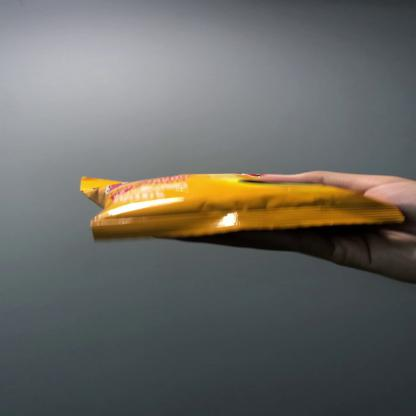



/content/test/Gin/250-gr_jpg.rf.b1903fec7c85e09413cec1c0281f72ac.jpg
Gin


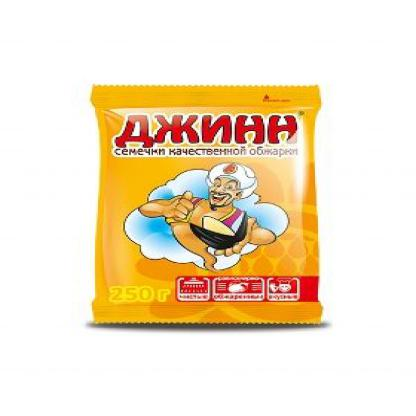



/content/test/Gin/IMG_5352_184_jpg.rf.32213c059183f143d14df4b0265ec3d8.jpg
Gin


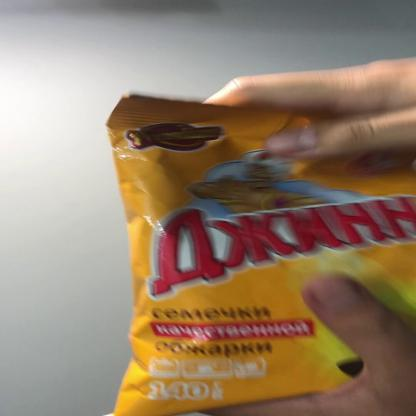



/content/test/Gin/IMG_5352_033_jpg.rf.f497449bb4d2c938d2da7000868da165.jpg
Gin


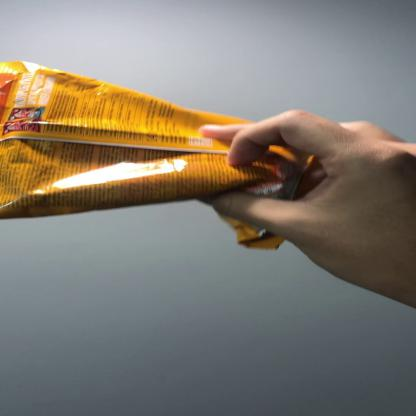



/content/test/Gin/image (1)_jpeg.rf.9f246d3769f47708d83ca5ac2575a90b.jpg
Gin


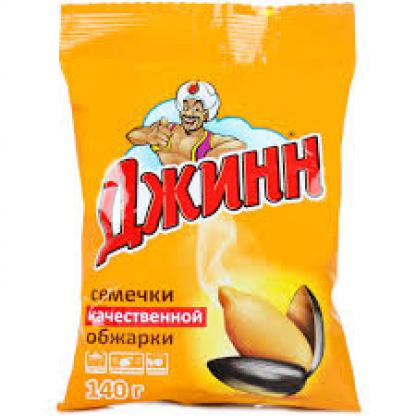



/content/test/Gin/images (61)_jpeg.rf.bbbbc98f00d77a4af66ce8f57c256378.jpg
Gin


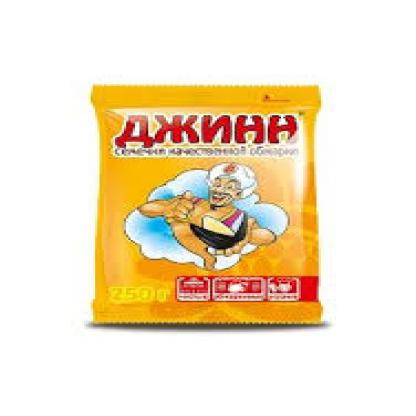



/content/test/Gin/IMG_5352_278_jpg.rf.ca90e4c0068f05b45305c2fc95426f86.jpg
Gin


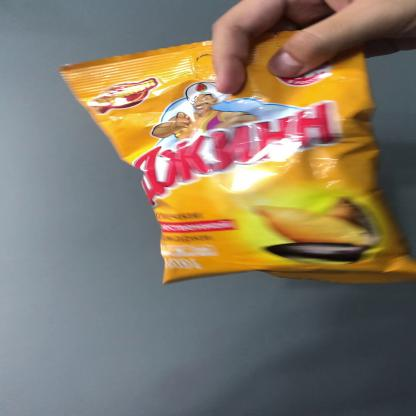



/content/test/Gin/images (162)_jpeg.rf.530c86436e6ef5337536ceca4a744549.jpg
Gin


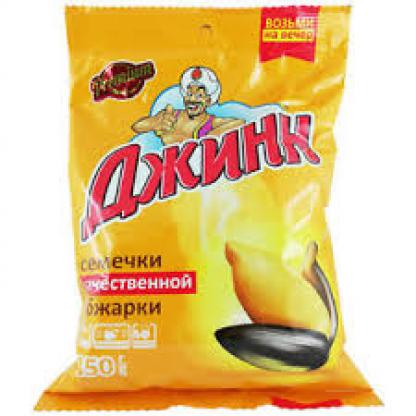



/content/test/Gin/154102-zharienyie-siemiechki-podsolnukha-240x180_png.rf.5a7496f9ec34a885d90c5ebe871b1365.jpg
Gin


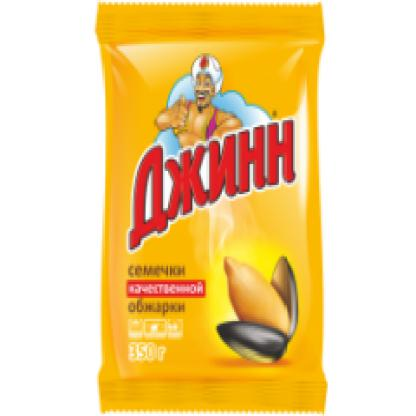



/content/test/Gin/IMG_5352_152_jpg.rf.1bda6cb84434cfceecc8b18ea047b8d0.jpg
Gin


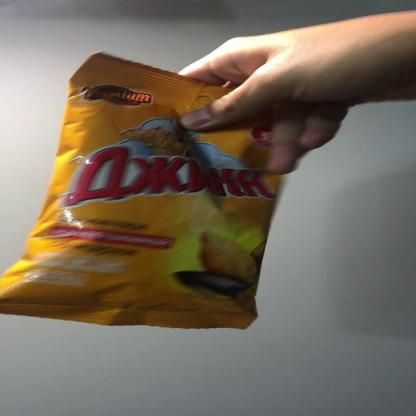



/content/test/Gin/IMG_5352_145_jpg.rf.bdd77af1de15199082d54f92ed60dddb.jpg
Gin


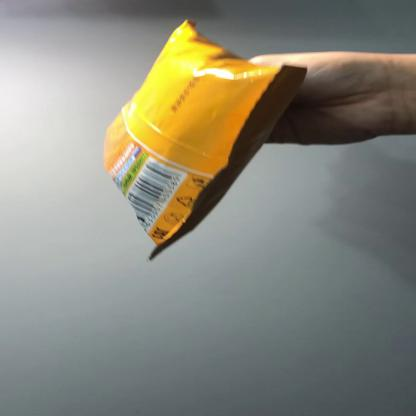



/content/test/Gin/images (102)_jpeg.rf.0619898de34eec2afe4545625ded4a63.jpg
Gin


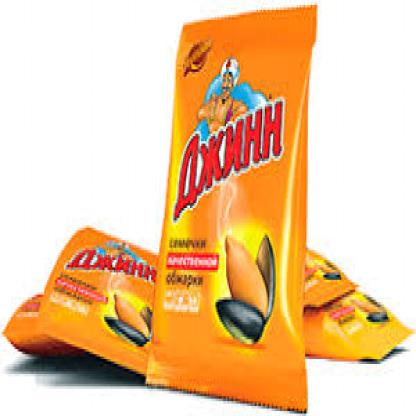



/content/test/Gin/IMG_5352_167_jpg.rf.2e0e132da7938af39d670b11c2fc2ee4.jpg
Gin


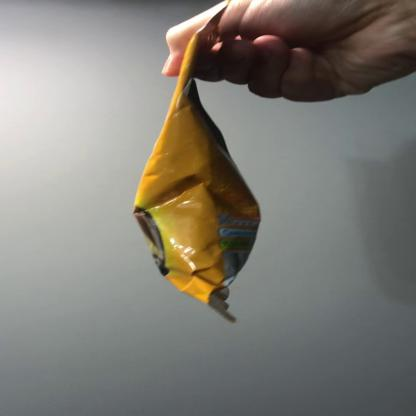



/content/test/Gin/293-970_jpeg.rf.64a6ca15e268c9409a53d63a41c1314a.jpg
Gin


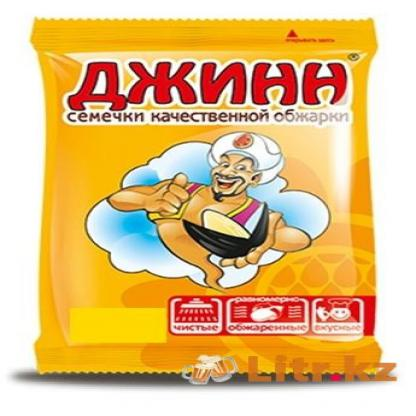



/content/test/Gin/IMG_5352_173_jpg.rf.d87a13e2aba5780017103f6d3db35500.jpg
Gin


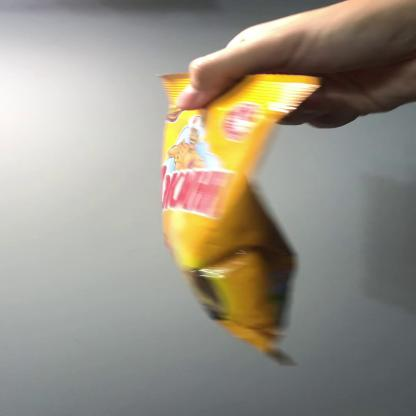



/content/test/Gin/IMG_5352_134_jpg.rf.647a0741e9ce1defe0efe9539d8758ba.jpg
Gin


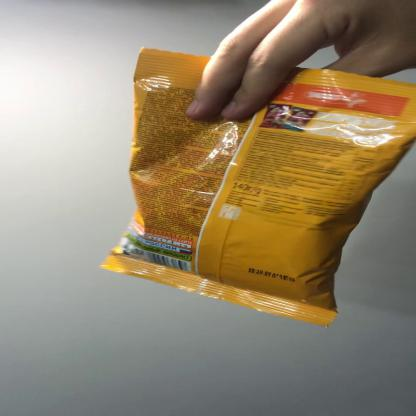



/content/test/Gin/IMG_5352_203_jpg.rf.50a4a0f384ec85a13fd586e4a9365551.jpg
Gin


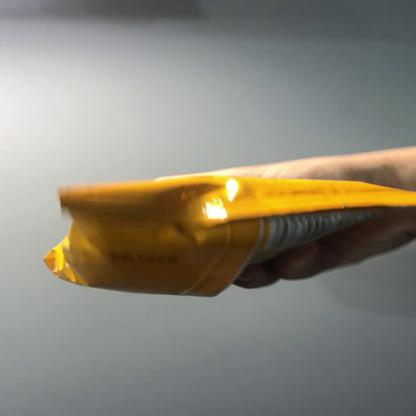



/content/test/Gin/IMG_5352_242_jpg.rf.dcc2c5ed327bcff6b778f6a57c8573a9.jpg
Gin


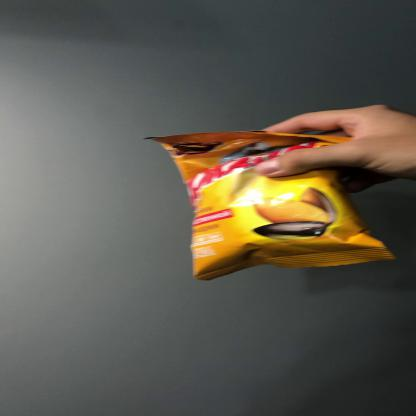



/content/test/Gin/images (94)_jpeg.rf.75337bedc1a9d26ba7b536bb75270a73.jpg
Gin


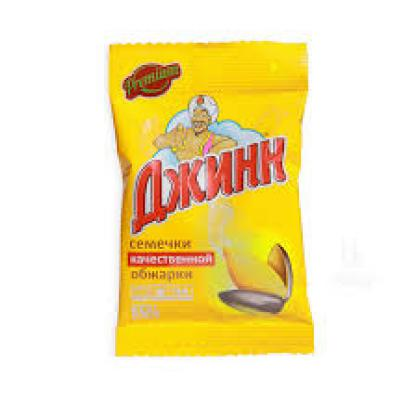



/content/test/Gin/IMG_5352_192_jpg.rf.2286cfdd55835d1b4de8f8fedfc7d15b.jpg
Gin


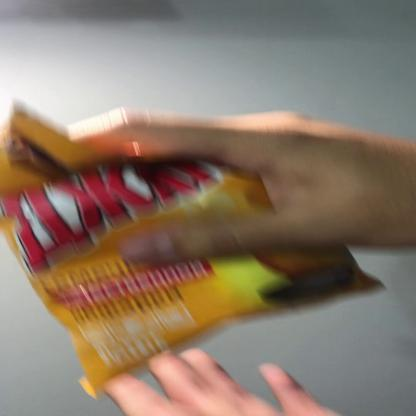



/content/test/Gin/IMG_5352_171_jpg.rf.89b33410ade0d121eb814ee5fb5c9e33.jpg
Gin


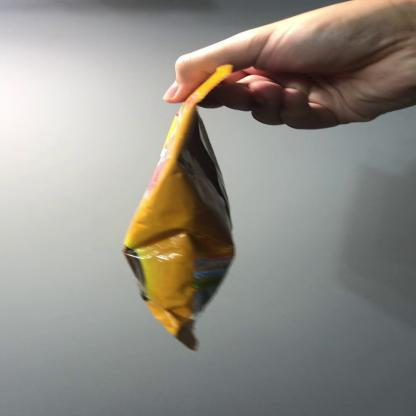



/content/test/Gin/image (8)_jpeg.rf.7e75aa6188e8d362a7d98b93fe9fdaaa.jpg
Gin


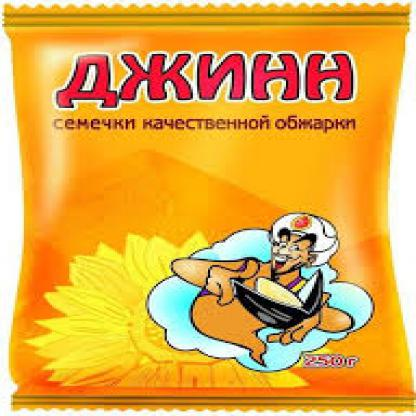



/content/test/Gin/images (128)_jpeg.rf.e7f5eb50eac673eea682c284b193388d.jpg
Gin


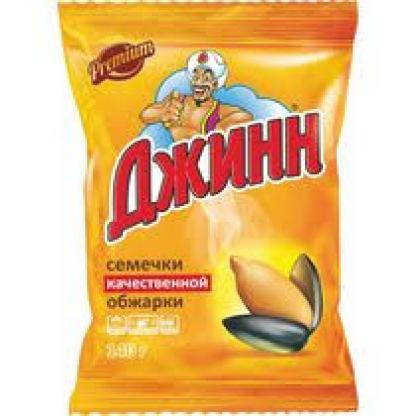



/content/test/Gin/IMG_5352_140_jpg.rf.4e2cf5c5bdbd93f619e2a990b50ce66f.jpg
Gin


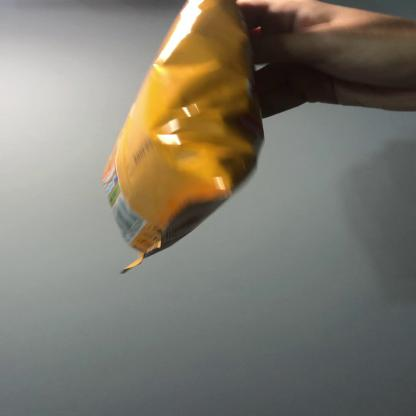



/content/test/Gin/IMG_5352_070_jpg.rf.646c6ab99d2dd38a061d72b7c0287c84.jpg
Gin


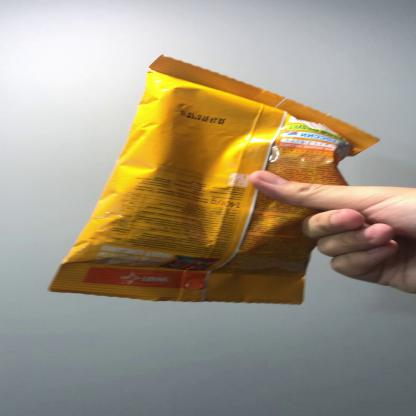



/content/test/Gin/IMG_5352_262_jpg.rf.359ff03fe2d6aabfaf713850be34ab08.jpg
Fanta


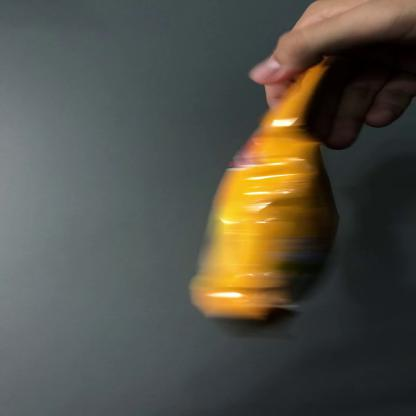



/content/test/Gin/images (160)_jpeg.rf.f79e43ac00fbf93869a2bb9352477ccf.jpg
Gin


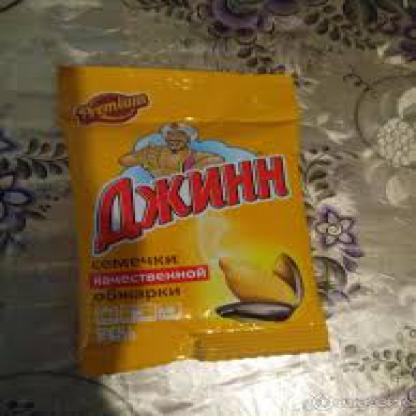



/content/test/Gin/images (54)_jpeg.rf.483466cf63ab0c7062b68f1a9c0cb235.jpg
Gin


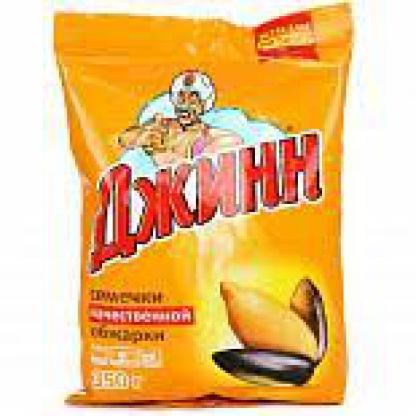



/content/test/Gin/IMG_5352_104_jpg.rf.9d9921bfdb0b9d96dc7cdb40e2795a44.jpg
Gin


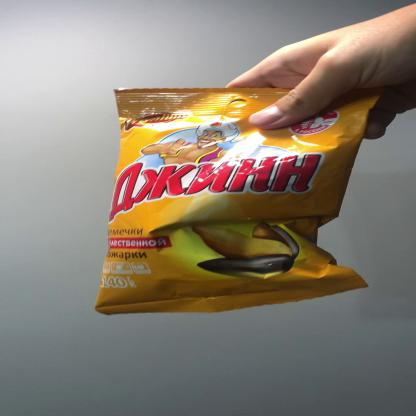



/content/test/Gin/images (38)_jpeg.rf.33ec20fe1eb40b4c6d1751b4c1b8c4ff.jpg
Gin


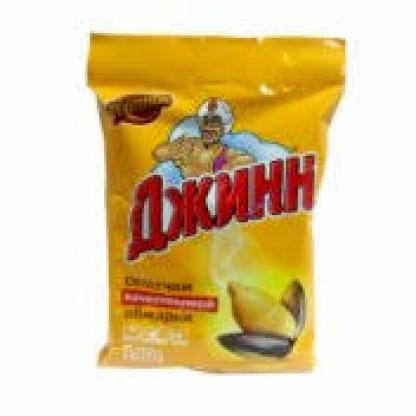



/content/test/Gin/images (32)_jpeg.rf.28a96011afc2e681131b3d60e3c97cd9.jpg
Gin


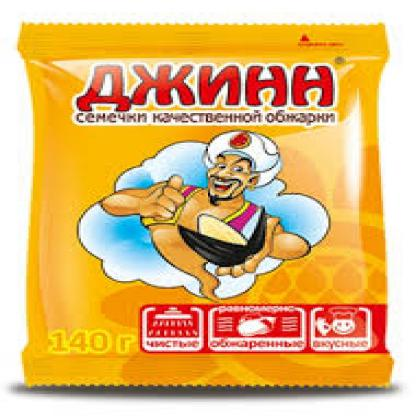



/content/test/Gin/IMG_5352_195_jpg.rf.201a5d6e3e6778ce6f312a361835d541.jpg
Gin


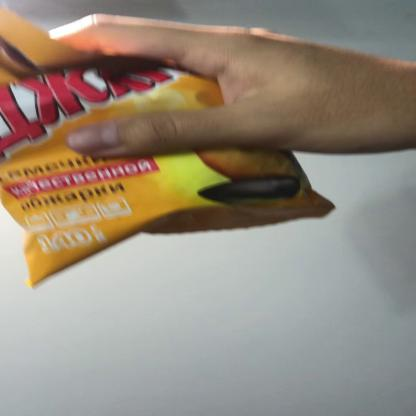



/content/test/Gin/images (9)_jpeg.rf.afcc356a42bd9f4ee6f2eb5f7ae0e572.jpg
Gin


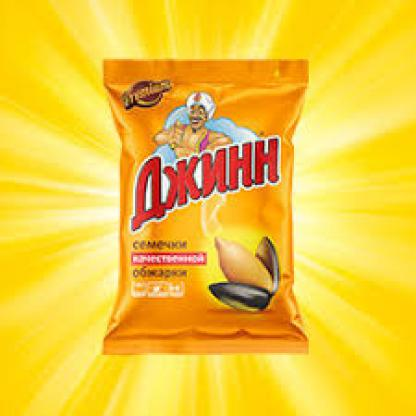



/content/test/Gin/IMG_5352_290_jpg.rf.b5894eba30ee220c2f5b9f221d5362b0.jpg
Gin


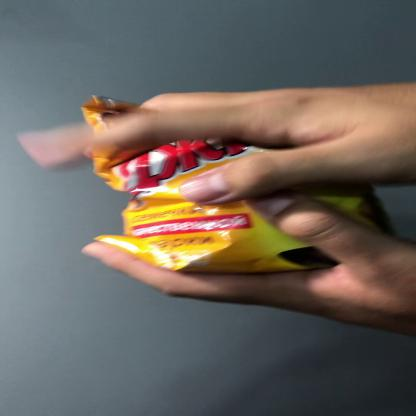



/content/test/Gin/IMG_5352_150_jpg.rf.b0e0f66e4dd7340115844ea504517803.jpg
Gin


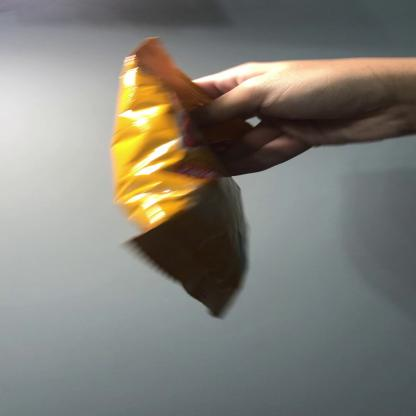



/content/test/Gin/IMG_5352_265_jpg.rf.96563f333b4d214f82cf2a4bfaa10714.jpg
Gin


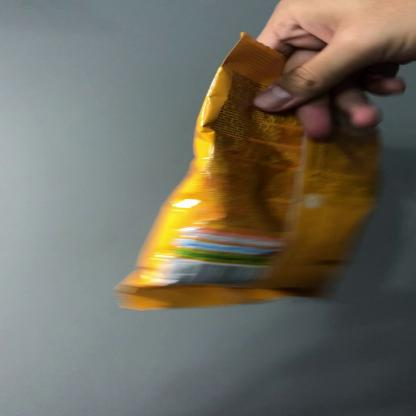



/content/test/Gin/IMG_5352_233_jpg.rf.7d56accf160a9e842aecf98d81913270.jpg
Gin


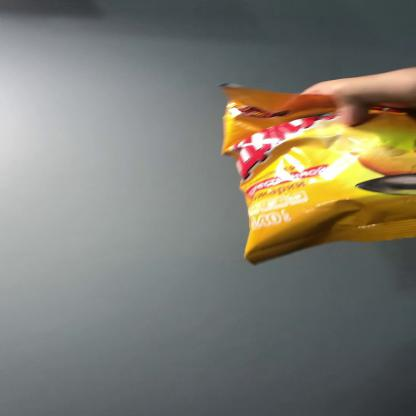



/content/test/Kitkat/IMG_5351_037_jpg.rf.60aaf05f4b5321f40b4247a473aacebc.jpg
Kitkat


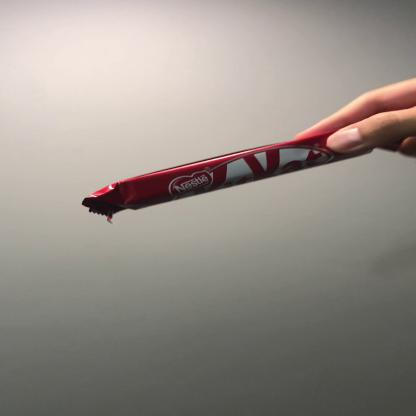



/content/test/Kitkat/IMG_5351_159_jpg.rf.f77e8238c34e2bdbb6b12bd78a06b027.jpg
Kitkat


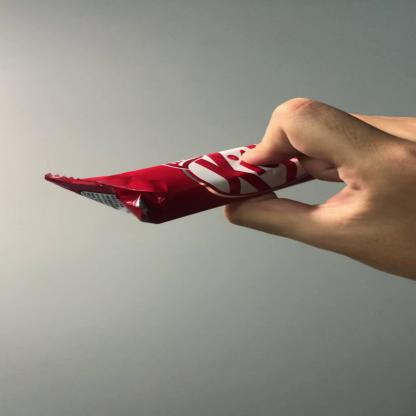



/content/test/Kitkat/IMG_5351_120_jpg.rf.7868cda6853ea6aac260d59c0318714b.jpg
Kitkat


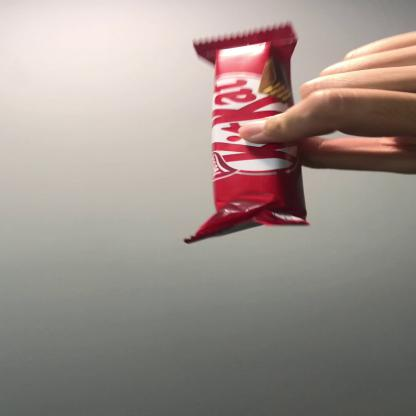



/content/test/Kitkat/IMG_5351_033_jpg.rf.00a269191ccc09ae89ac53c329541e4d.jpg
Kitkat


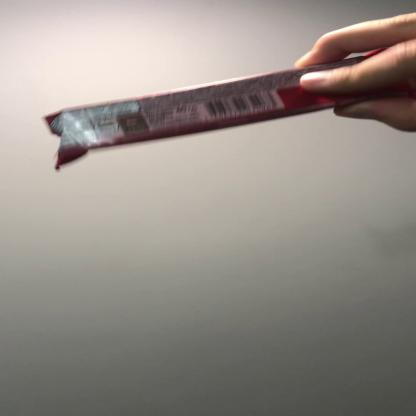



/content/test/Kitkat/IMG_5351_086_jpg.rf.0cc792937e2587218971765022978e2a.jpg
Kitkat


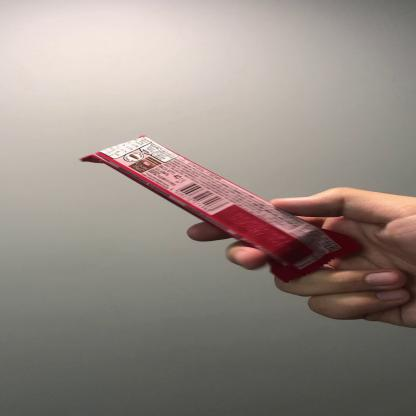



/content/test/Kitkat/images (90)_jpeg.rf.3ac33b0f52cdeeb9db610eb3221b8bda.jpg
Kitkat


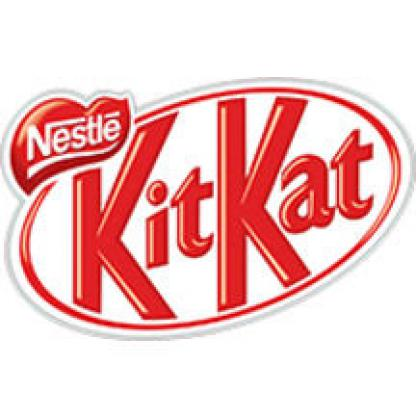



/content/test/Kitkat/IMG_5351_218_jpg.rf.f249fa2094e2a729ec521c9c1d83c89e.jpg
Kitkat


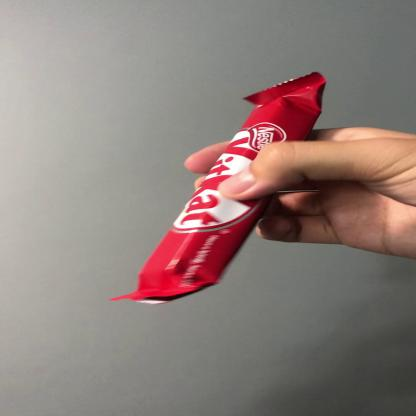



/content/test/Kitkat/images (5)_png.rf.317bf4a366013701c33b3a379912be9e.jpg
Kitkat


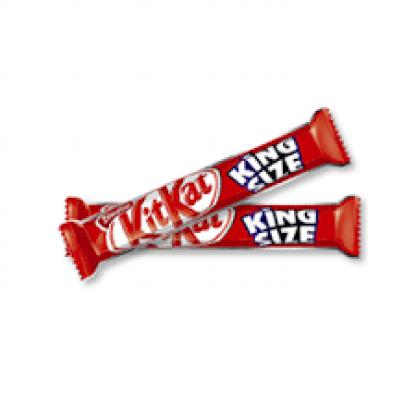



/content/test/Kitkat/IMG_5351_072_jpg.rf.24e8b2846939ed3600fda3ccaf7200ae.jpg
Kitkat


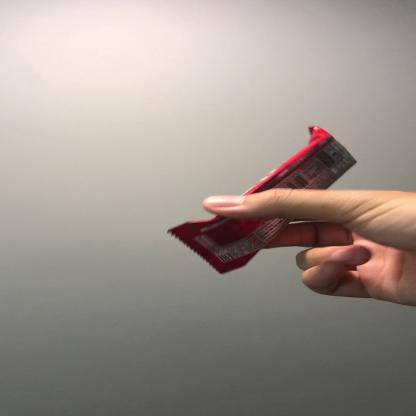



/content/test/Kitkat/IMG_5351_254_jpg.rf.647ed67d1e0aa0d7ab6deea756991249.jpg
Kitkat


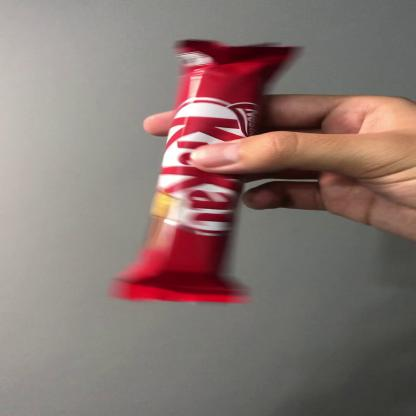



/content/test/Kitkat/IMG_5351_258_jpg.rf.2f10bbf9cd379ad7a78dca54dfa4467e.jpg
Kitkat


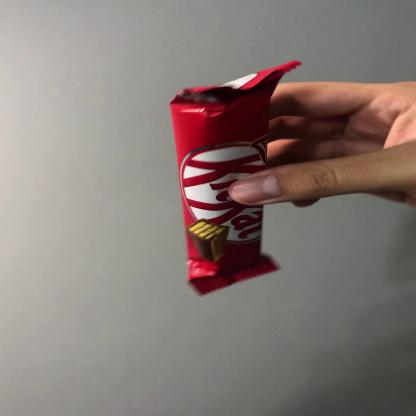



/content/test/Kitkat/images (44)_jpeg.rf.018211e796e7d6e333de5398fbc7b30e.jpg
Kitkat


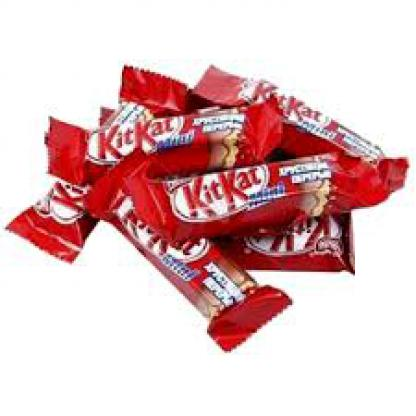



/content/test/Kitkat/images (70)_jpeg.rf.e13ca0f7e9b90e2e0313b91de3316a4c.jpg
Kitkat


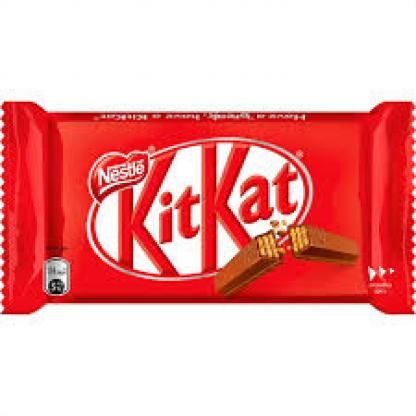



/content/test/Kitkat/download (10)_jpeg.rf.3afecaf4e35f7cecd9ff4bb2c3b70133.jpg
Kitkat


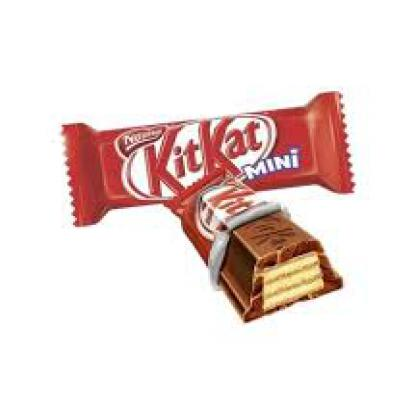



/content/test/Kitkat/IMG_5351_264_jpg.rf.97ae233266e6dadb7955fdb9403ed123.jpg
Kitkat


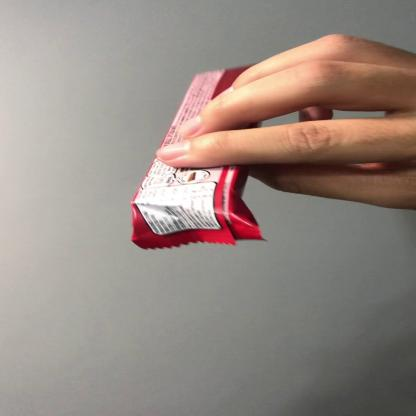



/content/test/Kitkat/IMG_5351_038_jpg.rf.fced82044b5db264e382cf5f028e0441.jpg
Kitkat


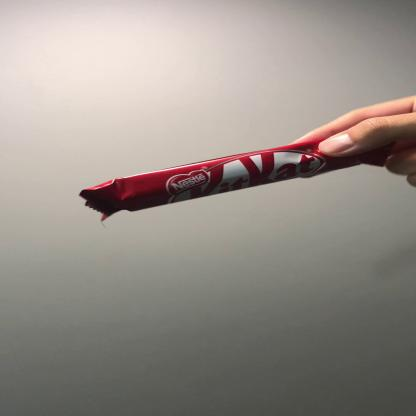



/content/test/Kitkat/download_jpeg.rf.6f03051ae80334d22dfa5a81d7cf2dfc.jpg
Kitkat


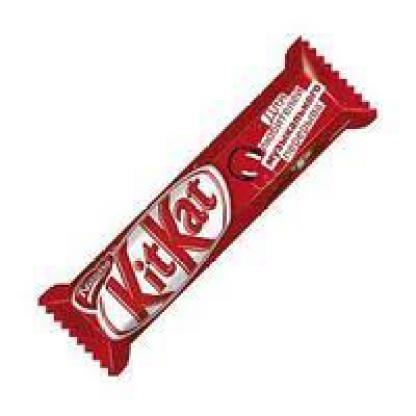



/content/test/Kitkat/IMG_5351_133_jpg.rf.610a54feb08629ec98b10893dc72f6ec.jpg
Kitkat


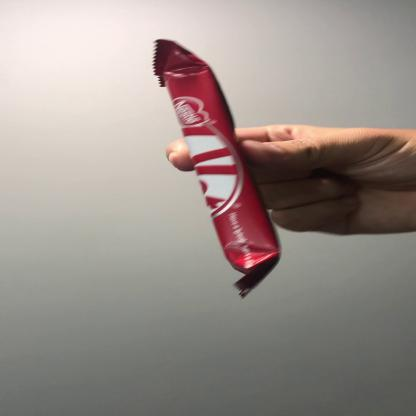



/content/test/Kitkat/images (62)_jpeg.rf.41fb3a22ef0f7368bb8a6c3ac424cae0.jpg
Kitkat


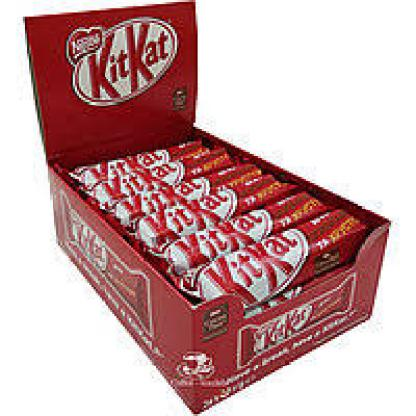



/content/test/Kitkat/IMG_5351_109_jpg.rf.8bc2d4a47bfc24c9c70153d07fa8f7ce.jpg
Kitkat


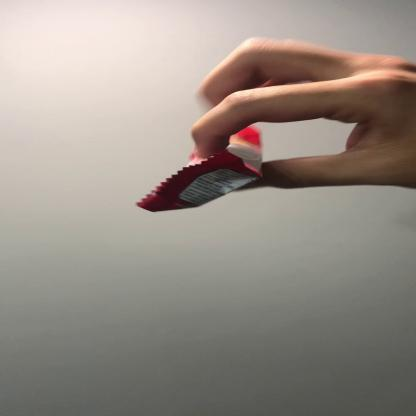



/content/test/Kitkat/IMG_5351_154_jpg.rf.d84e256117a72f49b6562714a2b11eb4.jpg
Kitkat


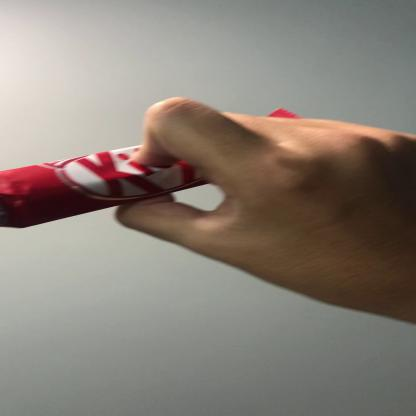



/content/test/Kitkat/IMG_5351_226_jpg.rf.bb8cd5ec6c85b8403be722e255c169a6.jpg
Kitkat


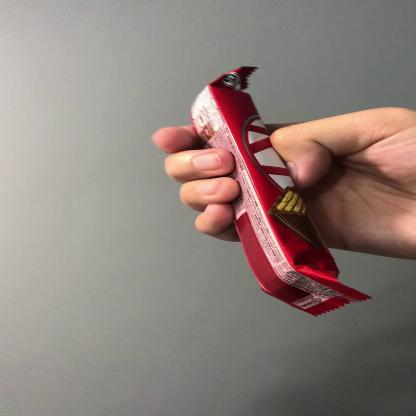



/content/test/Kitkat/IMG_5351_103_jpg.rf.83fe9687c95a5fae62d1b5ca771b53a4.jpg
Kitkat


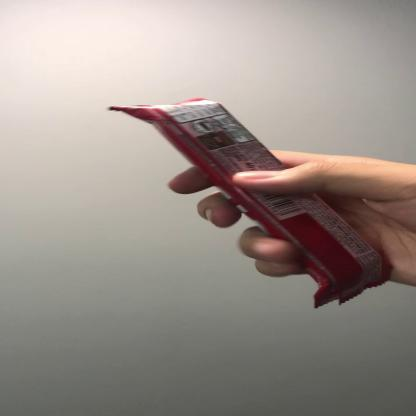



/content/test/Kitkat/IMG_5351_112_jpg.rf.2fe195656f6db7df81561361e60de381.jpg
Kitkat


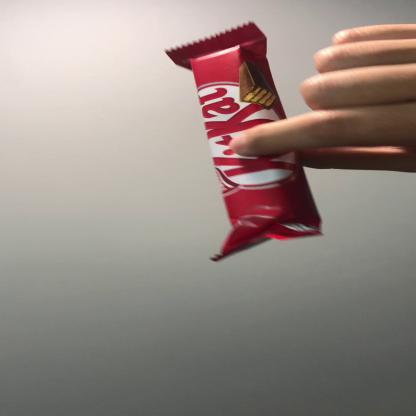



/content/test/Kitkat/images - 2020-11-11T182253-320_jpeg.rf.746e7eeb15bf1e0bd3ee8b3b887570b9.jpg
Kitkat


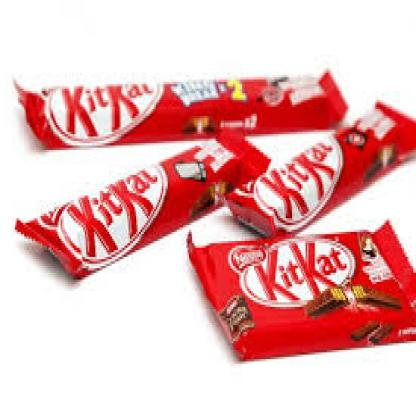



/content/test/Kitkat/images (7)_png.rf.3d267aab626890807efdad06360b5f11.jpg
Kitkat


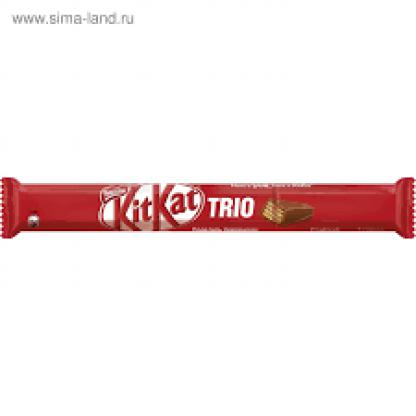



/content/test/Kitkat/IMG_5351_127_jpg.rf.770202ae49025f41d29aeff90d486bd5.jpg
Kitkat


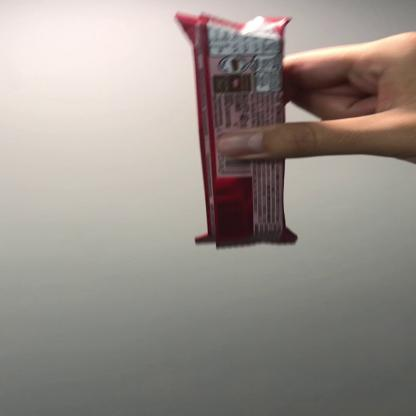



/content/test/Kitkat/IMG_5351_111_jpg.rf.e065b334b96986bdc37569ce5c43ab9a.jpg
Kitkat


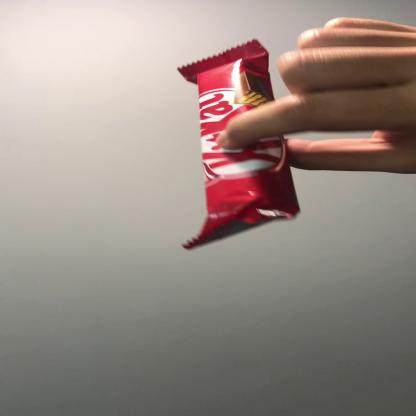



/content/test/Kitkat/IMG_5351_118_jpg.rf.3058a9a5f0fa7c7965031e3b410d2a5c.jpg
Kitkat


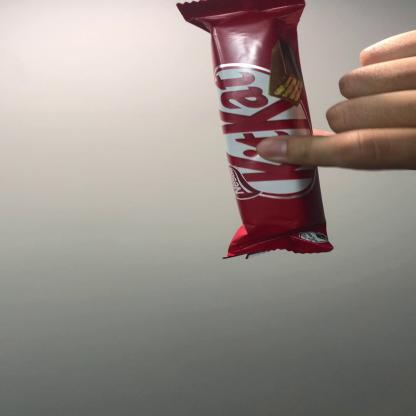



/content/test/Kitkat/IMG_5351_228_jpg.rf.14b53bd1cfb212d18f56ea1e953863c0.jpg
Kitkat


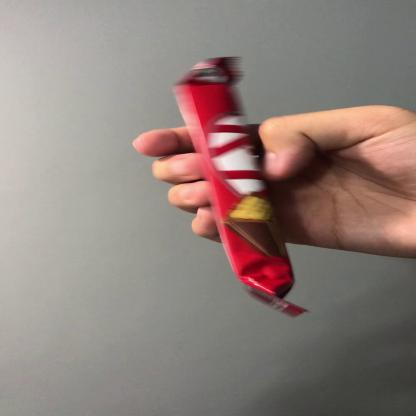



/content/test/Kitkat/IMG_5351_262_jpg.rf.6141d603f05130b98558c2f12a0758d8.jpg
Kitkat


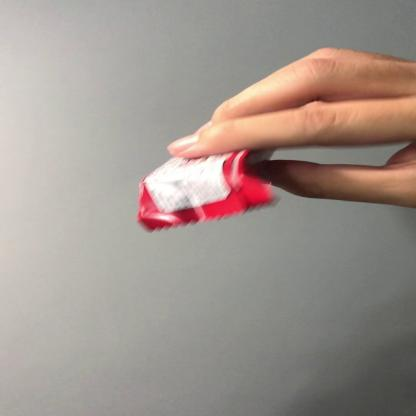



/content/test/Kitkat/IMG_5351_088_jpg.rf.65d0ba823da919d0e5e11c97ac07d2ec.jpg
Kitkat


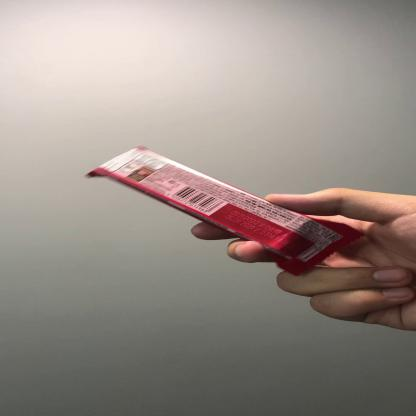



/content/test/Kitkat/IMG_5351_221_jpg.rf.2126433ff47094bd4c76649dfd6cec1b.jpg
Kitkat


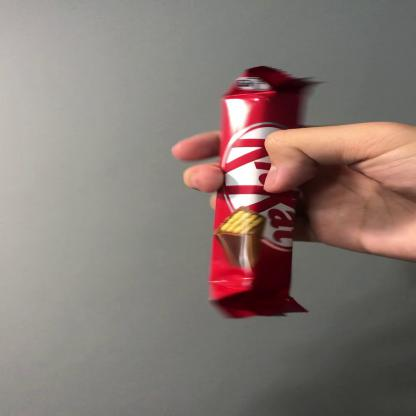



/content/test/Kitkat/IMG_5351_153_jpg.rf.c4658aa9c399e65c010a25d787d2b7ee.jpg
Kitkat


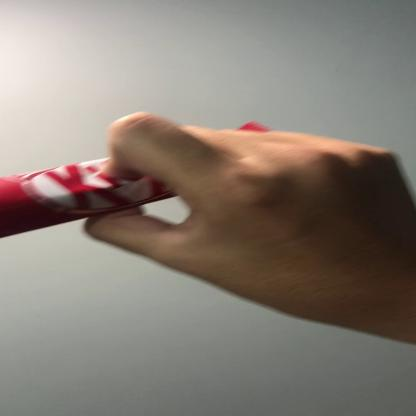



/content/test/Kitkat/IMG_5351_132_jpg.rf.599fc00fd15405ec1b6f20618d59d441.jpg
Kitkat


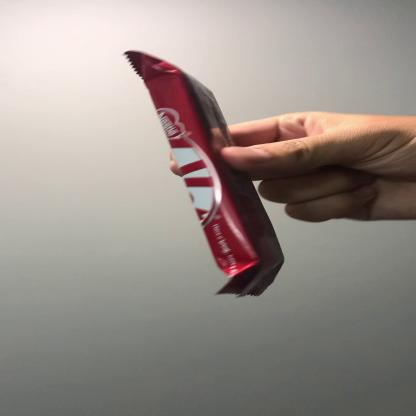



/content/test/Kitkat/IMG_5351_082_jpg.rf.28c651e5dfe0d5382a06412bbfded5ef.jpg
Kitkat


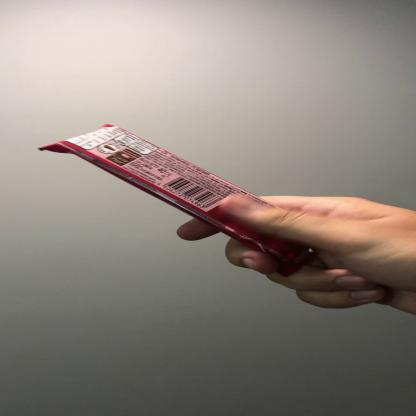



/content/test/Kitkat/IMG_5351_020_jpg.rf.757868d6c9aac92e8ed1f69d304fa560.jpg
Kitkat


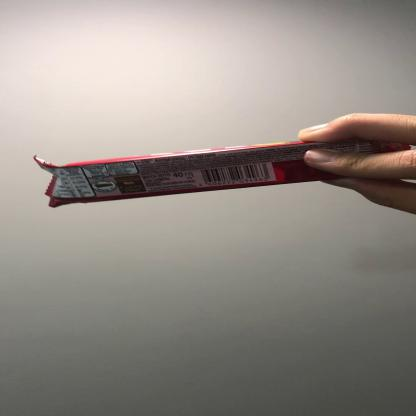



/content/test/Chocolate/IMG_5353_122_jpg.rf.bbe1e1459903f7a18833613bea3f596a.jpg
Chocolate


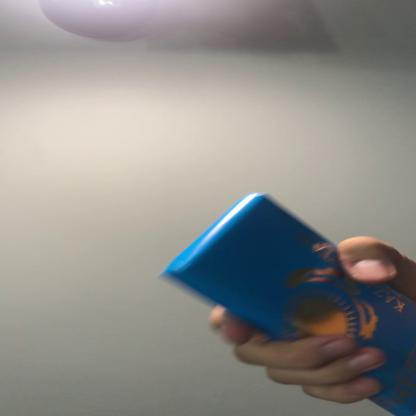



/content/test/Chocolate/IMG_5353_267_jpg.rf.9a2bf6fda58aaf5a6ff41aab683d3974.jpg
Chocolate


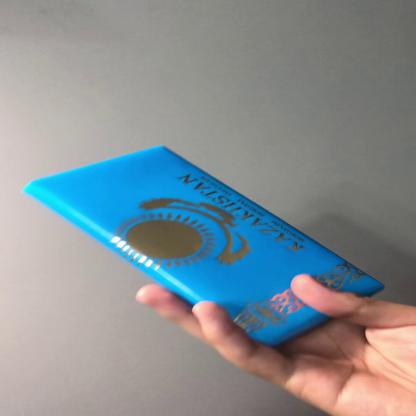



/content/test/Chocolate/IMG_5353_273_jpg.rf.7bf87f20ce418fafeb759efdfdf8e78c.jpg
Chocolate


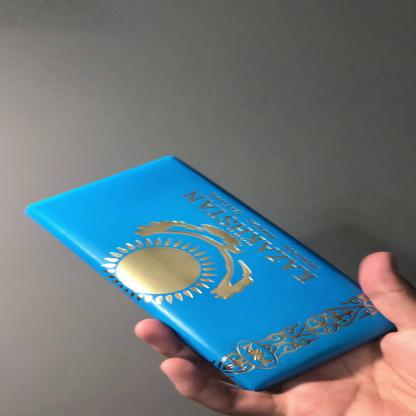



/content/test/Chocolate/IMG_5353_039_jpg.rf.d1aa0ca0e30cac7d792d92ededbd596f.jpg
Chocolate


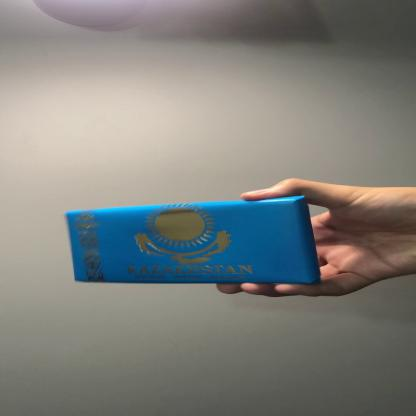



/content/test/Chocolate/IMG_5353_083_jpg.rf.31a5379661a707baffdb989354db1c01.jpg
Chocolate


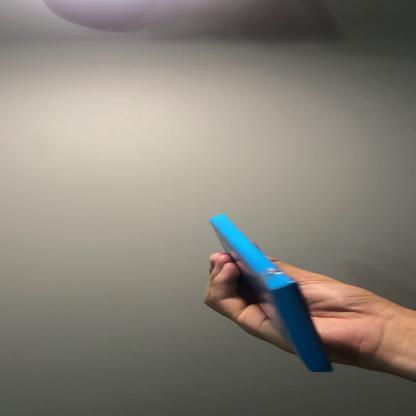



/content/test/Chocolate/IMG_5353_225_jpg.rf.a6443ea5eeaf1b51b67daa0cc096d3bf.jpg
Chocolate


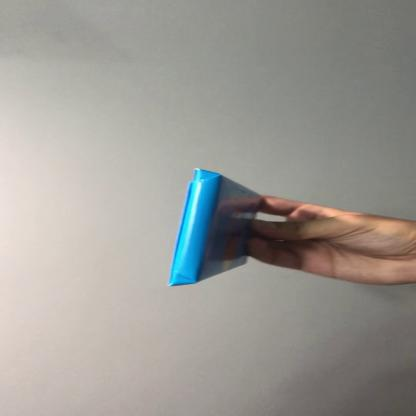



/content/test/Chocolate/IMG_5353_298_jpg.rf.09ea7275870012abff6c32d80338b677.jpg
Chocolate


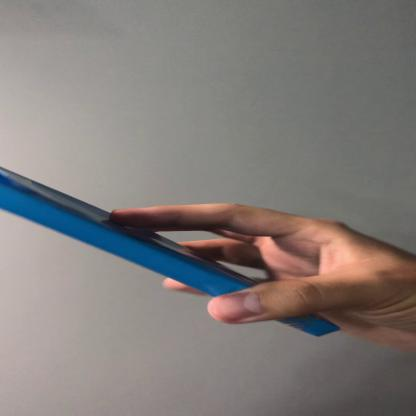



/content/test/Chocolate/IMG_5353_262_jpg.rf.b1d3856e2d60967b1ae03c9717cd076e.jpg
Chocolate


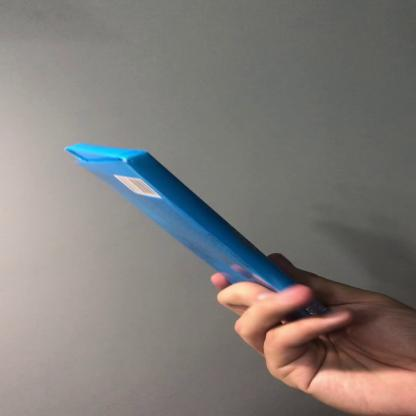



/content/test/Chocolate/IMG_5353_169_jpg.rf.79bb2771645646273d148211cf576bb7.jpg
Chocolate


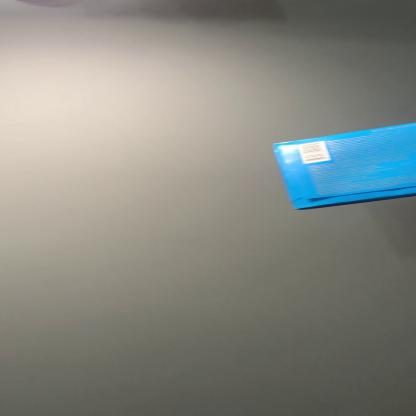



/content/test/Chocolate/IMG_5353_153_jpg.rf.d701f2e5922d29b027e2b4bdf4f1fd8b.jpg
Chocolate


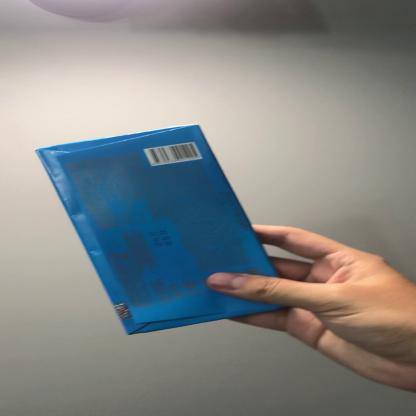



/content/test/Chocolate/IMG_5353_281_jpg.rf.bda56fff958817236864db6d236e4763.jpg
Chocolate


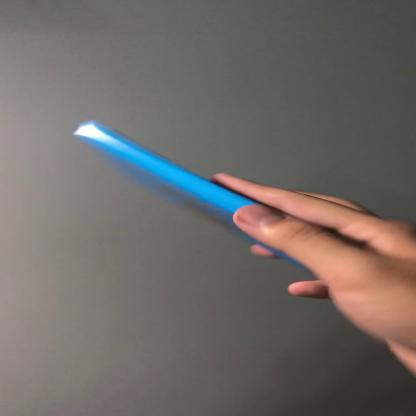



/content/test/Chocolate/IMG_5353_239_jpg.rf.df75efc32176f83a496f0c1223156301.jpg
Chocolate


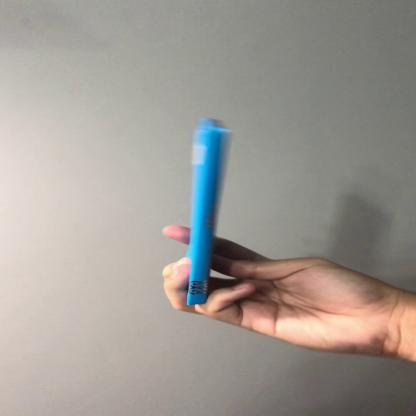



/content/test/Chocolate/IMG_5353_212_jpg.rf.34b9efb9104b5bc53f877c8a2b25931a.jpg
Chocolate


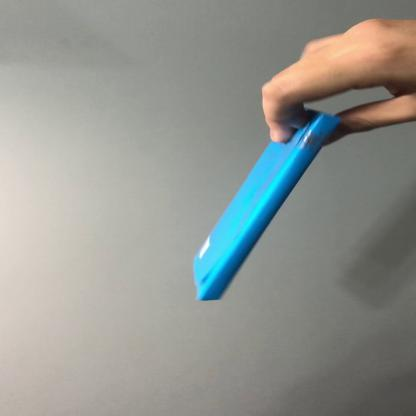



/content/test/Chocolate/images (94)_jpeg.rf.97f4f0b8b5bb619019ed252398f3cf72.jpg
Chocolate


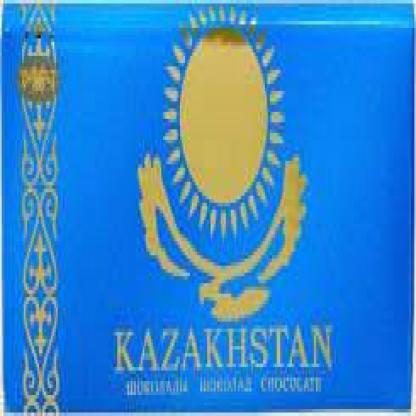



/content/test/Chocolate/IMG_5353_261_jpg.rf.0e8a05f54d470f0666b71fd64f44fae5.jpg
Chocolate


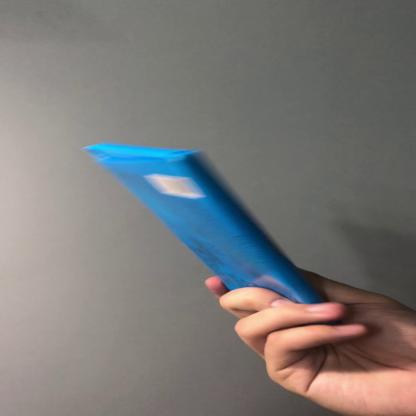



/content/test/Chocolate/IMG_5353_049_jpg.rf.2b26b47c1d0d9da7834c44b510fc397c.jpg
Chocolate


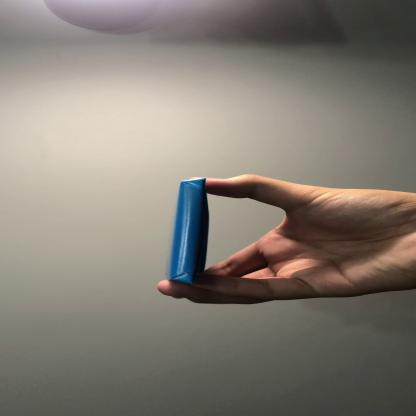



/content/test/Chocolate/IMG_5353_085_jpg.rf.458d4665fb9a2845c417132e541b55f1.jpg
Chocolate


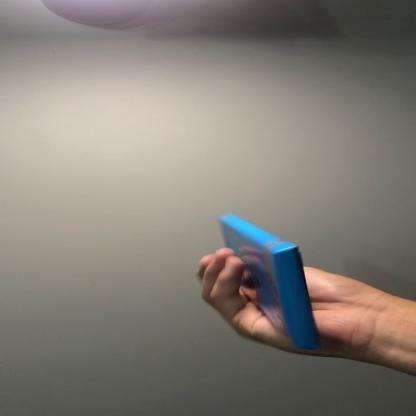



/content/test/Chocolate/IMG_5353_242_jpg.rf.c40c27bda8916fbb3aa9458a9fee83e8.jpg
Chocolate


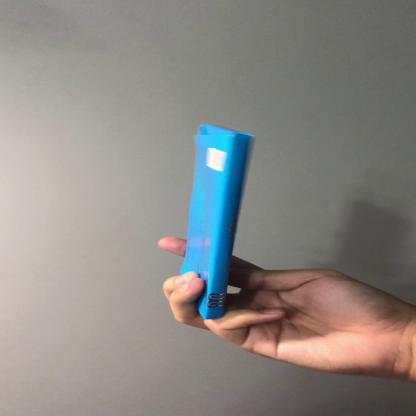



/content/test/Chocolate/images (89)_jpeg.rf.cbbb57837143b75d263b43144ea2e128.jpg
Chocolate


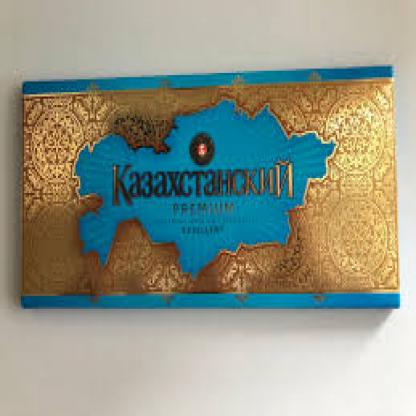



/content/test/Chocolate/IMG_5353_259_jpg.rf.52801e48db52ed752996fa34f561fab9.jpg
Chocolate


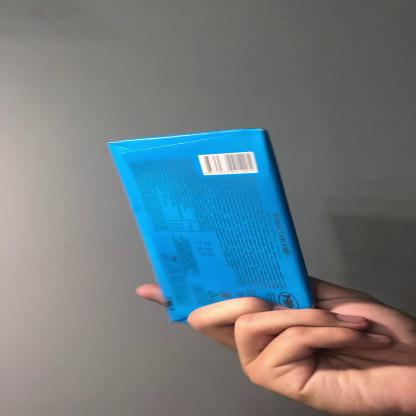



/content/test/Chocolate/IMG_5353_027_jpg.rf.121b5b4199ee0668831dac8cece237c1.jpg
Chocolate


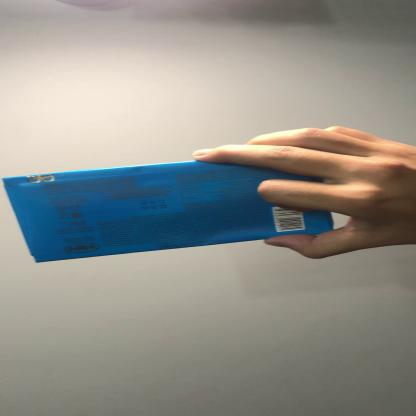



/content/test/Chocolate/IMG_5353_245_jpg.rf.c2e5728990cbc76d3304e1a31fbbf644.jpg
Chocolate


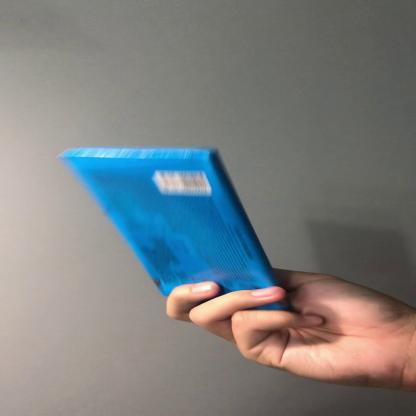



/content/test/Chocolate/IMG_5353_215_jpg.rf.2376bcb1b7457d37ca4f41bfaa35f5b5.jpg
Chocolate


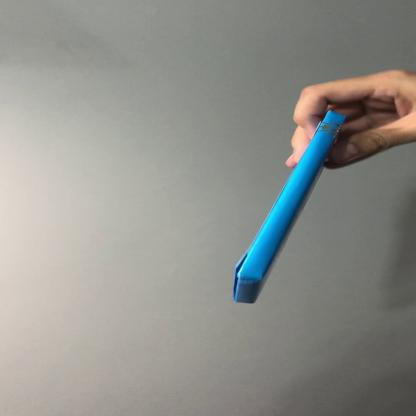



/content/test/Chocolate/IMG_5353_033_jpg.rf.31b9635030be7988fe6e9e21be45054a.jpg
Chocolate


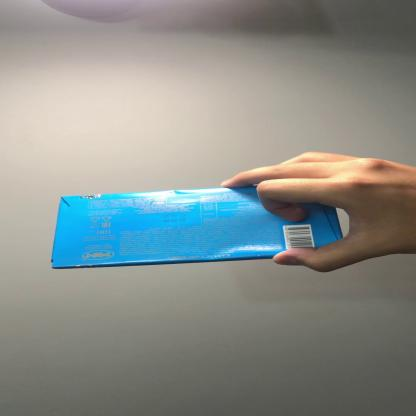



/content/test/Chocolate/IMG_5353_075_jpg.rf.347a4fe9d3562eda2efdacd7aded51c3.jpg
Chocolate


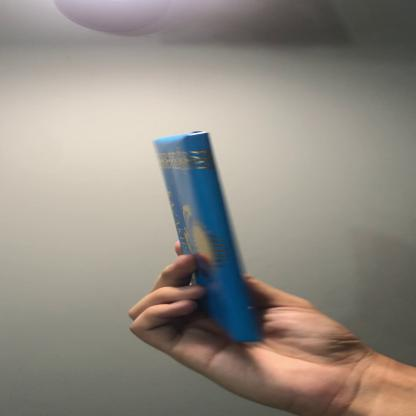



/content/test/Chocolate/IMG_5353_257_jpg.rf.babc48a5eb83d992248042a153c76ca3.jpg
Chocolate


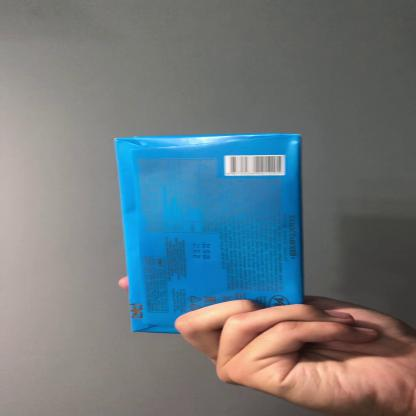



/content/test/Chocolate/images (21)_jpeg.rf.2e109ab802d50136bd6c1945d08ea007.jpg
Chocolate


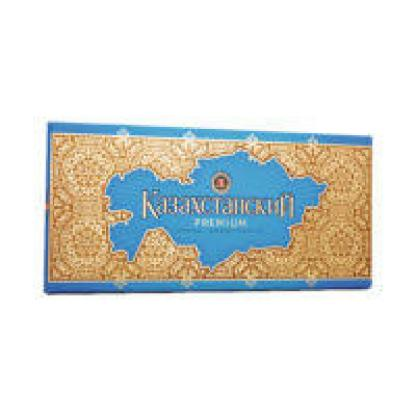



/content/test/Chocolate/IMG_5353_191_jpg.rf.9a2282f96ca3e9736490f6d8384a1807.jpg
Chocolate


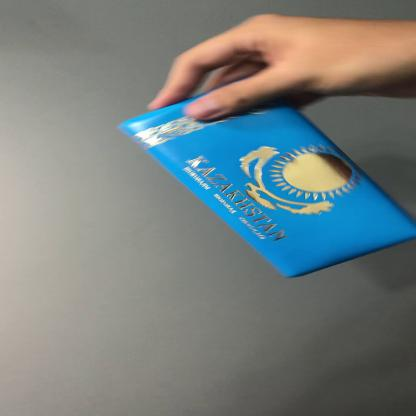



/content/test/Chocolate/images (85)_jpeg.rf.2dbf8d6c161e82da474c5a4691d137d4.jpg
Chocolate


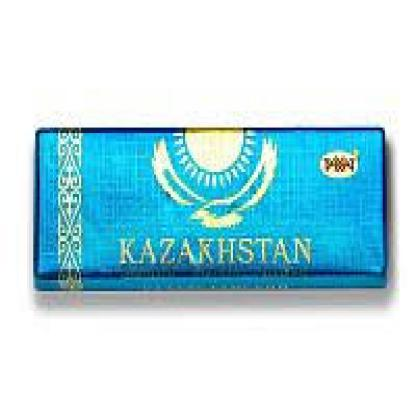



/content/test/Chocolate/download (12)_jpeg.rf.2ce18f674f6866f6511fee28afc5094e.jpg
Chocolate


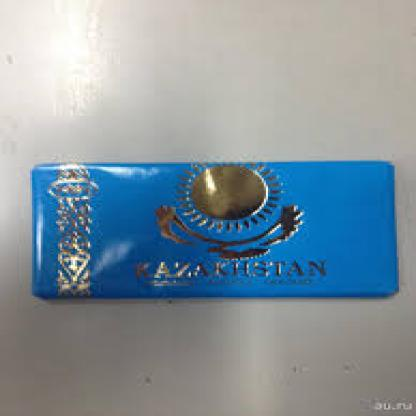



/content/test/Chocolate/IMG_5353_132_jpg.rf.c06bfd8d9898c3306ebc503d256d55d6.jpg
Chocolate


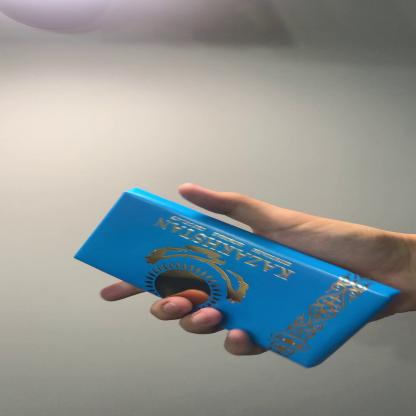



/content/test/Chocolate/images - 2020-11-11T183835-384_jpeg.rf.f8d7f0155b95cd1f59d35d440e2f10c9.jpg
Chocolate


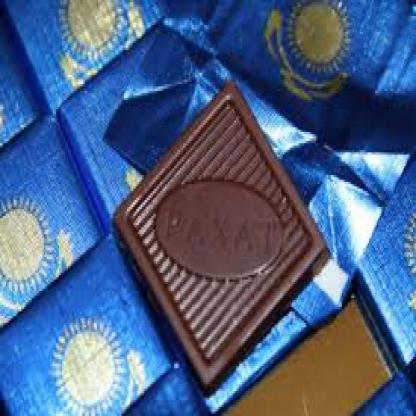



/content/test/Chocolate/IMG_5353_284_jpg.rf.eb9fe2cdbd3f7366f182b02248934a50.jpg
Chocolate


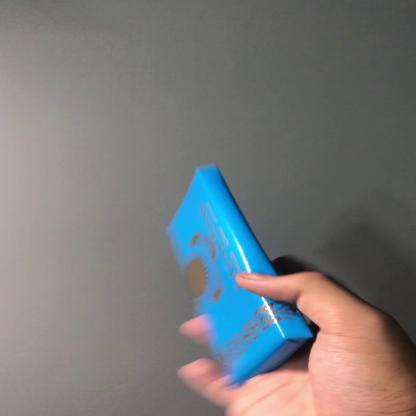



/content/test/Chocolate/IMG_5353_293_jpg.rf.cd8aea95256fa42b9043b3ff13bbf29f.jpg
Chocolate


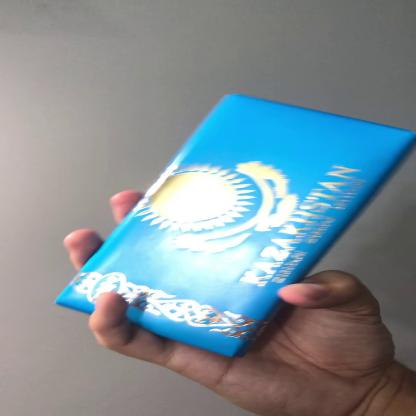



/content/test/Chocolate/IMG_5353_069_jpg.rf.5b6e6d28db2e0ff2d922323742e16270.jpg
Chocolate


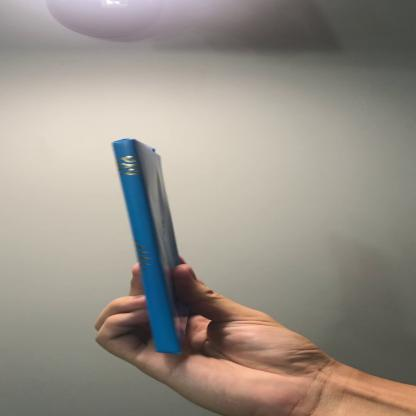



/content/test/Chocolate/IMG_5353_288_jpg.rf.0e1280fbfd4dfb472b6f5c2d63065c44.jpg
Chocolate


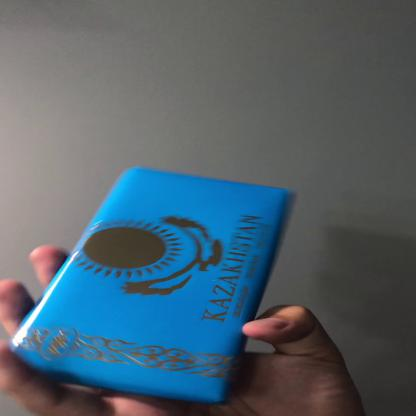

In [ ]:
#run inference on test images
import glob
from IPython.display import Image, display

model = learn.model
model = model.cuda()
for imageName in glob.glob('/content/test/*/*.jpg'):
    print(imageName)
    img = open_image(imageName)
    prediction = learn.predict(img)
    #print(prediction)
    print(prediction[0])
    display(Image(filename=imageName))
    print("\n")

In [ ]:
%ls models/

best_resnet34.pth  tmp.pth


In [ ]:
from google.colab import files
files.download('./models/best_resnet34.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>